# Credit links

## This notebook is used to analyse the credit links of the Ripple network

### 0. Preliminaries
Import all needed libraries, read the transactions data and clean it.

In [1]:
import json
import pandas as pd
import time
import ccy 
from tqdm import tqdm_notebook as tqdm
import collections
from collections import Counter
import pickle

%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib.gridspec import GridSpec

import operator

import urllib.request

import seaborn as sns

import re

import math

We use the Ripple Data API

In [2]:
from ripple_api import RippleDataAPIClient
api = RippleDataAPIClient('https://data.ripple.com')

In [3]:
from coinmarketcap import Market
coinmarketcap = Market()

In [4]:
from currency_converter import CurrencyConverter
c = CurrencyConverter()

Read the data, run only once 

In [5]:
data = []
with open('../data/transactions/more-txs-from-missing-parsed.json') as f:
    for line in tqdm(list(f)):
        data.append(json.loads(line))
with open('../data/transactions/final_txs_2017.json') as f:
    for line in tqdm(list(f)):
        data.append(json.loads(line))

Try to recover some senderCurrency field that are missing. Getting currency of link with sender

In [6]:
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        if 'senderCurrency' not in txn.keys() and 'links' in txn.keys() :
            sender = txn['sender']
            for link in txn['links']:
                if sender == link['node1'] and sender == link['holder'] and link['isIncr'] == False:
                    txn['senderCurrency'] = link['currency']  
                elif sender == link['node1'] and link['holder'] == link['node2'] and link['isIncr'] == True: 
                     txn['senderCurrency'] = link['currency']  
                elif sender == link['node2'] and sender == link['holder'] and link['isIncr'] == False:
                    txn['senderCurrency'] = link['currency']  
                elif sender == link['node2'] and link['holder'] == link['node1'] and link['isIncr'] == True:
                    txn['senderCurrency'] = link['currency']              

Uniform the data because we have fields 'actualReceiverCurrency' and 'receiverCurrency' so put them all under 'receiverCurrency'.

In [7]:
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        if 'actualReceiverCurrency' in txn.keys() :
            txn['receiverCurrency'] = txn['actualReceiverCurrency']
            del txn['actualReceiverCurrency']

Uniform the data because we have fields 'actualReceiverAmount' and 'receiverCurrency' so put them all under 'receiverAmount'.

In [8]:
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        if 'actualReceiverAmount' in txn.keys():
            txn['receiverAmount'] = txn['actualReceiverAmount']
            del txn['actualReceiverAmount']

Recover the senderCurrency, if not done before from the links then it is usually XRP.

In [9]:
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        if 'senderCurrency' not in txn.keys():
            txn['senderCurrency'] = txn['receiverCurrency']    

In [10]:
print(json.dumps(data[1],indent = 4))
print(json.dumps(data[7],indent = 4))

{
    "fee": 1e-05,
    "hash": "3F7A1B3A771D477B03104E86CE73790BB8C8E516BEE680BB4AD9893444D21CF3",
    "sender": "rHb9CJAWyB4rj91VRWn96DkukG4bwdtyTh",
    "success": "tesSUCCESS",
    "XRPAcc": [
        {
            "isIncr": false,
            "account": "rHb9CJAWyB4rj91VRWn96DkukG4bwdtyTh",
            "amount": 1.100000000064938e-05
        },
        {
            "isIncr": true,
            "account": "rbvFfuUysurzPHq5kgs53A16j5svbFxgv",
            "amount": 1.0000001111620804e-06
        }
    ],
    "flags": "",
    "receiver": "rbvFfuUysurzPHq5kgs53A16j5svbFxgv",
    "date": "2013-06-29T13:10:20+00:00",
    "actualIssuerReceiver": "--",
    "receiverCurrency": "XRP",
    "receiverAmount": "0.000001",
    "senderCurrency": "XRP"
}
{
    "fee": 1.2e-05,
    "issuerReceiver": "--",
    "sender": "rQ9ArM8TdHmeQHvd969nQPP1TZosBhzdXg",
    "success": "tesSUCCESS",
    "paths": [
        [
            {
                "account": "ruazs5h1qEsqpke88pcqnaseXdm6od2xc"
            },


### 1. Trust lines
We get all trust lines we need and we save it to disk so we don't have to run it again because it is quite long.

Get trust lines

In [10]:
all_wallets = set(df.sender.tolist())|set(df.sender.tolist())

In [11]:
all_wallets
for txn in tqdm(data):
    all_wallets.add(txn["sender"])
    all_wallets.add(txn["receiver"])

In [13]:
all_wallets = list(all_wallets)

In [14]:
def get_lines(id):
    answer = rpc.account_lines(all_wallets[id])
    if(answer["status"] == 'success'):
        return answer
    else:
        print("error")
        return

In [15]:
def get_lines_range(id_range, store=None):
    """process a number of ids, storing the results in a dict"""
    if store is None:
        store = []
    for id in tqdm(id_range):
        store.append(get_lines(id))
    return store

In [16]:
from threading import Thread

def threaded_process(nthreads, id_range):
    """process the id range in a specified number of threads"""
    store = []
    threads = []
    # create the threads
    for i in range(nthreads):
        ids = id_range[i::nthreads]
        t = Thread(target=get_lines_range, args=(ids,store))
        threads.append(t)

    # start the threads
    [ t.start() for t in threads ]
    # wait for the threads to finish
    [ t.join() for t in threads ]
    return store

In [ ]:
lines = threaded_process(4, range(len(all_wallets)))

In [18]:
while None in lines:
    lines.remove(None) #if there was an error getting the trust line

In [ ]:
with open('../data/trust_lines/trust_lines.pickle', 'wb') as f:
    pickle.dump(lines, f) #save to disk

Open trust lines file

In [8]:
with open('../data/trust_lines/trust_lines.pickle', 'rb') as f:
    trust_lines = pickle.load(f) #load from disk

Here is a example of what data looks like for one wallet

In [43]:
print(json.dumps(trust_lines[0],indent = 4))

{
    "account": "rUPiAddSwJTrkWzGX4aHG1u7eZg9GTV6Bd",
    "ledger_current_index": 46580945,
    "lines": [
        {
            "account": "rfYv1TXnwgDDK4WQNbFALykYuEBnrR4pDX",
            "balance": "0.00001492689992518072",
            "currency": "BTC",
            "limit": "0",
            "limit_peer": "0",
            "no_ripple": true,
            "quality_in": 0,
            "quality_out": 0
        },
        {
            "account": "rfYv1TXnwgDDK4WQNbFALykYuEBnrR4pDX",
            "balance": "0",
            "currency": "LTC",
            "limit": "0",
            "limit_peer": "0",
            "no_ripple": true,
            "quality_in": 0,
            "quality_out": 0
        },
        {
            "account": "rvYAfWj5gh67oV6fW32ZzP3Aw4Eubs59B",
            "balance": "0",
            "currency": "USD",
            "limit": "0",
            "limit_peer": "0",
            "no_ripple": true,
            "quality_in": 0,
            "quality_out": 0
        },
        {
 

First we get the informations about the gateways with the ripple data API:

In [17]:
with open('../data/gateways/gateways_address_to_name.pickle', 'rb') as f:
    gateways_address_to_name = pickle.load(f) #load from disk

We want :
* Know what are the most popular wallet in trust lines
* Map wallet to countries given their trust lines currency 

In [45]:
ctr_lines_with_gateways = 0 #counter for the number of trust lines with gateways
ctr_lines = 0 #counter for the number of trust lines
account_to_currency = collections.defaultdict(list) #dict from account to countries (based on currency of its trust lines)
wallet_count_in_trust_lines = {} #count in how many trust lines a wallet appear
for info in tqdm(trust_lines): 
    for line in info["lines"]:
        ctr_lines += 1
        wallet_count_in_trust_lines[line["account"]] = wallet_count_in_trust_lines.get(line["account"], 0) + 1
        if line["account"] in gateways_address:
            ctr_lines_with_gateways += 1
            
            #if currency is not crypto add it to the list for the account
            try: 
                currency = ccy.currency(line["currency"]).code
                if currency not in account_to_currency[info["account"]]:
                    account_to_currency[info["account"]].append(currency)
            except:
                continue

Now that we have collected the data we wanted, let's analyse it :
 * 3.1.1 What percentage of trust lines are with gateways
 * 3.1.2 Most Common wallets in trust lines 
 * 3.1.3 Over the accounts with trust lines, how many have one with a gateway
 * 3.1.4 Over all accounts, how many have a trust line with a gateway
 * 3.1.5 Currency of trust lines with gateways

#### 1.1 What percentage of trust lines are with gateways

In [16]:
print("There are", ctr_lines_with_gateways/ctr_lines*100,"% of thurst lines that are with gateways")

There are 69.24400759363412 % of thurst lines that are with gateways


#### 1.2 Most Common wallets in trust lines 

In [17]:
wallet_occurences = [(k,v) for k,v in list(wallet_count_in_trust_lines.items())] # convert dict to list of pairs

In [18]:
wallet_occurences.sort(reverse = True,key=lambda wallet_occurences: wallet_occurences[1]) # sort by decressing occurence

In [19]:
gateway_occurences = [(k,v) for k,v in wallet_occurences if k in gateways_address]  # get occurences in trust lines for gateways

In [20]:
gateway_top = [i for i,j in zip(wallet_occurences,gateway_occurences) if i == j] # get first matching elements in occurence of wallets and gateways

In [21]:
print("The",len(gateway_top),"most common wallet in trust lines are gateways")

The 7 most common wallet in trust lines are gateways


#### 1.3 Over the accounts with trust lines, how many have one with a gateway

In [22]:
nb_account_with_turst_lines = len([x for x in trust_lines if len(x["lines"]) >= 1]) #nb of accounts with at least one trust line

In [23]:
nb_account_with_trust_lines_with_gateways =len(account_to_currency.keys()) #nb of accounts with trust line with gateways

In [24]:
print("Over the accounts that have a trust line",nb_account_with_trust_lines_with_gateways/nb_account_with_turst_lines* 100,"% of them have one with a gateway.")

Over the accounts that have a trust line 69.59407239337753 % of them have one with a gateway.


#### 1.4 Over all accounts, how many have a trust line with a gateway

In [25]:
print("Over all accounts",nb_account_with_trust_lines_with_gateways/len(trust_lines)*100,"% of them have a trust line with a gateway.")

Over all accounts 30.165252427154627 % of them have a trust line with a gateway.


#### 1.5 Currency of trust lines with gateways

In [26]:
count_len = {}
for country_list in tqdm(account_to_currency.values()):
    # how many wallets are associated with "n" countries
    count_len[len(country_list)] = count_len.get(len(country_list),0) + 1 
for k,v in count_len.items():
    #percentage of total number of wallets that has trust lines with gateways
    count_len[k] = v/nb_account_with_trust_lines_with_gateways*100 

In [27]:
print("Over the wallets that have trust lines with gateways",count_len[1],"% of them have trust lines with gateways in just 1 currency")
print("And",count_len[2],"% of them have trust lines with gateways in 2 currencies")

Over the wallets that have trust lines with gateways 75.94343467275246 % of them have trust lines with gateways in just 1 currency
And 19.944575760045645 % of them have trust lines with gateways in 2 currencies


### 2. Usage of trust line currencies

We want to analyse how wallets use the currency of their trust lines. The idea is to see if a wallet could be mapped to a country knowing it's trust lines since most of since have trust lines with gateways in 1 or 2 currencies

In [47]:
account_to_currency = collections.defaultdict(set) #dict from account to currency
account_with_trust_lines = set() 
account_with_no_trust_lines = set()
for trust_line in tqdm(trust_lines):
    account = trust_line['account']
    
    #The wallet don't have any trust lines
    if not trust_line['lines']: 
        account_with_no_trust_lines.add(account)
        
    #The wallet has trust lines
    else:
        account_with_trust_lines.add(account)
        for line in trust_line['lines']:
            line_currency = line['currency']
            account_to_currency[account].add(line_currency)

In [48]:
print('We have that',len(account_with_trust_lines)/(len(account_with_trust_lines)+len(account_with_no_trust_lines))*100,'% of wallets that have a trust line')

We have that 43.34457144086471 % of wallets that have a trust line


Now we iterate trough all transactions and count how many times each wallets (as sender and receiver) use the currency of the transaction. We have a counter for currencies of its trust lines, one for XRP and one for other currencies.

In [30]:
sender_to_volume = collections.defaultdict(dict) #dcit from sender (wallet) to usage of currency 
receiver_to_volume = collections.defaultdict(dict)

for txn in tqdm(data):
    if txn['success'] == 'tesSUCCESS':
        
        #Senders
        sender = txn['sender']
        if sender in account_to_currency.keys(): # if sender has trust lines
            currency_list = account_to_currency[sender]
            sender_currency = txn['senderCurrency']
            
            # Currency of trust lines
            if sender_currency in currency_list:
                sender_to_volume[sender] = sender_to_volume.get(sender,{})
                sender_to_volume[sender][sender_currency] = sender_to_volume[sender].get(sender_currency,0) + 1
                
            # XRP
            elif sender_currency == 'XRP':
                sender_to_volume[sender] = sender_to_volume.get(sender,{})
                sender_to_volume[sender]['XRP'] = sender_to_volume[sender].get('XRP',0) + 1
                
            # Others
            else:
                sender_to_volume[sender] = sender_to_volume.get(sender,{})
                sender_to_volume[sender]['others'] = sender_to_volume[sender].get('others',0) + 1
                
        #Receivers
        receiver = txn['receiver']
        if receiver in account_to_currency.keys(): # if receiver has trust lines
            currency_list = account_to_currency[receiver]
            receiver_currency = txn['receiverCurrency']
            
            # Currency of trust lines
            if receiver_currency in currency_list:
                receiver_to_volume[receiver] = receiver_to_volume.get(receiver,{})
                receiver_to_volume[receiver][receiver_currency] = receiver_to_volume[receiver].get(receiver_currency,0) + 1
                
            # XRP
            elif receiver_currency == 'XRP':
                receiver_to_volume[receiver] = receiver_to_volume.get(receiver,{})
                receiver_to_volume[receiver]['XRP'] = receiver_to_volume[receiver].get('XRP',0) + 1
                
            # Others
            else:
                receiver_to_volume[receiver] = receiver_to_volume.get(receiver,{})
                receiver_to_volume[receiver]['others'] = receiver_to_volume[receiver].get('others',0) + 1

We know convert counts to percentages for senders and receivers

In [31]:
for sender, volume_list in tqdm(sender_to_volume.items()):
    nb_txns = sum(volume_list.values()) #sum of all transactions 
    for currency, volume in volume_list.items():
        sender_to_volume[sender][currency] = sender_to_volume[sender][currency]/nb_txns*100 #percentage
        
for receiver, volume_list in tqdm(receiver_to_volume.items()):
    nb_txns = sum(volume_list.values()) #sum of all transactions 
    for currency, volume in volume_list.items():
        receiver_to_volume[receiver][currency] = receiver_to_volume[receiver][currency]/nb_txns*100 #percentage

In [32]:
sender_only_trust = set() #senders using only the currency of their trust lines
sender_trust_and_XRP = set() #senders using the currency of their trust lines and XPR
sender_trust_and_others = set() #senders using the currency of their trust lines and 'others' currency (not XRP)

for sender,volume in tqdm(sender_to_volume.items()):
    #Only trust line currencies
    if 'XRP' not in volume.keys() and 'others' not in volume.keys(): 
        sender_only_trust.add(sender)
        
    #Trust line currencies and XRP
    if 'XRP' in volume.keys() and 'others' not in volume.keys() and len(volume.keys()) > 1:
        sender_trust_and_XRP.add(sender)
        
    #Trust line currencies and 'others' currencies
    if 'XRP' not in volume.keys() and 'others' in volume.keys() and len(volume.keys()) > 1:
        sender_trust_and_others.add(sender)
        
        
receiver_only_trust = set() #receivers using only the currency of their trust lines
receiver_trust_and_XRP = set() #receivers using the currency of their trust lines and XPR
receiver_trust_and_others = set() #receivers using the currency of their trust lines and 'others' currency (not XRP)

for receiver,volume in tqdm(receiver_to_volume.items()):
    #Only trust line currencies
    if 'XRP' not in volume.keys() and 'others' not in volume.keys():
        receiver_only_trust.add(receiver)
        
    #Trust line currencies and XRP
    if 'XRP' in volume.keys() and 'others' not in volume.keys() and len(volume.keys()) > 1:
        receiver_trust_and_XRP.add(receiver)
        
    #Trust line currencies and 'others' currencies    
    if 'XRP' not in volume.keys() and 'others' in volume.keys() and len(volume.keys()) > 1:
        receiver_trust_and_others.add(receiver)

In [34]:
print('We have',len(sender_only_trust)/len(sender_to_volume)*100,'% of senders that have trust line that only use currency of their trust lines')
print('We have',len(sender_trust_and_XRP)/len(sender_to_volume)*100,'% of senders that have trust line that use XRP and currencies of their trust lines')
print('We have',len(sender_trust_and_others)/len(sender_to_volume)*100,'% of senders that have trust line that use currencies of their trust lines and other currencies (others that XRP)')
print('We have',(len(sender_only_trust)+len(sender_trust_and_XRP)+len(sender_trust_and_others))/len(sender_to_volume)*100,'% of senders that have trust line that use them')
print()
print('We have',len(receiver_only_trust)/len(receiver_to_volume)*100,'% of receiver that have trust line that only use currency of their trust lines')
print('We have',len(receiver_trust_and_XRP)/len(receiver_to_volume)*100,'% of receiver that have trust line that use XRP and currencies of their trust lines')
print('We have',len(receiver_trust_and_others)/len(receiver_to_volume)*100,'% of receiver that have trust line that use currencies of their trust lines and other currencies (others that XRP)')
print('We have',(len(receiver_only_trust)+len(receiver_trust_and_XRP)+len(receiver_trust_and_others))/len(receiver_to_volume)*100,'% of receiver that have trust line that use them')

We have 21.030924121535218 % of senders that have trust line that only use currency of their trust lines
We have 20.94267240602993 % of senders that have trust line that use XRP and currencies of their trust lines
We have 0.23773931523872988 % of senders that have trust line that use currencies of their trust lines and other currencies (others that XRP)
We have 42.211335842803884 % of senders that have trust line that use them

We have 4.890562290537465 % of receiver that have trust line that only use currency of their trust lines
We have 22.727460796888575 % of receiver that have trust line that use XRP and currencies of their trust lines
We have 0.0558566759071538 % of receiver that have trust line that use currencies of their trust lines and other currencies (others that XRP)
We have 27.673879763333197 % of receiver that have trust line that use them


Now we put those number in perspective to see what percentage of transactions their represents

In [50]:
sender_use_trust = sender_only_trust | sender_trust_and_XRP | sender_trust_and_others #union of all senders that uses their trust lines
receiver_use_trust = receiver_only_trust | receiver_trust_and_XRP | receiver_trust_and_others  #union of all receivers that uses their trust lines

In [49]:
sender_nb_txn_use = 0 #counter for transactions of senders that use trust lines
receiver_nb_txn_use = 0 #counter for transactions of receivers that use trust lines

for txn in tqdm(data):
    if txn['success'] == 'tesSUCCESS':
        #Senders
        if txn['sender'] in sender_use_trust:
            sender_nb_txn_use+=1
            
        #Receivers
        if txn['receiver'] in receiver_use_trust:
            receiver_nb_txn_use+=1
            
print('Senders that uses their trust lines represents',sender_nb_txn_use/len(data)*100,'% of transactions.')
print('Receiver that uses their trust lines represents',receiver_nb_txn_use/len(data)*100,'% of transactions.')


Senders that uses their trust lines represents 13.632137433943777 % of transactions.
Receiver that uses their trust lines represents 11.4749290802566 % of transactions.


### 3. Hop analysis per year per currency based on txns 

The next cell keeps only transactions where the date is in a good format 

In [12]:
new_data = []
pattern = re.compile(r'\d{4}-\d{2}-\d{2}T.+')
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        if 'date' in txn.keys():
            if pattern.match(str(txn['date'])):
                txn['date'] = txn['date'].split('T')[0]
                new_data.append(txn)
data = new_data
del new_data

Then we group transactions by year and month to perform our analysis 

In [13]:
txn_per_date = {}
for txn in tqdm(data):
    (year,month,day) = txn['date'].split('-')
    if year not in txn_per_date.keys():
        txn_per_date[year] = {}
    if month not in txn_per_date[year].keys():
        txn_per_date[year][month] = []
    txn_per_date[year][month].append(txn)

We know get the informations about the gateways

In [23]:
with open('../data/transactions/gateways_address_to_name.pickle', 'rb') as f:
    gateways_address_to_name = pickle.load(f) #load from disk

In [14]:
with open('../data/transactions/gateway_to_country.pickle', 'rb') as f:
    gateways_names_to_countries = pickle.load(f) #load from disk

In [15]:
crypto = coinmarketcap.ticker(start=0, convert='XRP')

In [16]:
currency_to_XRP = {}
for crypto_id,details in tqdm(crypto['data'].items()):
    if details['symbol'] == 'XRP':
        currency_to_XRP['USD'] = details['quotes']['USD']['price']
    else:
        currency_to_XRP[details['symbol']] = details['quotes']['XRP']['price']

The next function apply a function (either one sender or receivers) to each txn

In [17]:
def apply(function,is_volume):
    result = {}
    for year in tqdm(txn_per_date.keys()):
        if year not in result.keys():
            result[year] = {}
            for month in txn_per_date[year].keys():
                    for txn in txn_per_date[year][month]: 
                        (currency,hop) = function(txn)
                        if currency not in result[year].keys():
                            result[year][currency] = {}
                        if month not in result[year][currency].keys():
                            result[year][currency][month] = {}
                        if hop not in result[year][currency][month].keys():
                            result[year][currency][month][hop] = 0
                            
                        if is_volume:
                            receiver_curr = txn['receiverCurrency']
                            if receiver_curr == 'XRP':
                                rate = 1
                            else:
                                if receiver_curr in currency_to_XRP.keys():
                                    rate = currency_to_XRP[receiver_curr]  
                                else: 
                                    try:
                                        rate = c.convert(1, 'USD', receiver_curr) * currency_to_XRP['USD']
                                    except ValueError:
                                        rate = 1
                            amount = rate * float(txn['receiverAmount'])
                        else:
                            amount = 1
                            
                        result[year][currency][month][hop]+=amount
                    
    for year in result.keys():
        for currency in result[year].keys():
            for month in result[year][currency].keys():
                result[year][currency][month] = collections.OrderedDict(sorted(result[year][currency][month].items()))
            result[year][currency] = collections.OrderedDict(sorted(result[year][currency].items()))
    return result

The next two functions takes as input a transaction and characterize the first path of the transaction if any.

In [31]:
def get_result_sender(txn):
    sender = txn['sender']
    sender_currency = txn['senderCurrency']
    if sender_currency == 'XRP':
        return (sender_currency,'direct') #XRP has only direct txns
    if 'links' in txn.keys():
        could_not_find = False
        #for a given link the sender could either be node1 or node2 and be the 'holder' of the link or not. 
        #We treat the four cases bellow
        for link in txn['links']: 
            if sender == link['node1'] and sender == link['holder'] and link['isIncr'] == False:
                if link['node2'] in gateways_address_to_name.keys():
                    return (sender_currency,gateways_address_to_name[link['node2']])
                else:
                    return (sender_currency,link['node2'])
                    #return (sender_currency,'others')
            elif sender == link['node1'] and link['holder'] == link['node2'] and link['isIncr'] == True: 
                if link['node2'] in gateways_address_to_name.keys():
                    return (sender_currency,gateways_address_to_name[link['node2']])
                else:
                    return (sender_currency,link['node2'])
                    #return (sender_currency,'others')
            elif sender == link['node2'] and sender == link['holder'] and link['isIncr'] == False:
                if link['node1'] in gateways_address_to_name.keys():
                    return (sender_currency,gateways_address_to_name[link['node1']])
                else:
                    return (sender_currency,link['node1'])
                    #return (sender_currency,'others')
            elif sender == link['node2'] and link['holder'] == link['node1'] and link['isIncr'] == True:
                if link['node1'] in gateways_address_to_name.keys():
                    return (sender_currency,gateways_address_to_name[link['node1']])
                else:
                    return (sender_currency,link['node1'])
                    #return (sender_currency,'others')
            else:
                could_not_find = True
            # sender is not the source of the first link
        if could_not_find:
            return(sender_currency,'via_or_no_link_info')  
    else:
        #should have links since it's not XRP but there are missing
        return (sender_currency,'no_link_info')

In [32]:
def get_result_receiver(txn):
    receiver = txn['receiver']
    receiver_currency = txn['receiverCurrency']
    if receiver_currency == 'XRP':
        return (receiver_currency,'direct') #XRP has only direct txns
    if 'links' in txn.keys():
        could_not_find = False        
        #for a given link the sender could either be node1 or node2 and be the 'holder' of the link or not. 
        #We treat the four cases bellow
        for link in txn['links']: 
            if receiver == link['node1'] and receiver == link['holder'] and link['isIncr'] == True:
                if link['node2'] in gateways_address_to_name.keys():
                    return (receiver_currency,gateways_address_to_name[link['node2']])
                else:
                    #return (receiver_currency,'others')
                    return (receiver_currency,link['node2'])
            elif receiver == link['node1'] and link['holder'] == link['node2'] and link['isIncr'] == False: 
                if link['node2'] in gateways_address_to_name.keys():
                    return (receiver_currency,gateways_address_to_name[link['node2']])
                else:
                    #return (receiver_currency,'others')
                    return (receiver_currency,link['node2'])
            elif receiver == link['node2'] and receiver == link['holder'] and link['isIncr'] == True:
                if link['node1'] in gateways_address_to_name.keys():
                    return (receiver_currency,gateways_address_to_name[link['node1']])
                else:
                    #return (receiver_currency,'others')
                    return (receiver_currency,link['node1'])
            elif receiver == link['node2'] and link['holder'] == link['node1'] and link['isIncr'] == False:
                if link['node1'] in gateways_address_to_name.keys():
                    return (receiver_currency,gateways_address_to_name[link['node1']])
                else:
                    #return (receiver_currency,'others')
                    return (receiver_currency,link['node1'])
            else:
                could_not_find = True
            # receiver is not the end of the last link
        if could_not_find:
            return(receiver_currency,'via_or_no_link_info')
    else:
        #should have links since it's not XRP but there are missing
        return (receiver_currency,'no_link_info')

In [18]:
def process(year,currency,result):
    dat = result[year][currency]
    all_gateways = set()
    for distribution in dat.values():
        for gateway in distribution.keys():
            all_gateways.add(gateway)

    test = {}
    for gateway in all_gateways:
        test[gateway] = np.zeros(len(dat))
    
    index = 0
    for month,distribution in dat.items():
        for gateway, count in distribution.items():
            test[gateway][index] = count
        index+=1
        
    new_test = {}
    maxi = max(max(counts) for counts in test.values())
    for gateway,counts in test.items():
        if max(counts) > 0.01*maxi:
            new_test[gateway] = counts
            
    return new_test

The next functions are used to plot the computed first hops over a year for a given currency

In [43]:
def plot_per_gateway(dat,year,given_currency,y_label,hop_type,color_dict):
    plt.figure(figsize=(20,10))
    
    try:
        currency = given_currency + (' ('+ccy.country(ccy.currency(currency).default_country)+')')
    except:
        currency = given_currency
    
    nb_gateways = len(dat.keys())
    nb_month = len(list(dat.values())[0])

    truc = 0
    for gateway,counts in dat.items():
        color = color_dict[gateway]
        if gateway in gateways_names_to_countries.keys():
            gateway+= ' (' + gateways_names_to_countries[gateway]+')'
        plt.bar(np.arange(nb_month)+truc,counts,label= gateway,color = color)
        truc+= nb_month+1
  
    plt.xticks(np.delete(np.arange(0,((nb_month+1)*nb_gateways)-1),np.arange(nb_month,(nb_month+1)*(nb_gateways-1),(nb_month+1))),np.tile(np.arange(1,nb_month+1),nb_gateways))
    plt.xlabel('Gateways')
    plt.title((' ').join(y_label.split('_'))+' processed by gateways as '+ (' ').join(hop_type.split('_')) +' \n for '+ currency +' in '+ year + ' per gateway')
    plt.ylabel((' ').join(y_label.split('_')))
    
    #plt.yscale('log')
    plt.legend()
    plt.savefig('../visualisations/'+y_label+'_processed_by_gateways_as_'+hop_type+'_for_'+ given_currency +'_in_'+ year+'_per_gateway.png',dpi = 255)
    plt.show() 

In [44]:
def plot_per_month(dat,year,given_currency,y_label,hop_type,color_dict):
    plt.figure(figsize=(20,10))
    
    try:
        currency = given_currency + (' ('+ccy.country(ccy.currency(currency).default_country)+')')
    except:
        currency = given_currency
    
    nb_gateways = len(dat.keys())
    nb_month = len(list(dat.values())[0])

    truc = 0
    for gateway,counts in dat.items():
        color = color_dict[gateway]
        if gateway in gateways_names_to_countries.keys():
            gateway+= ' (' + gateways_names_to_countries[gateway]+')'
        x = np.arange(0,nb_month*(1+nb_gateways),1+nb_gateways)+truc
        plt.bar(x,counts,label= gateway,color = color)
        truc+= 1
        
    y = np.zeros((nb_gateways+1)*nb_month, dtype=int)    
    i=1
    for index in range(0,len(y),nb_gateways):
        y[index:index+nb_gateways] = i
        i+=1
    plt.xticks(np.delete(np.arange(0,((nb_gateways+1)*nb_month)-1),np.arange(nb_gateways,(nb_gateways+1)*(nb_month-1),(nb_gateways+1))),y)

    #plt.xticks(np.arange((nb_gateways-1)//2,nb_month*((nb_gateways-1)//2+nb_gateways),(nb_gateways-1)//2+nb_gateways),np.arange(nb_month)+1)
    plt.xlabel('Months')
    plt.title((' ').join(y_label.split('_'))+' processed by gateways as '+ (' ').join(hop_type.split('_')) +' \n for '+ currency +' in '+ year+ ' per month')
    plt.ylabel((' ').join(y_label.split('_')))
    
    #plt.yscale('log')
    plt.legend()
    plt.savefig('../visualisations/'+y_label+'_processed_by_gateways_as_'+hop_type+'_for_'+ given_currency +'_in_'+ year+'_per_month.png',dpi = 255)
    plt.show()

#### 3.2 Get the results

In [34]:
result_sender = apply(get_result_sender, is_volume = False)
result_sender_volume = apply(get_result_sender, is_volume = True)
result_receiver = apply(get_result_receiver, is_volume = False)
result_receiver_volume = apply(get_result_receiver, is_volume = True)

##### CNY

In [36]:
dat_CNY_sender = process('2017','CNY',result_sender)
dat_CNY_sender_volume = process('2017','CNY',result_sender_volume)
dat_CNY_receiver = process('2017','CNY',result_receiver)
dat_CNY_receiver_volume = process('2017','CNY',result_receiver_volume)

In [39]:
all_gateways = set(dat_CNY_sender.keys()) | set(dat_CNY_sender_volume.keys()) | set(dat_CNY_receiver.keys()) | set(dat_CNY_receiver_volume.keys())
# define the colormap
colormap = plt.cm.rainbow
# extract all colors from the .viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(all_gateways))]

gateways_to_colors = {}
index_color = 0
for gateway in all_gateways:
    gateways_to_colors[gateway] = colors[index_color]
    index_color+=1

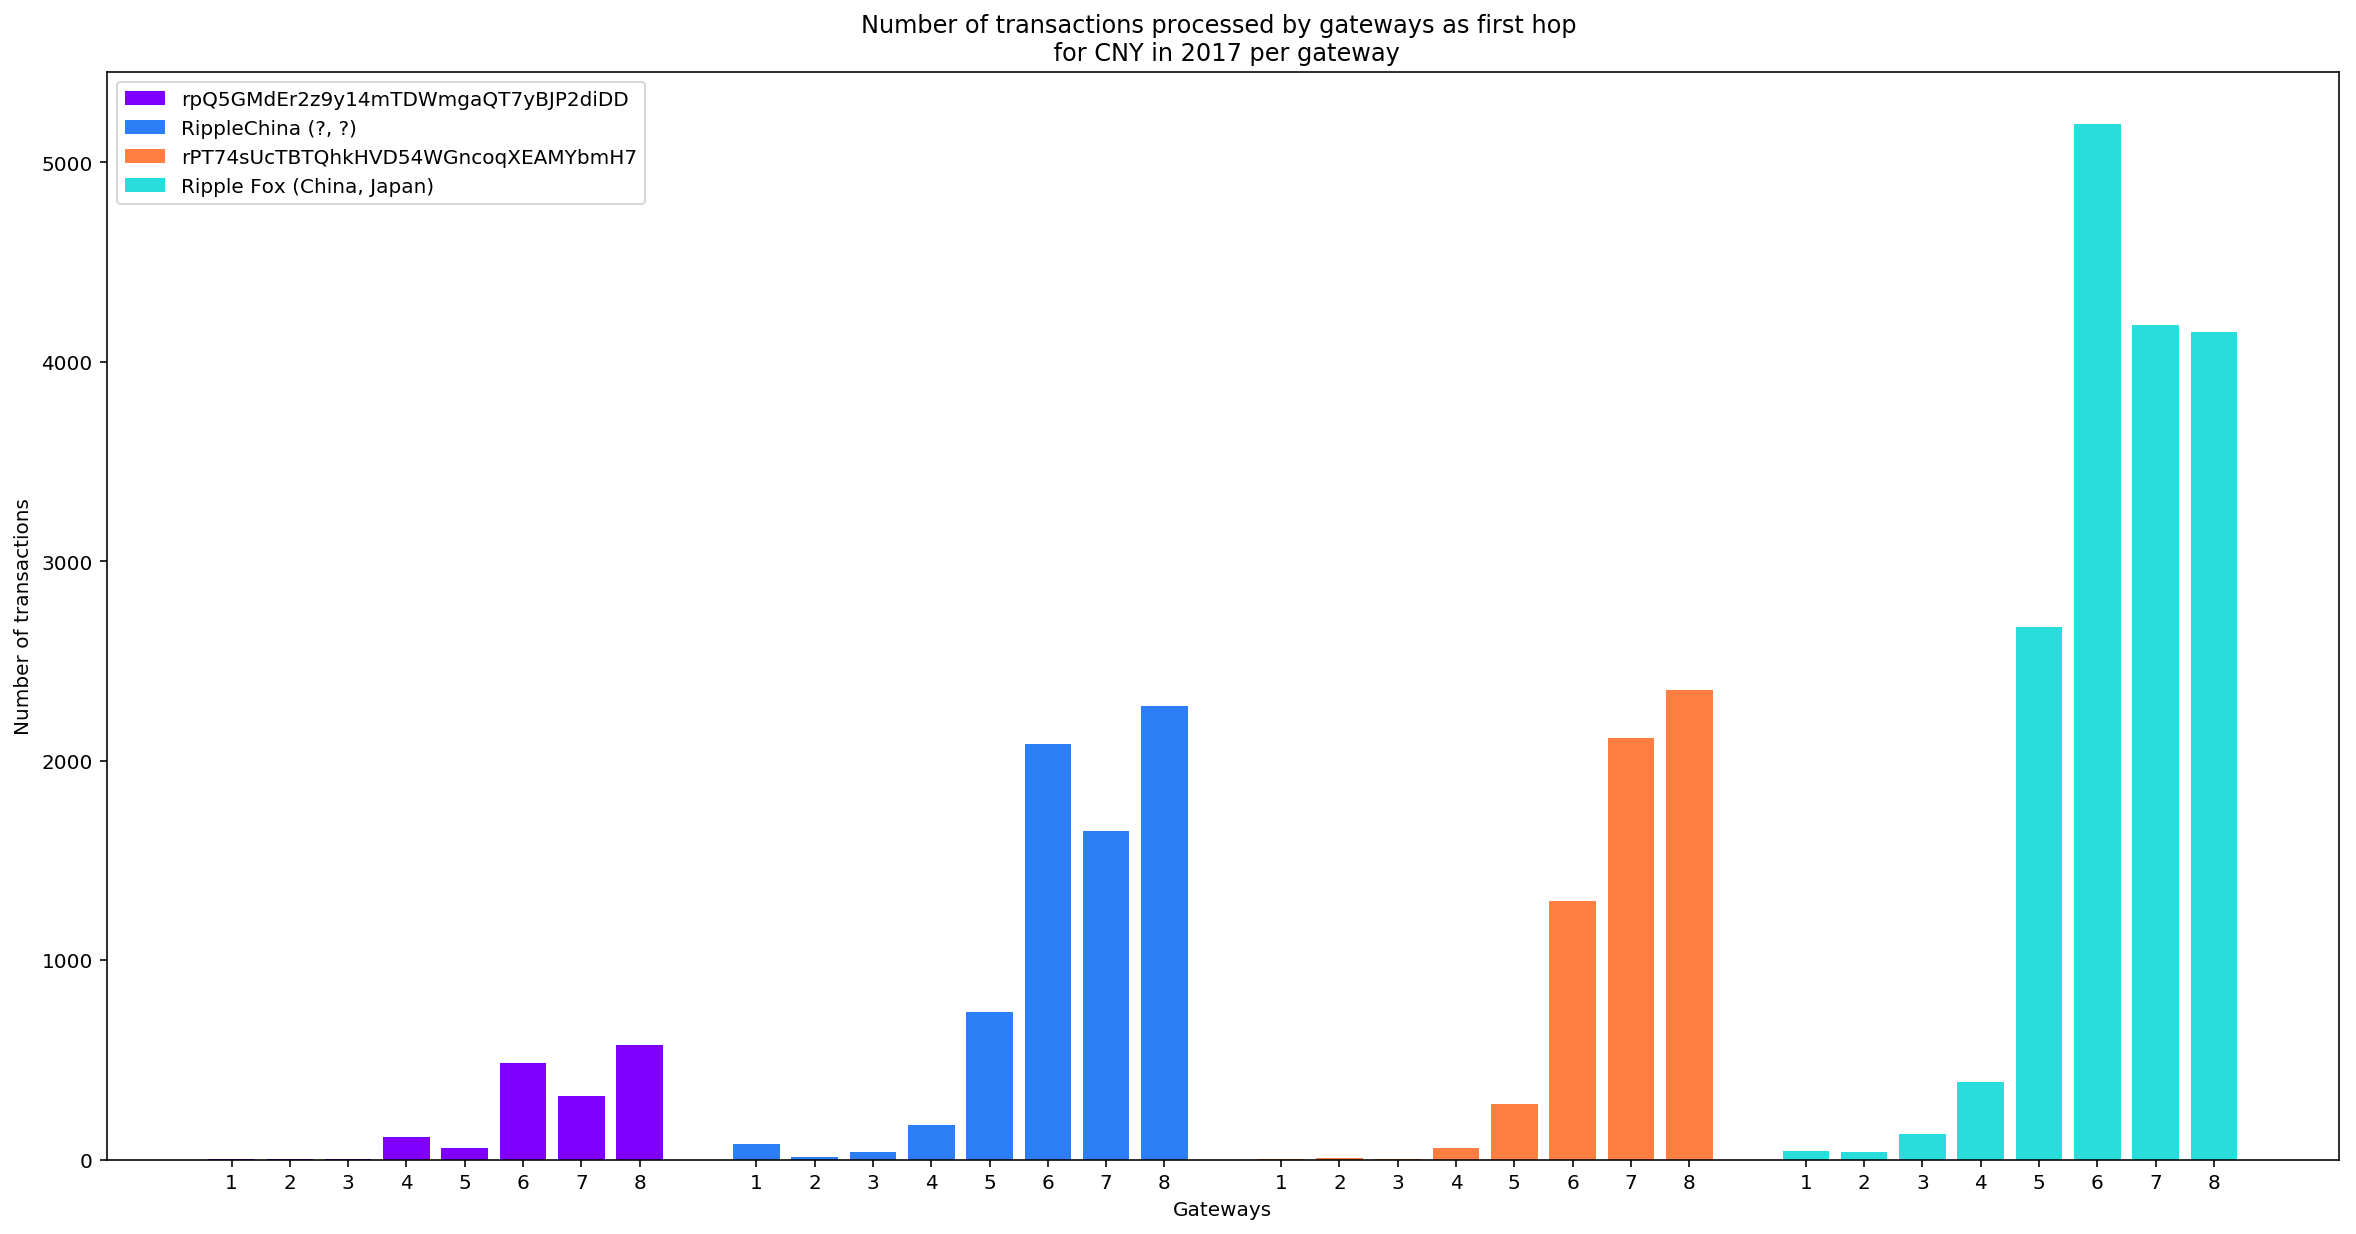

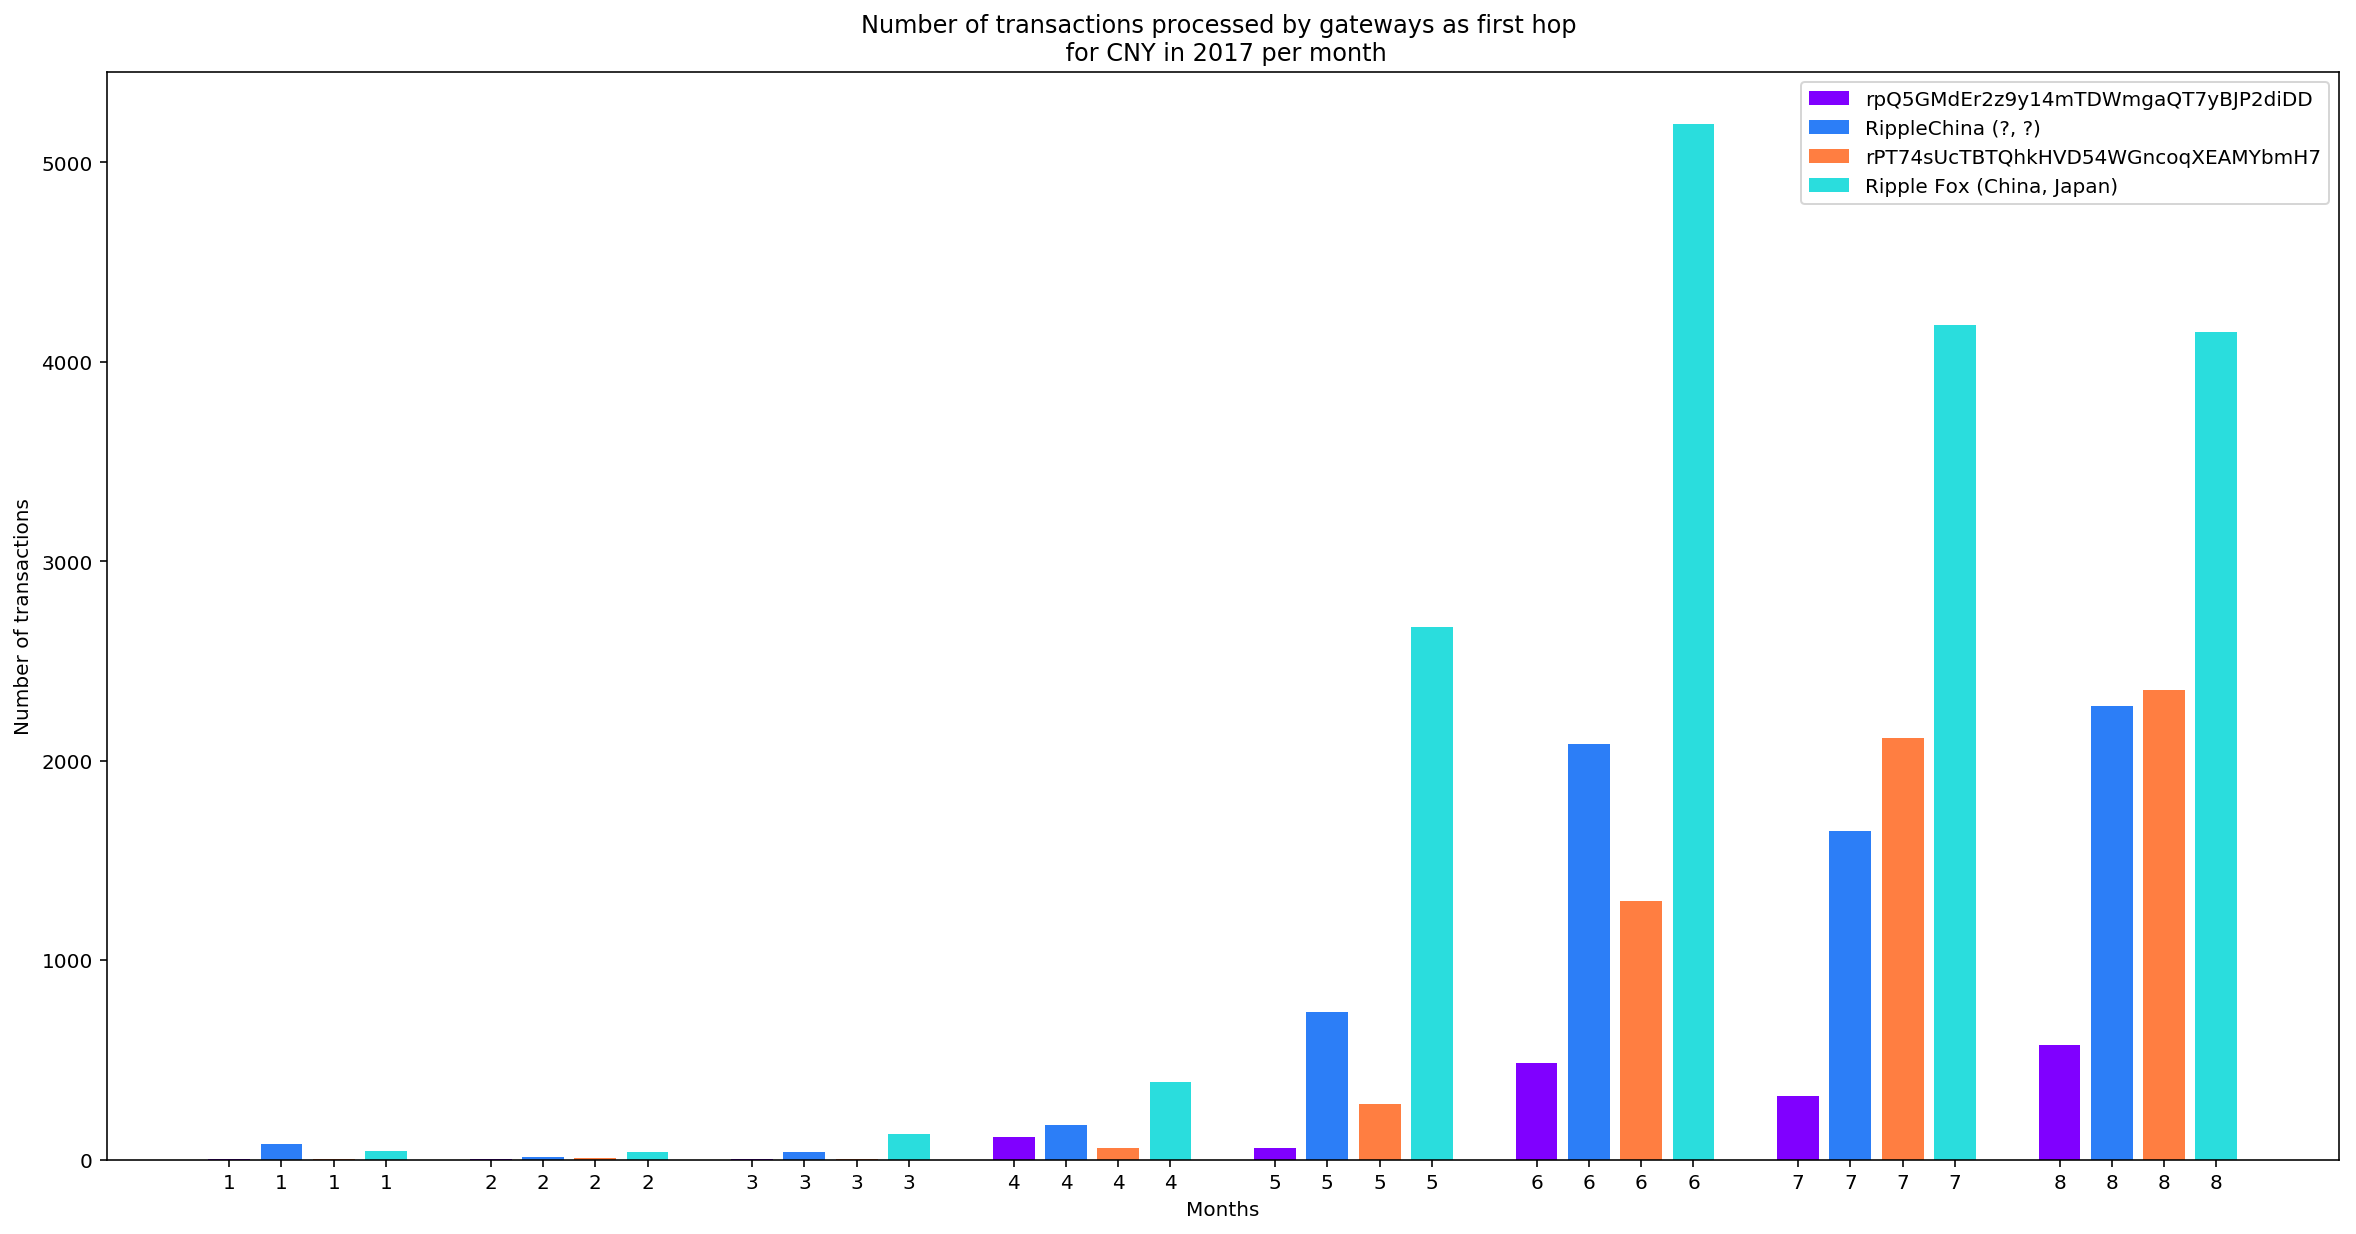

In [45]:
plot_per_gateway(dat_CNY_sender,'2017','CNY','Number_of_transactions','first_hop',gateways_to_colors)
plot_per_month(dat_CNY_sender,'2017','CNY','Number_of_transactions','first_hop',gateways_to_colors)

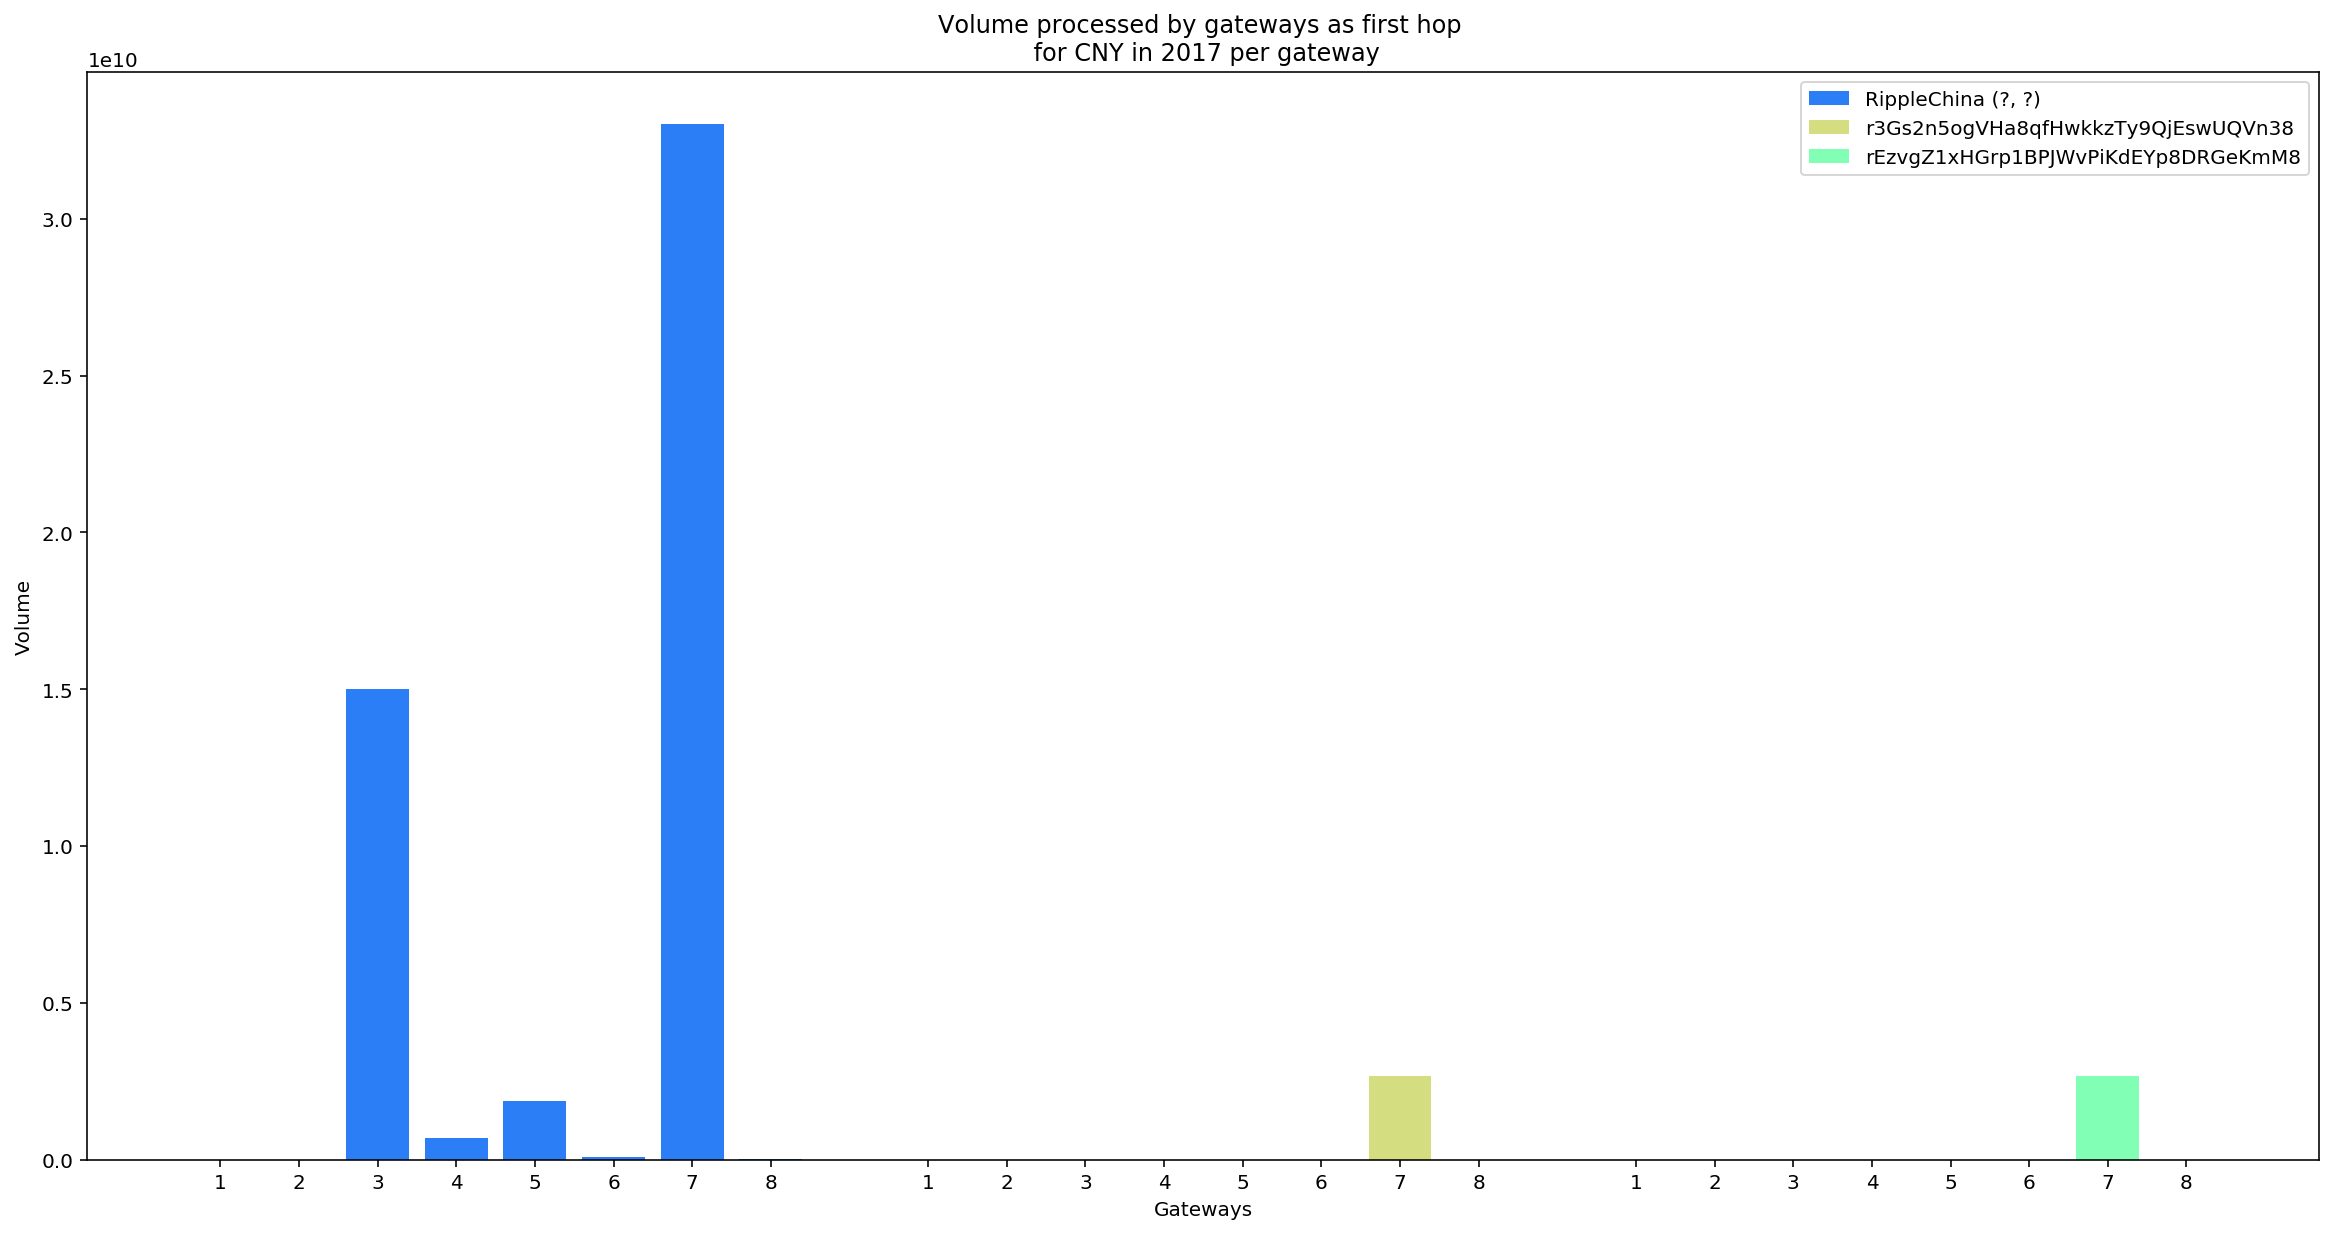

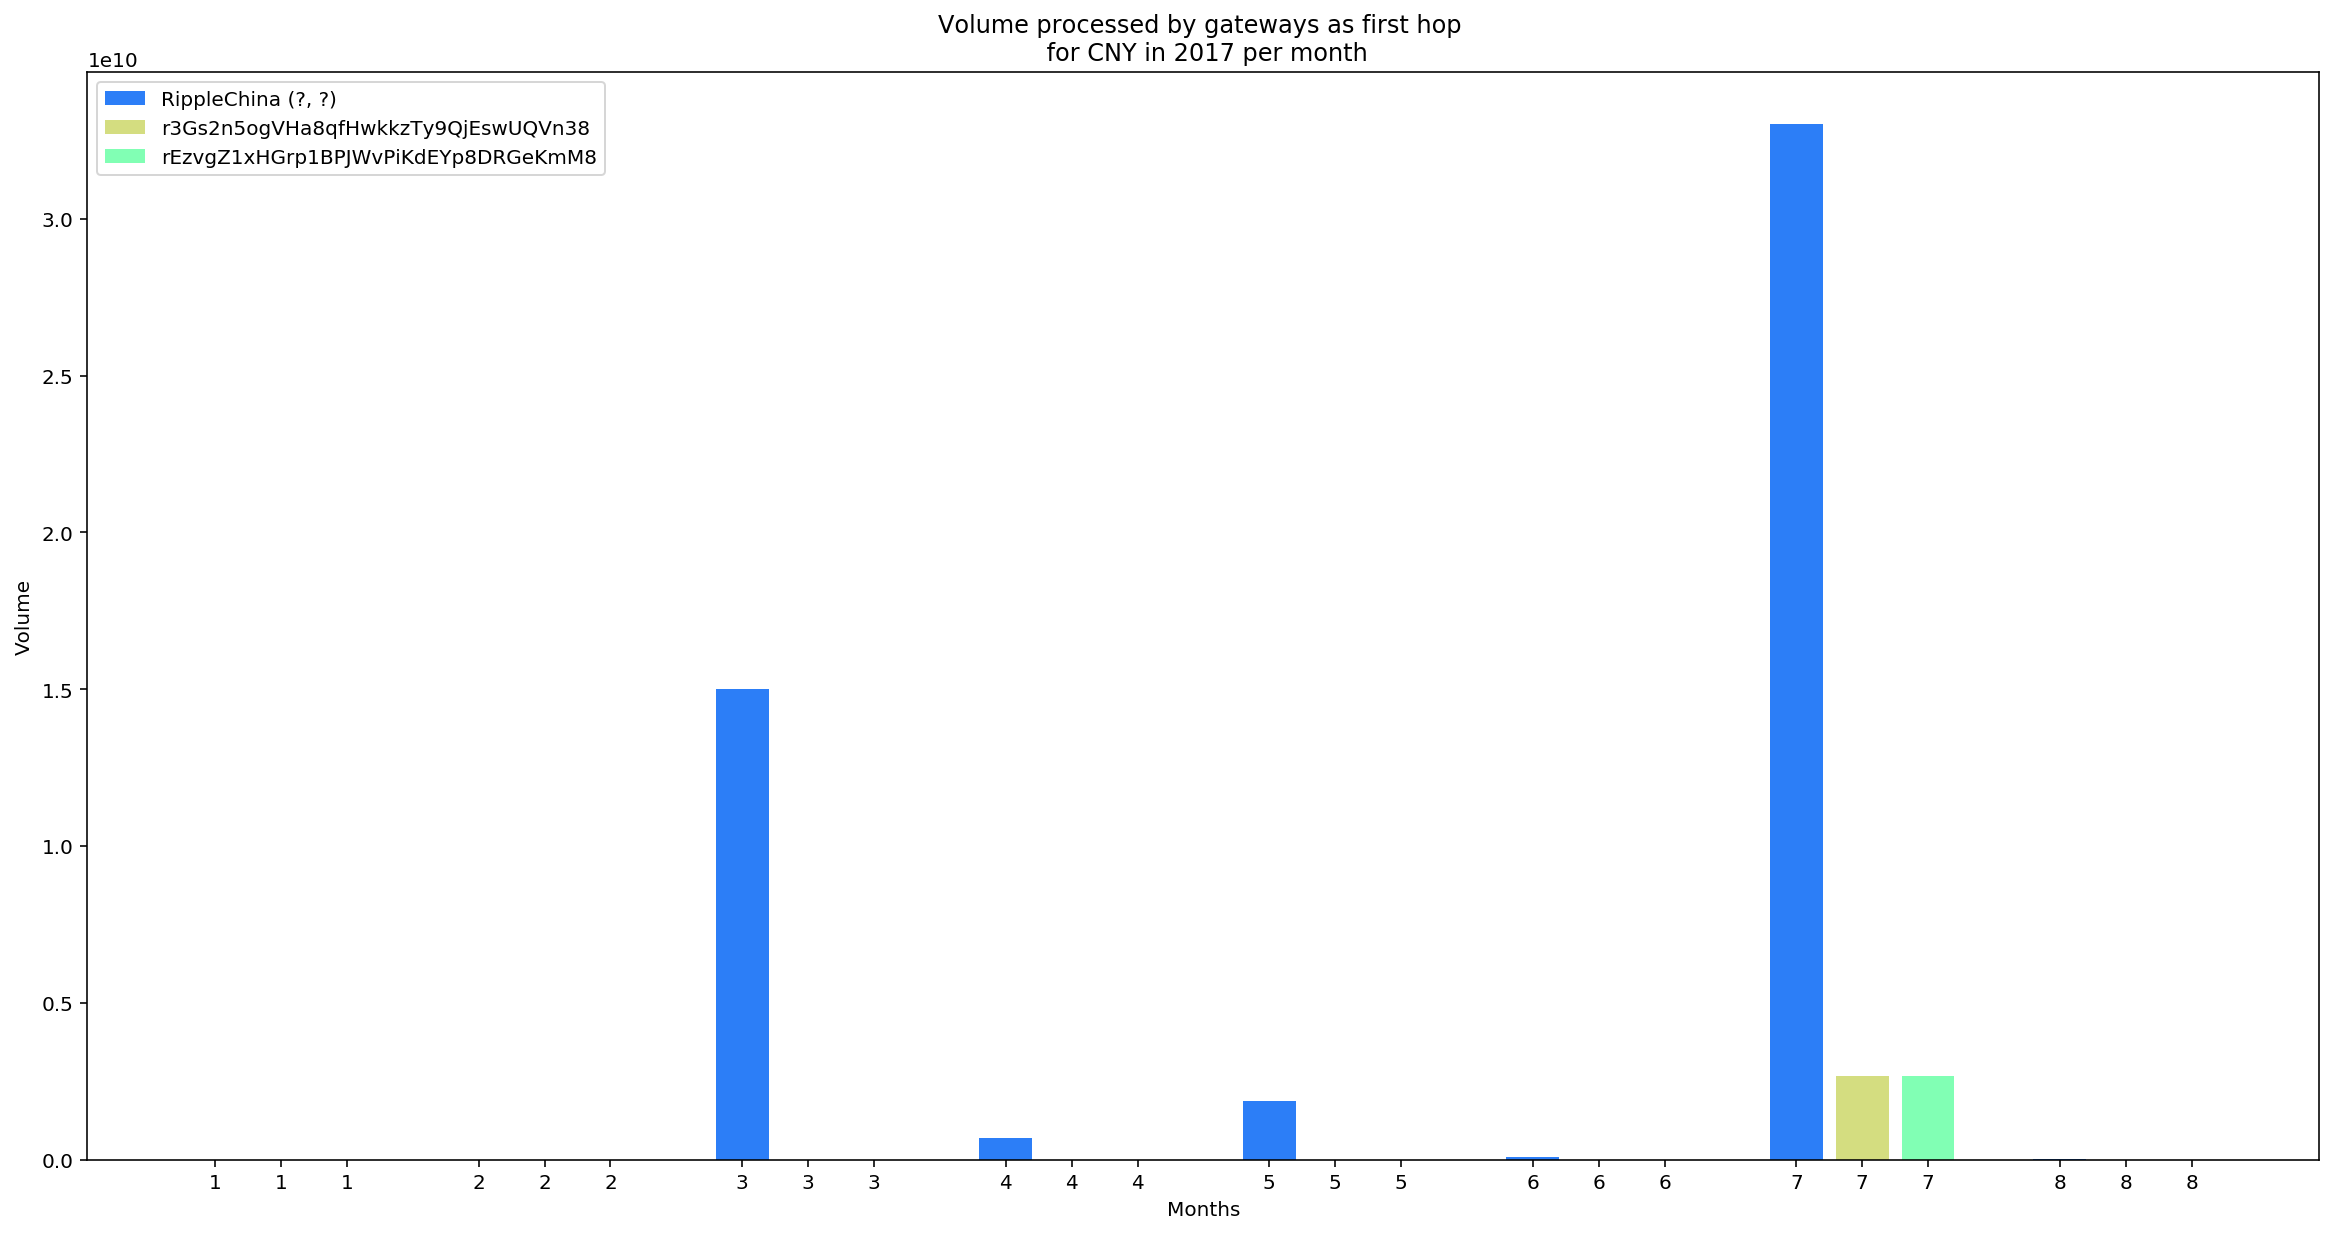

In [46]:
plot_per_gateway(dat_CNY_sender_volume,'2017','CNY','Volume','first_hop',gateways_to_colors)
plot_per_month(dat_CNY_sender_volume,'2017','CNY','Volume','first_hop',gateways_to_colors)

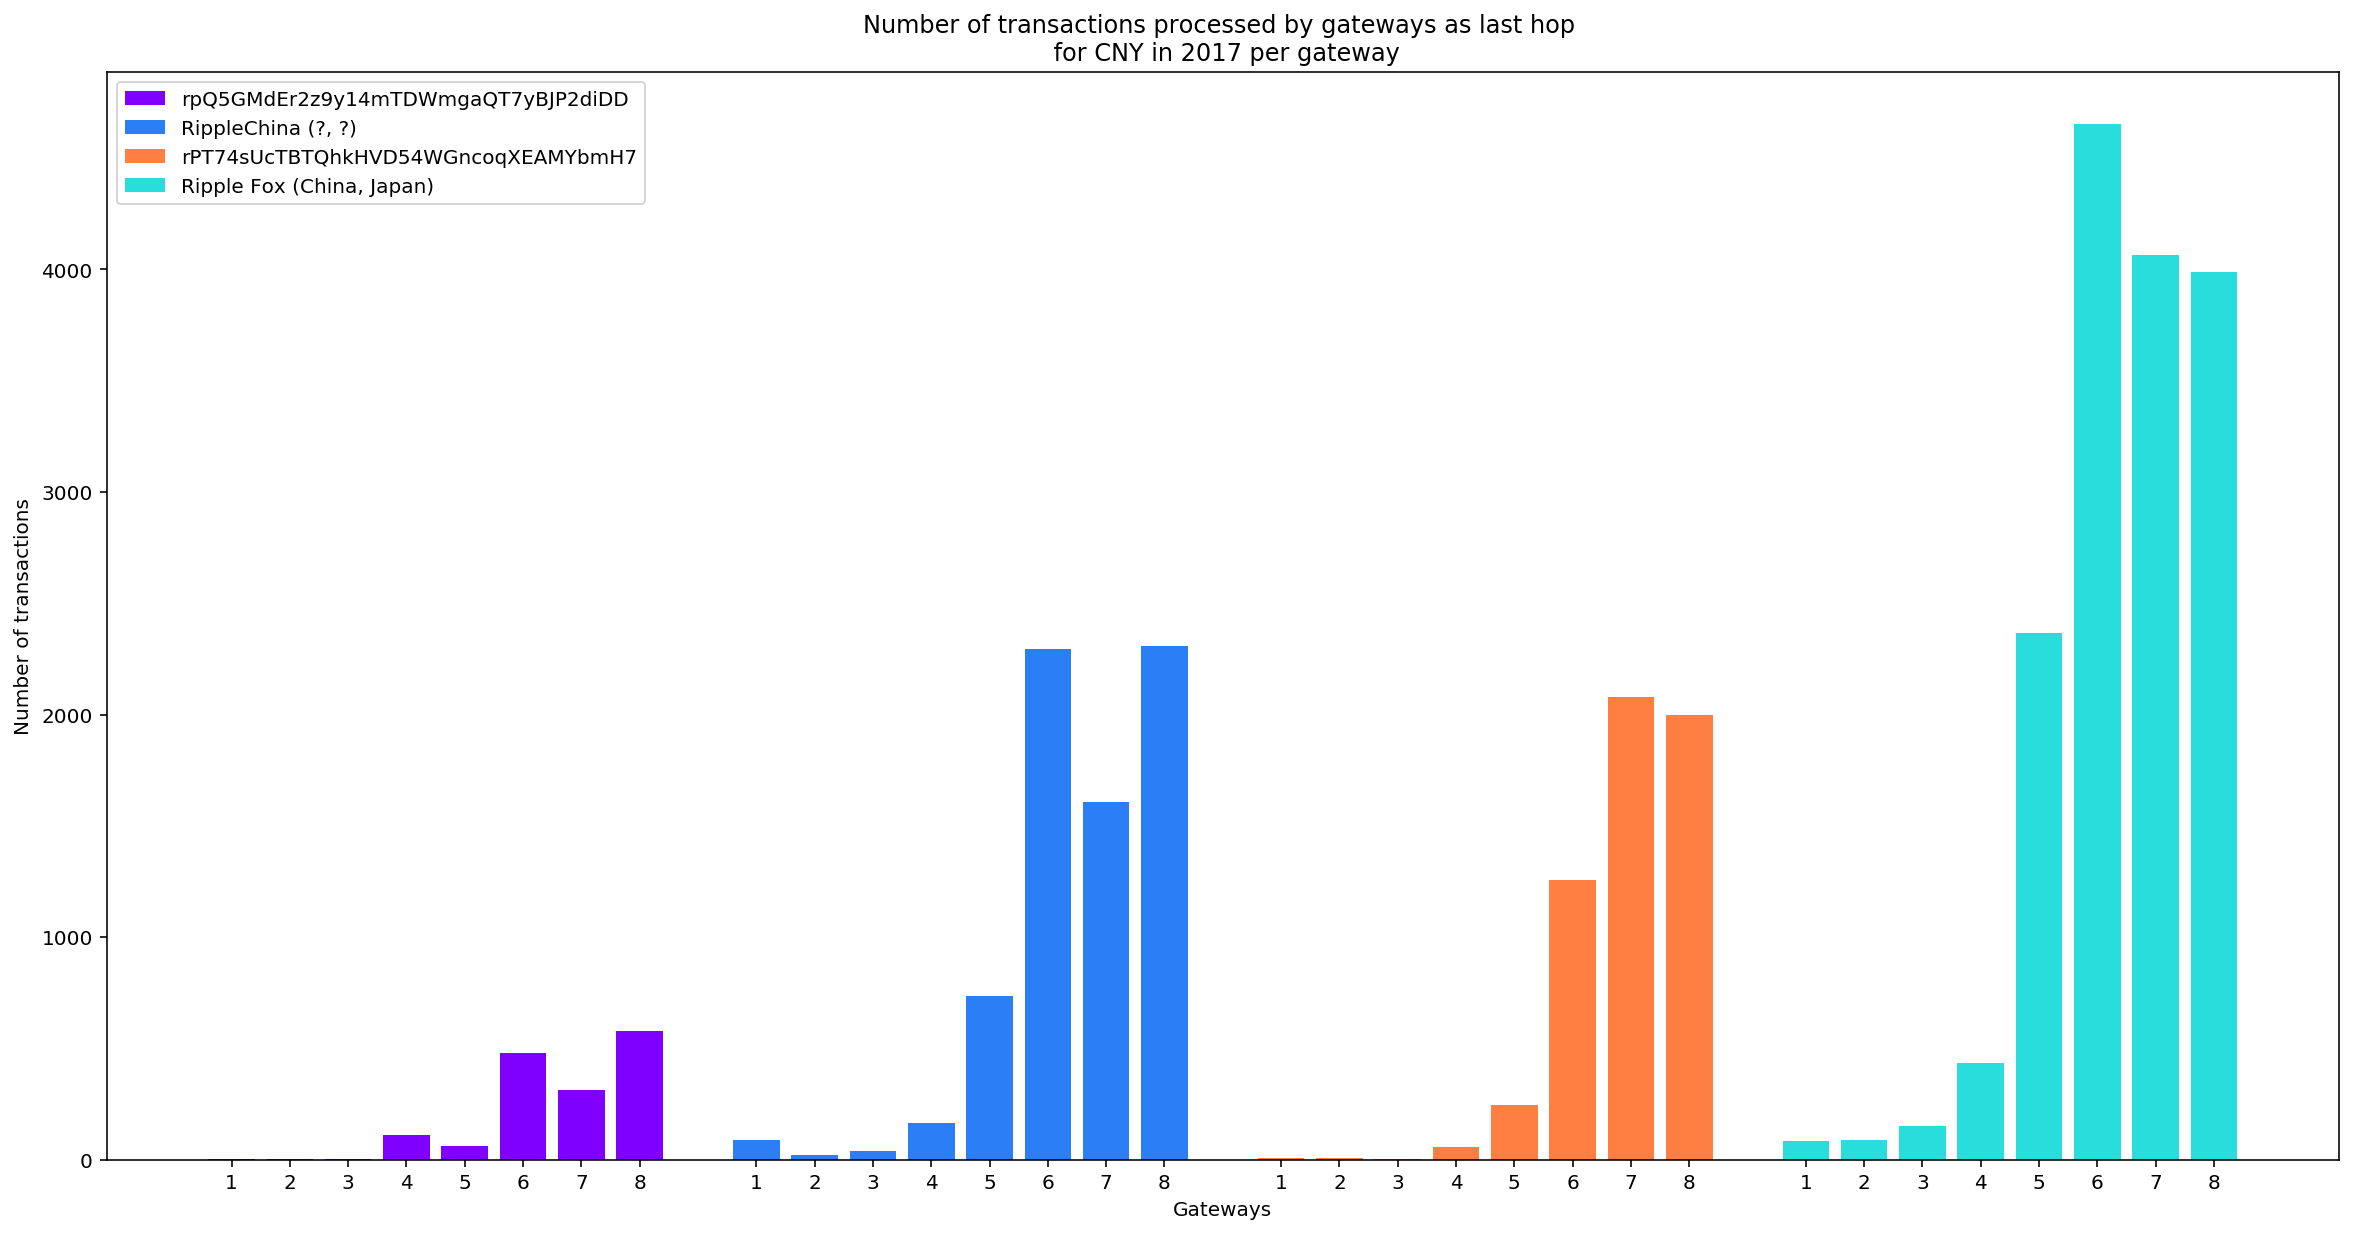

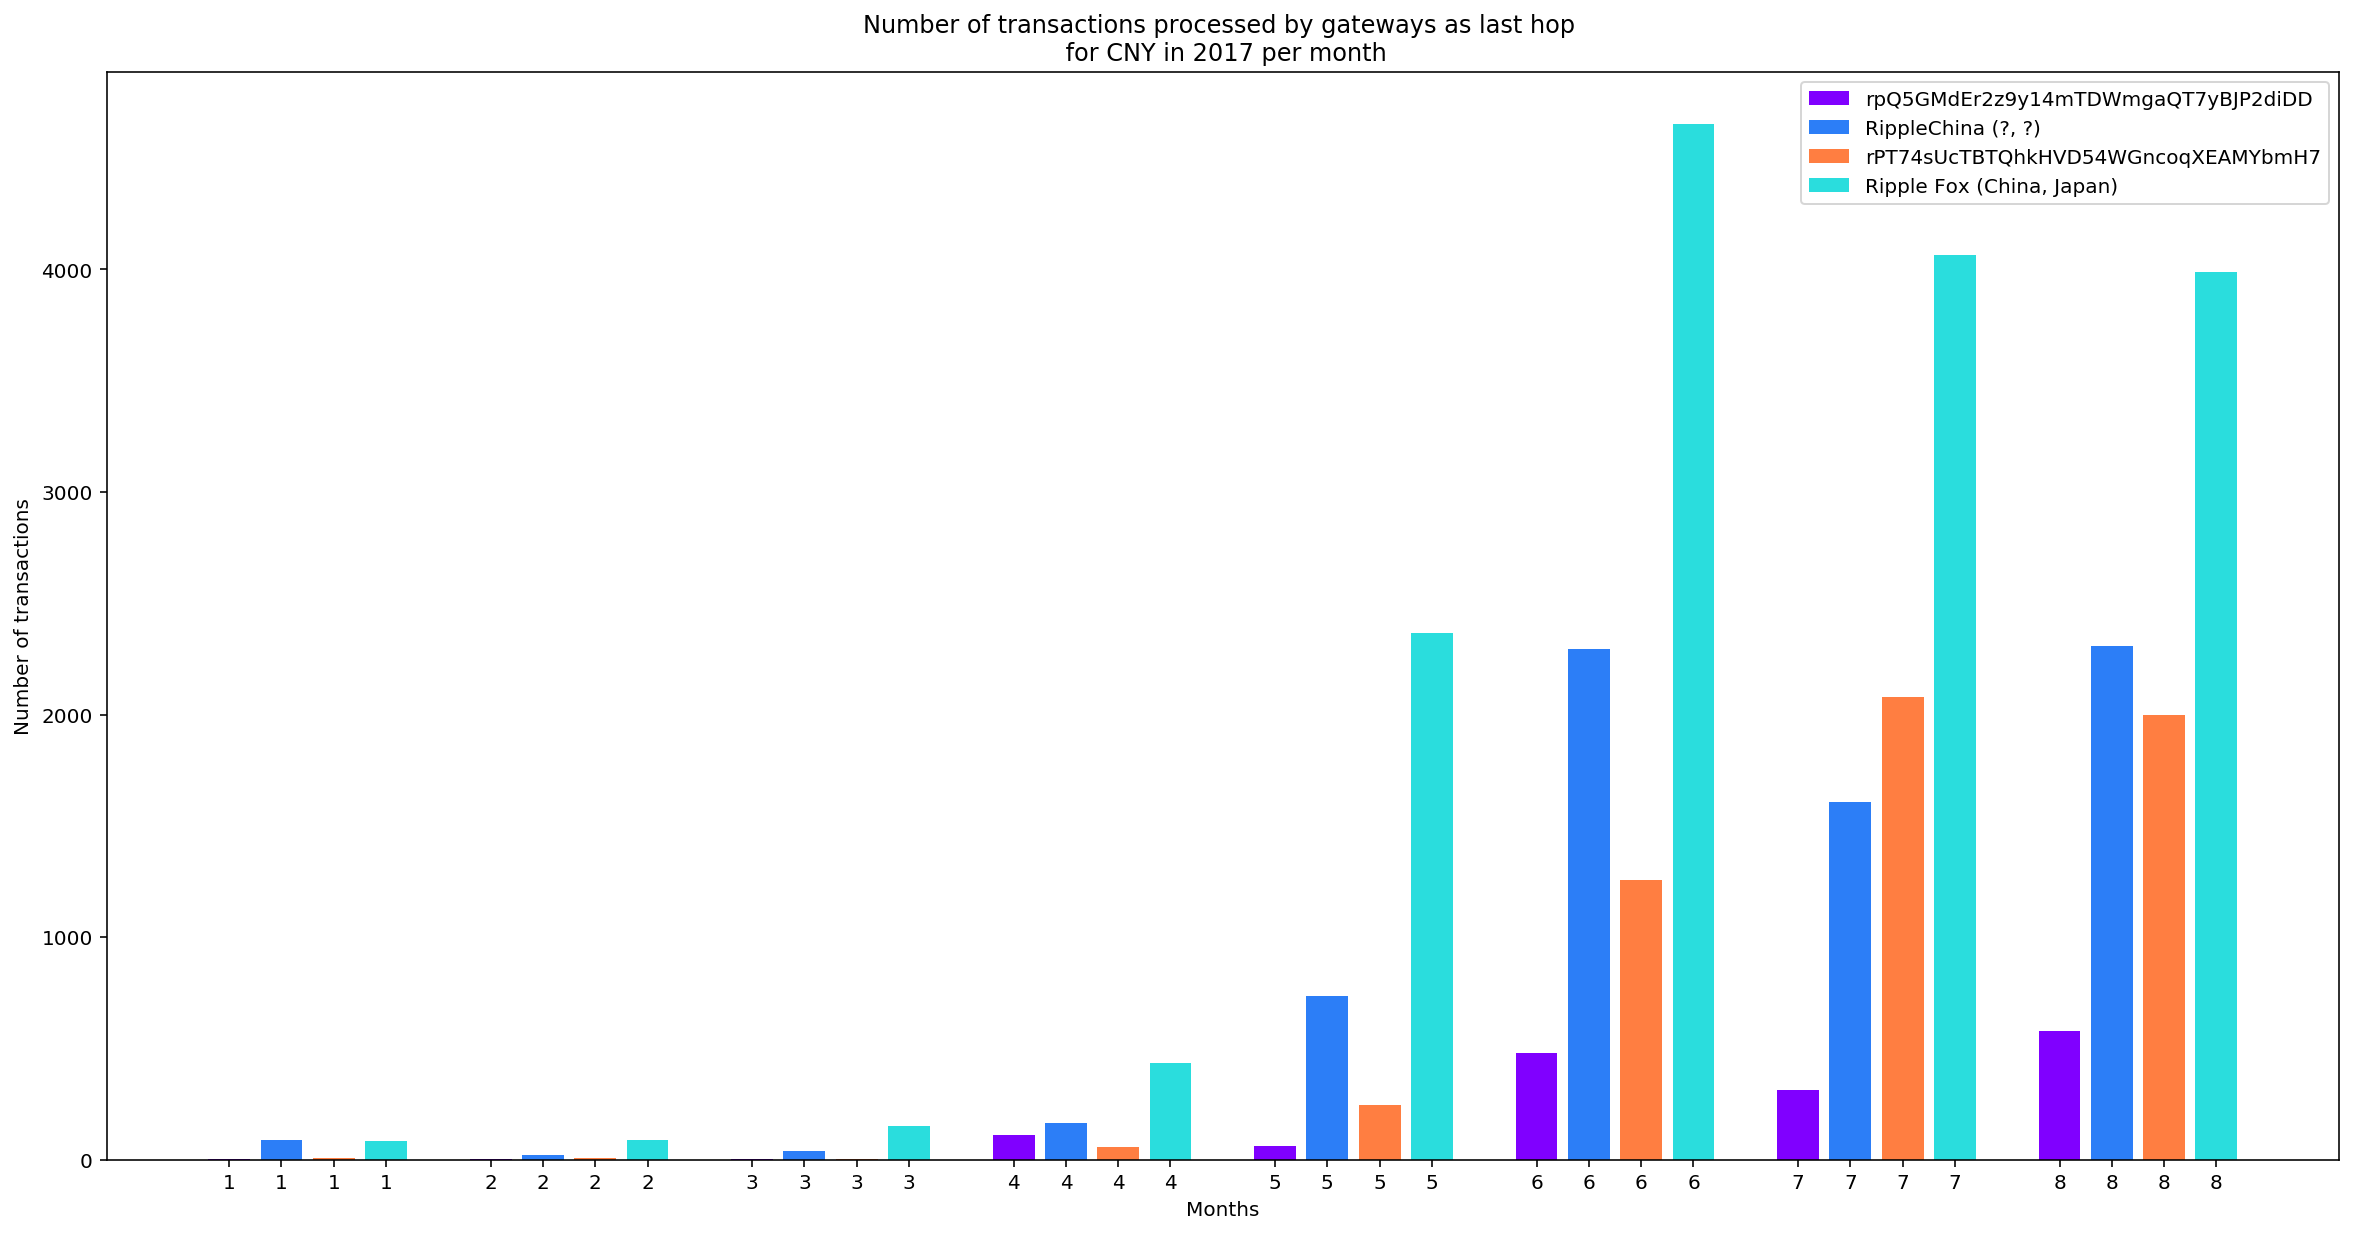

In [47]:
plot_per_gateway(dat_CNY_receiver,'2017','CNY','Number_of_transactions','last_hop',gateways_to_colors)
plot_per_month(dat_CNY_receiver,'2017','CNY','Number_of_transactions','last_hop',gateways_to_colors)

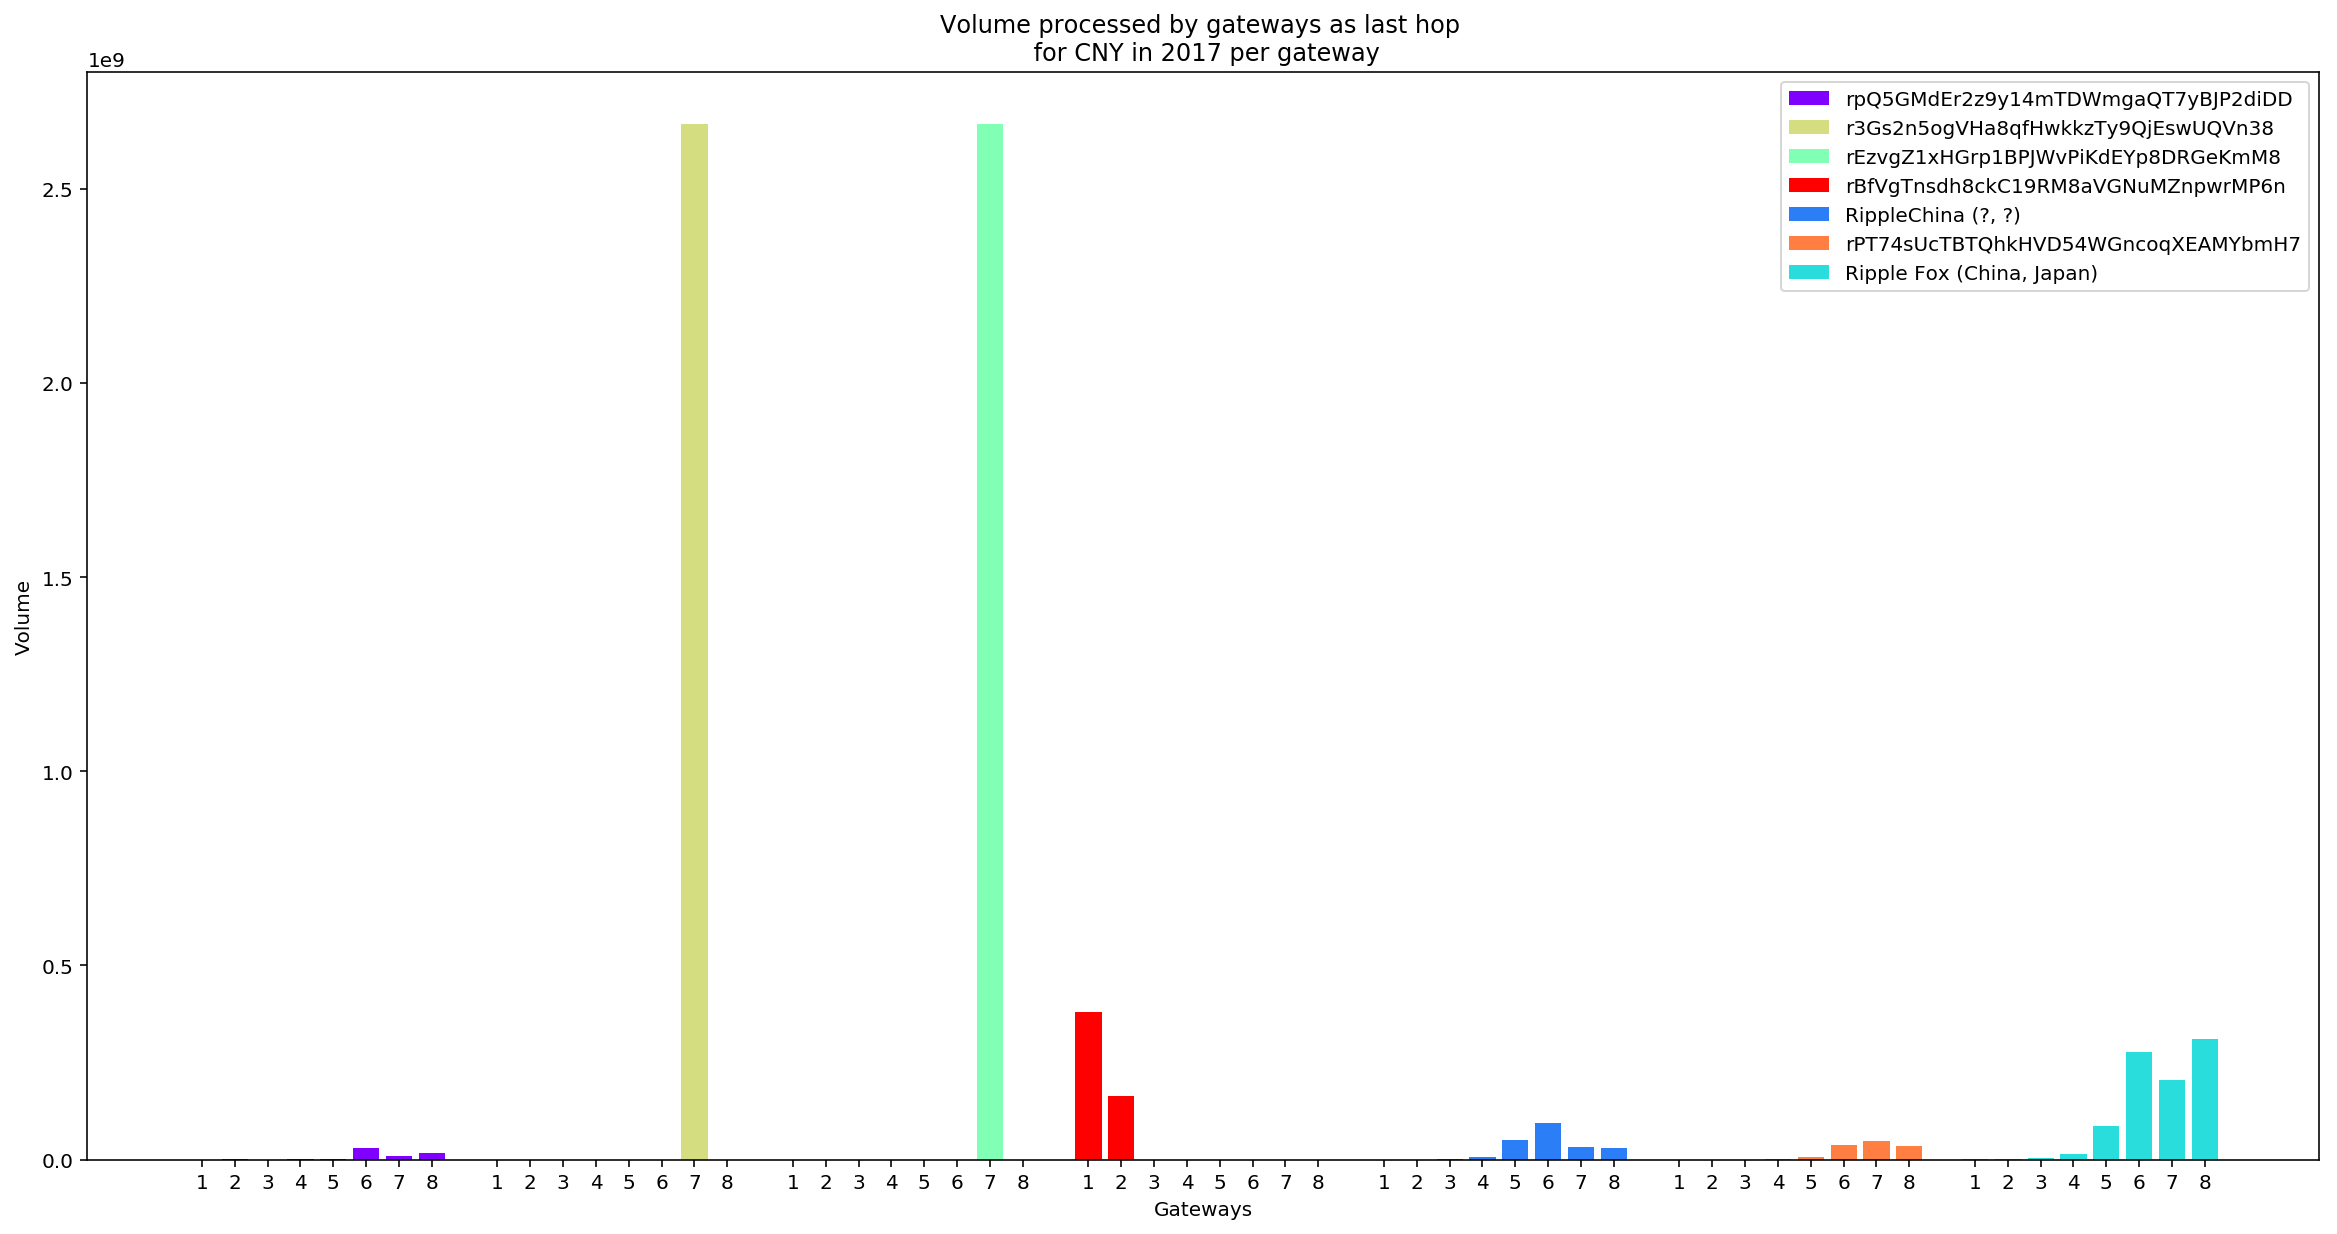

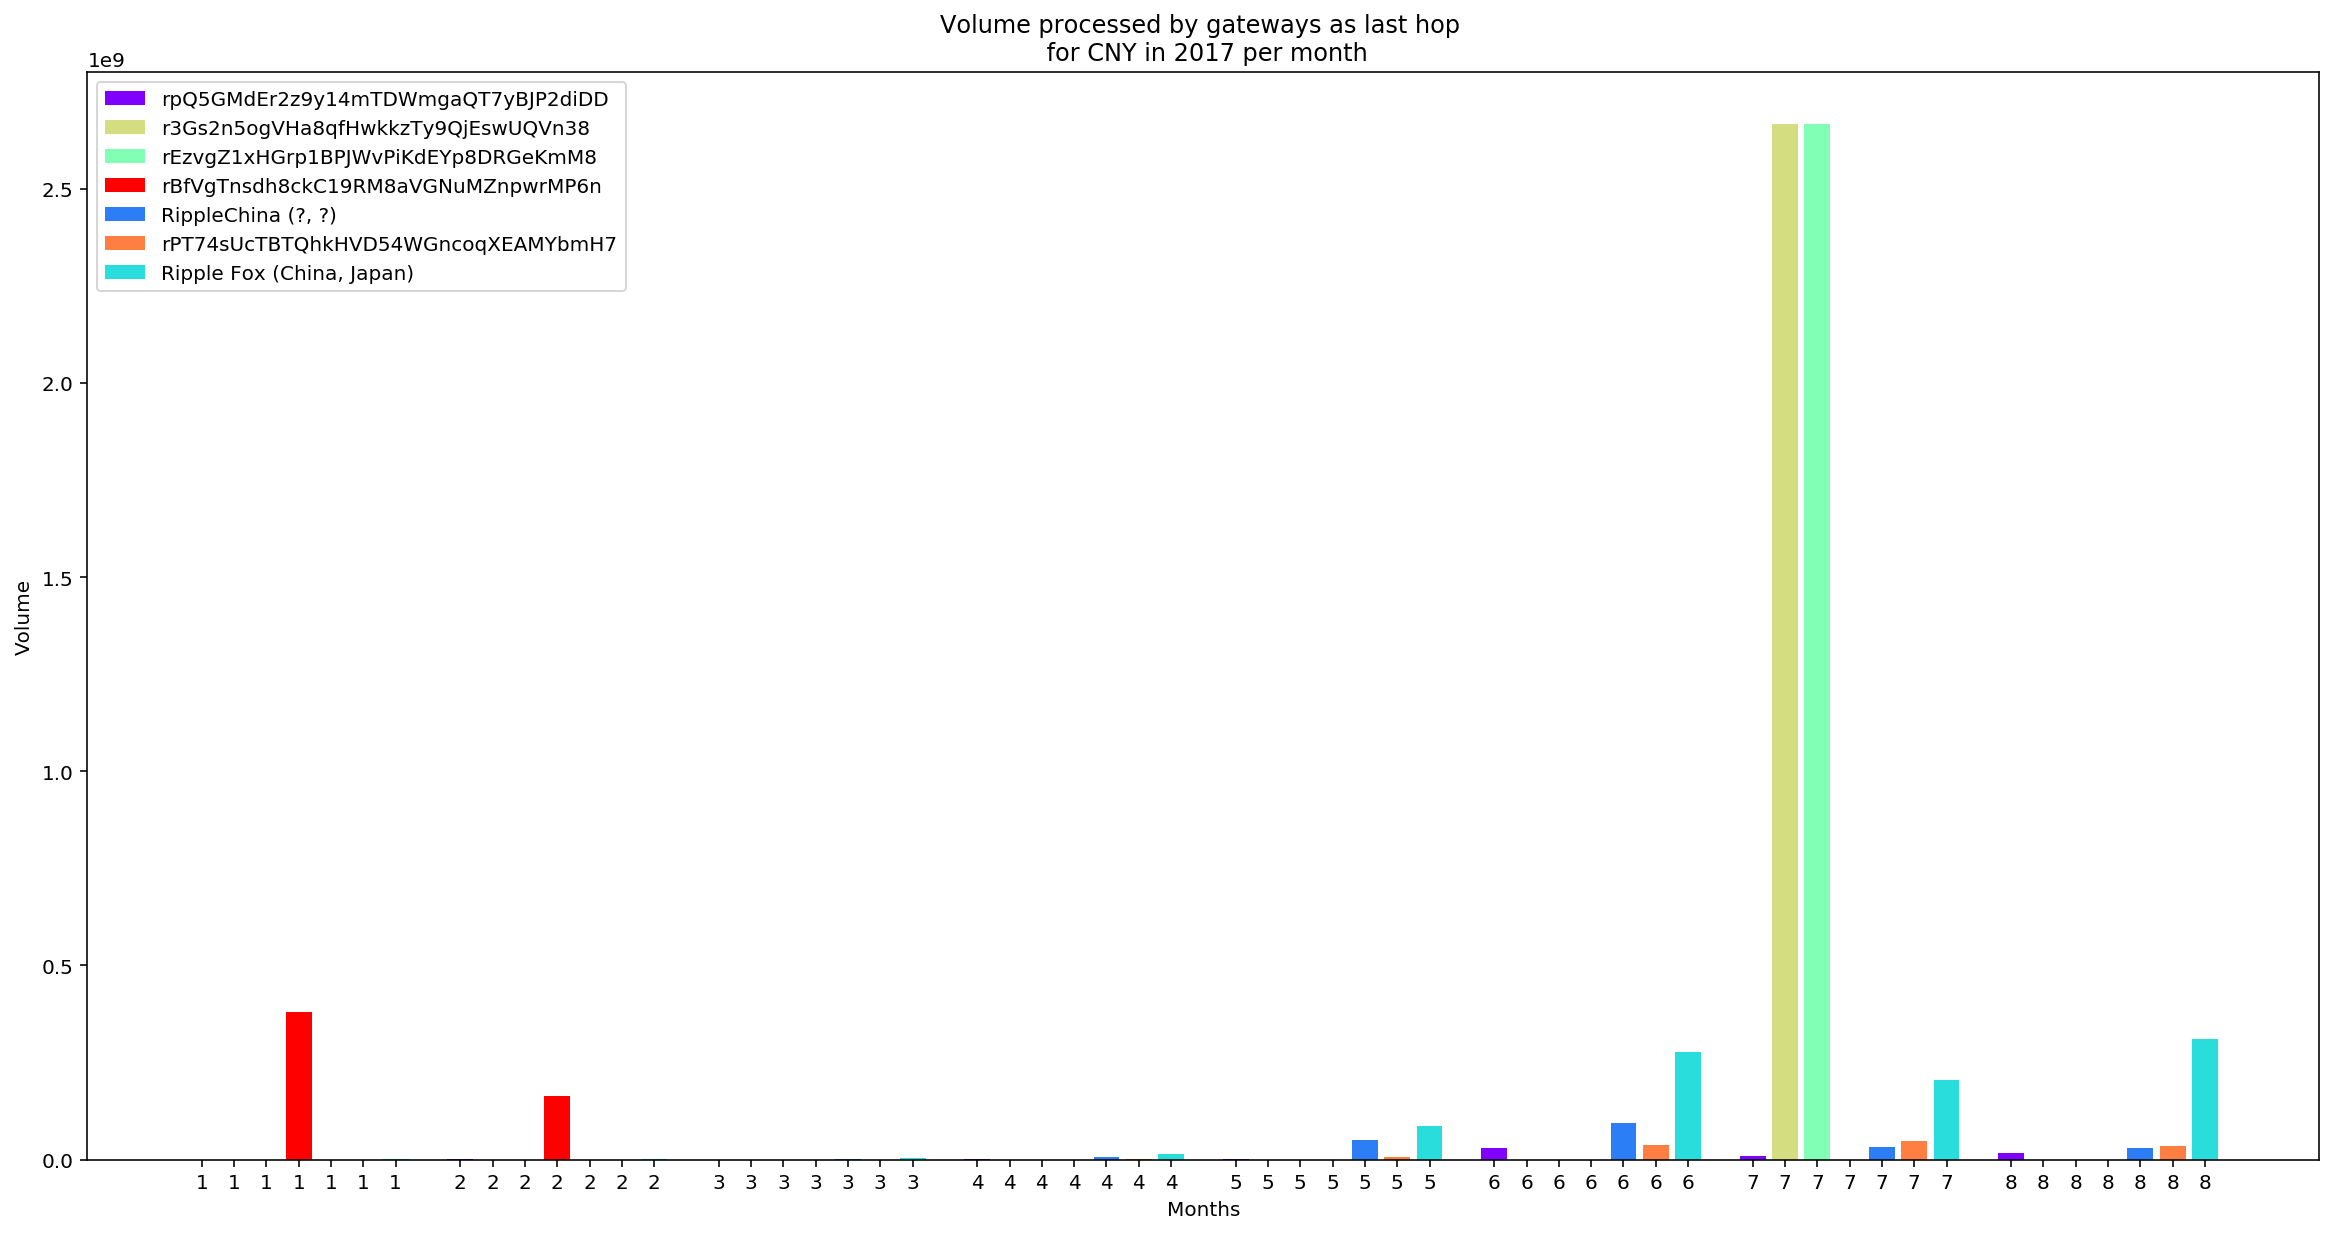

In [48]:
plot_per_gateway(dat_CNY_receiver_volume,'2017','CNY','Volume','last_hop',gateways_to_colors)
plot_per_month(dat_CNY_receiver_volume,'2017','CNY','Volume','last_hop',gateways_to_colors)

##### JPY

In [49]:
dat_JPY_sender = process('2017','JPY',result_sender)
dat_JPY_sender_volume = process('2017','JPY',result_sender_volume)
dat_JPY_receiver = process('2017','JPY',result_receiver)
dat_JPY_receiver_volume = process('2017','JPY',result_receiver_volume)

In [50]:
all_gateways = set(dat_JPY_sender.keys()) | set(dat_JPY_sender_volume.keys()) | set(dat_JPY_receiver.keys()) | set(dat_JPY_receiver_volume.keys())
# define the colormap
colormap = plt.cm.rainbow
# extract all colors from the .viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(all_gateways))]

gateways_to_colors = {}
index_color = 0
for gateway in all_gateways:
    gateways_to_colors[gateway] = colors[index_color]
    index_color+=1

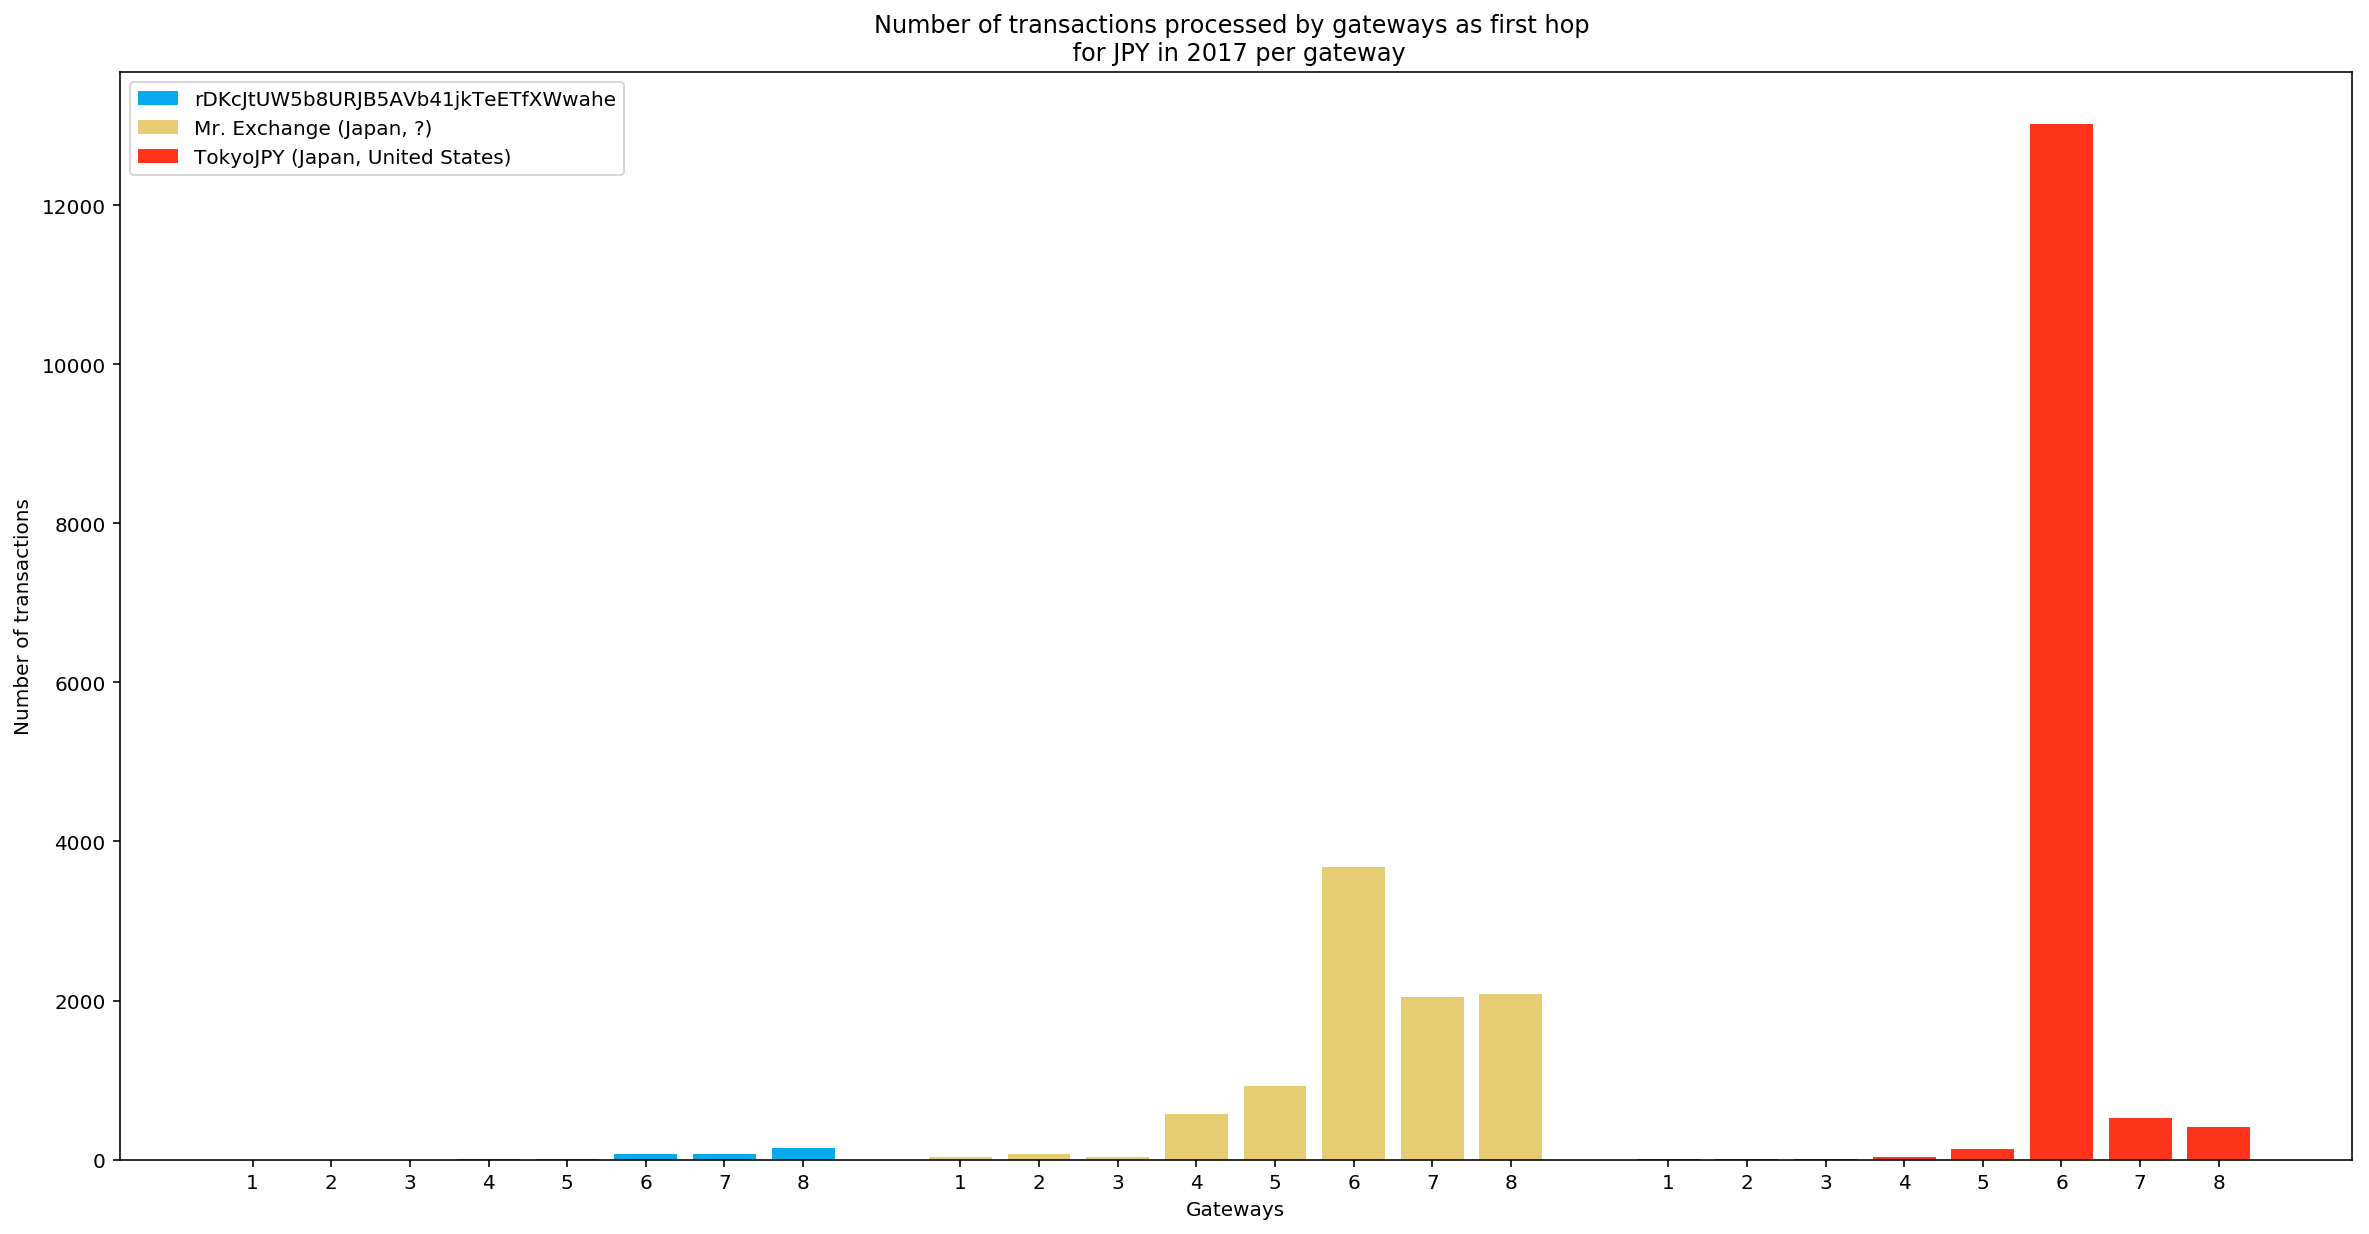

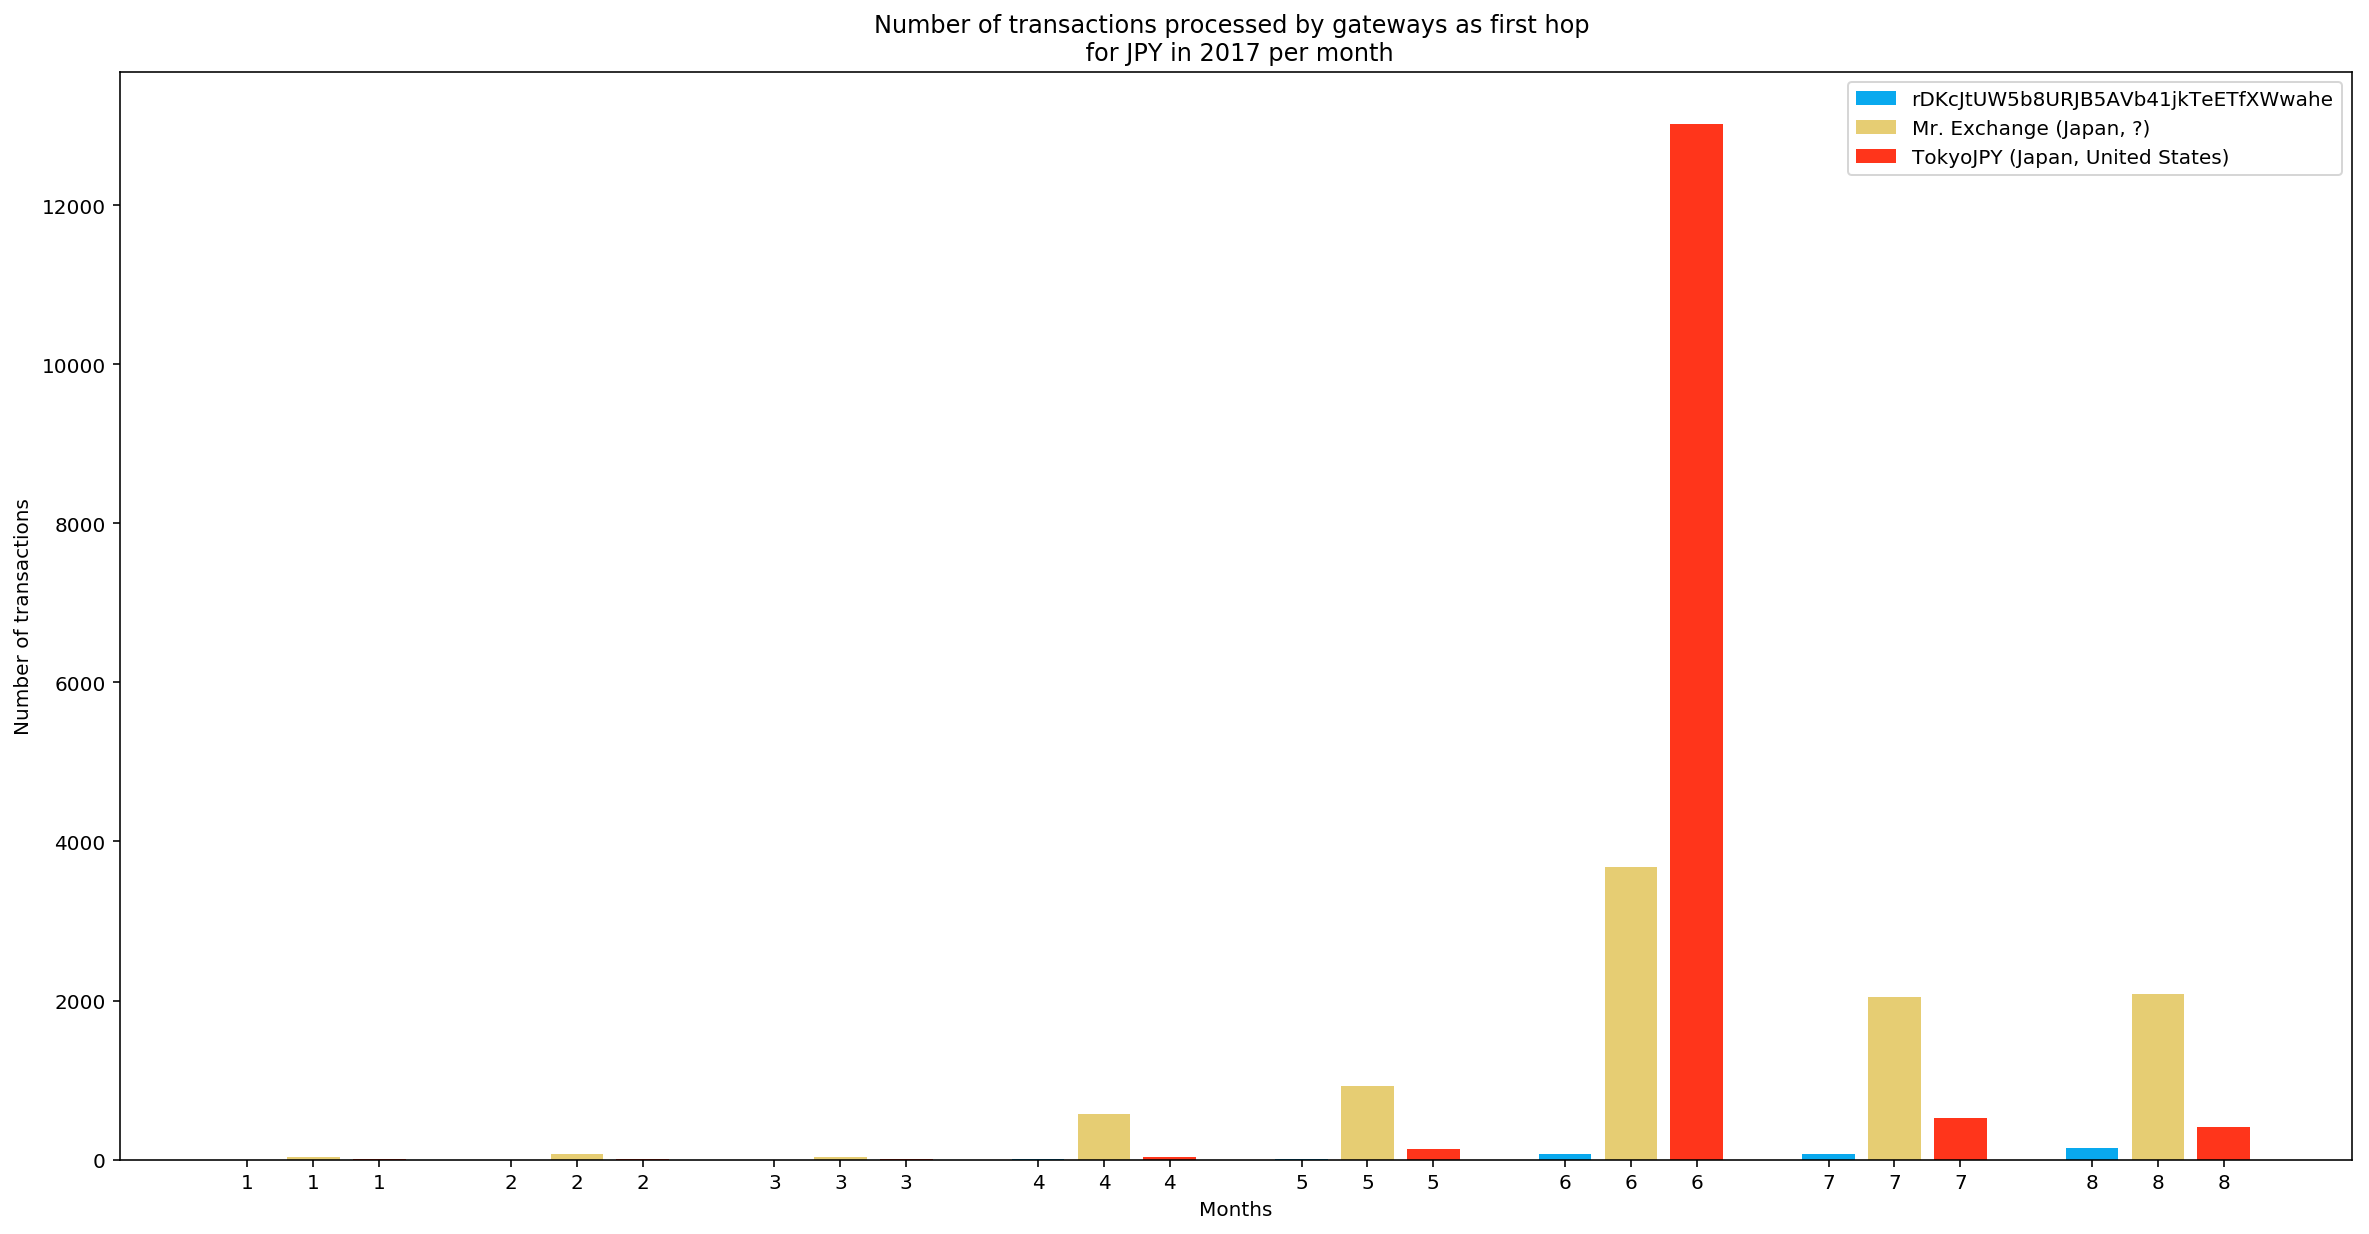

In [51]:
plot_per_gateway(dat_JPY_sender,'2017','JPY','Number_of_transactions','first_hop',gateways_to_colors)
plot_per_month(dat_JPY_sender,'2017','JPY','Number_of_transactions','first_hop',gateways_to_colors)

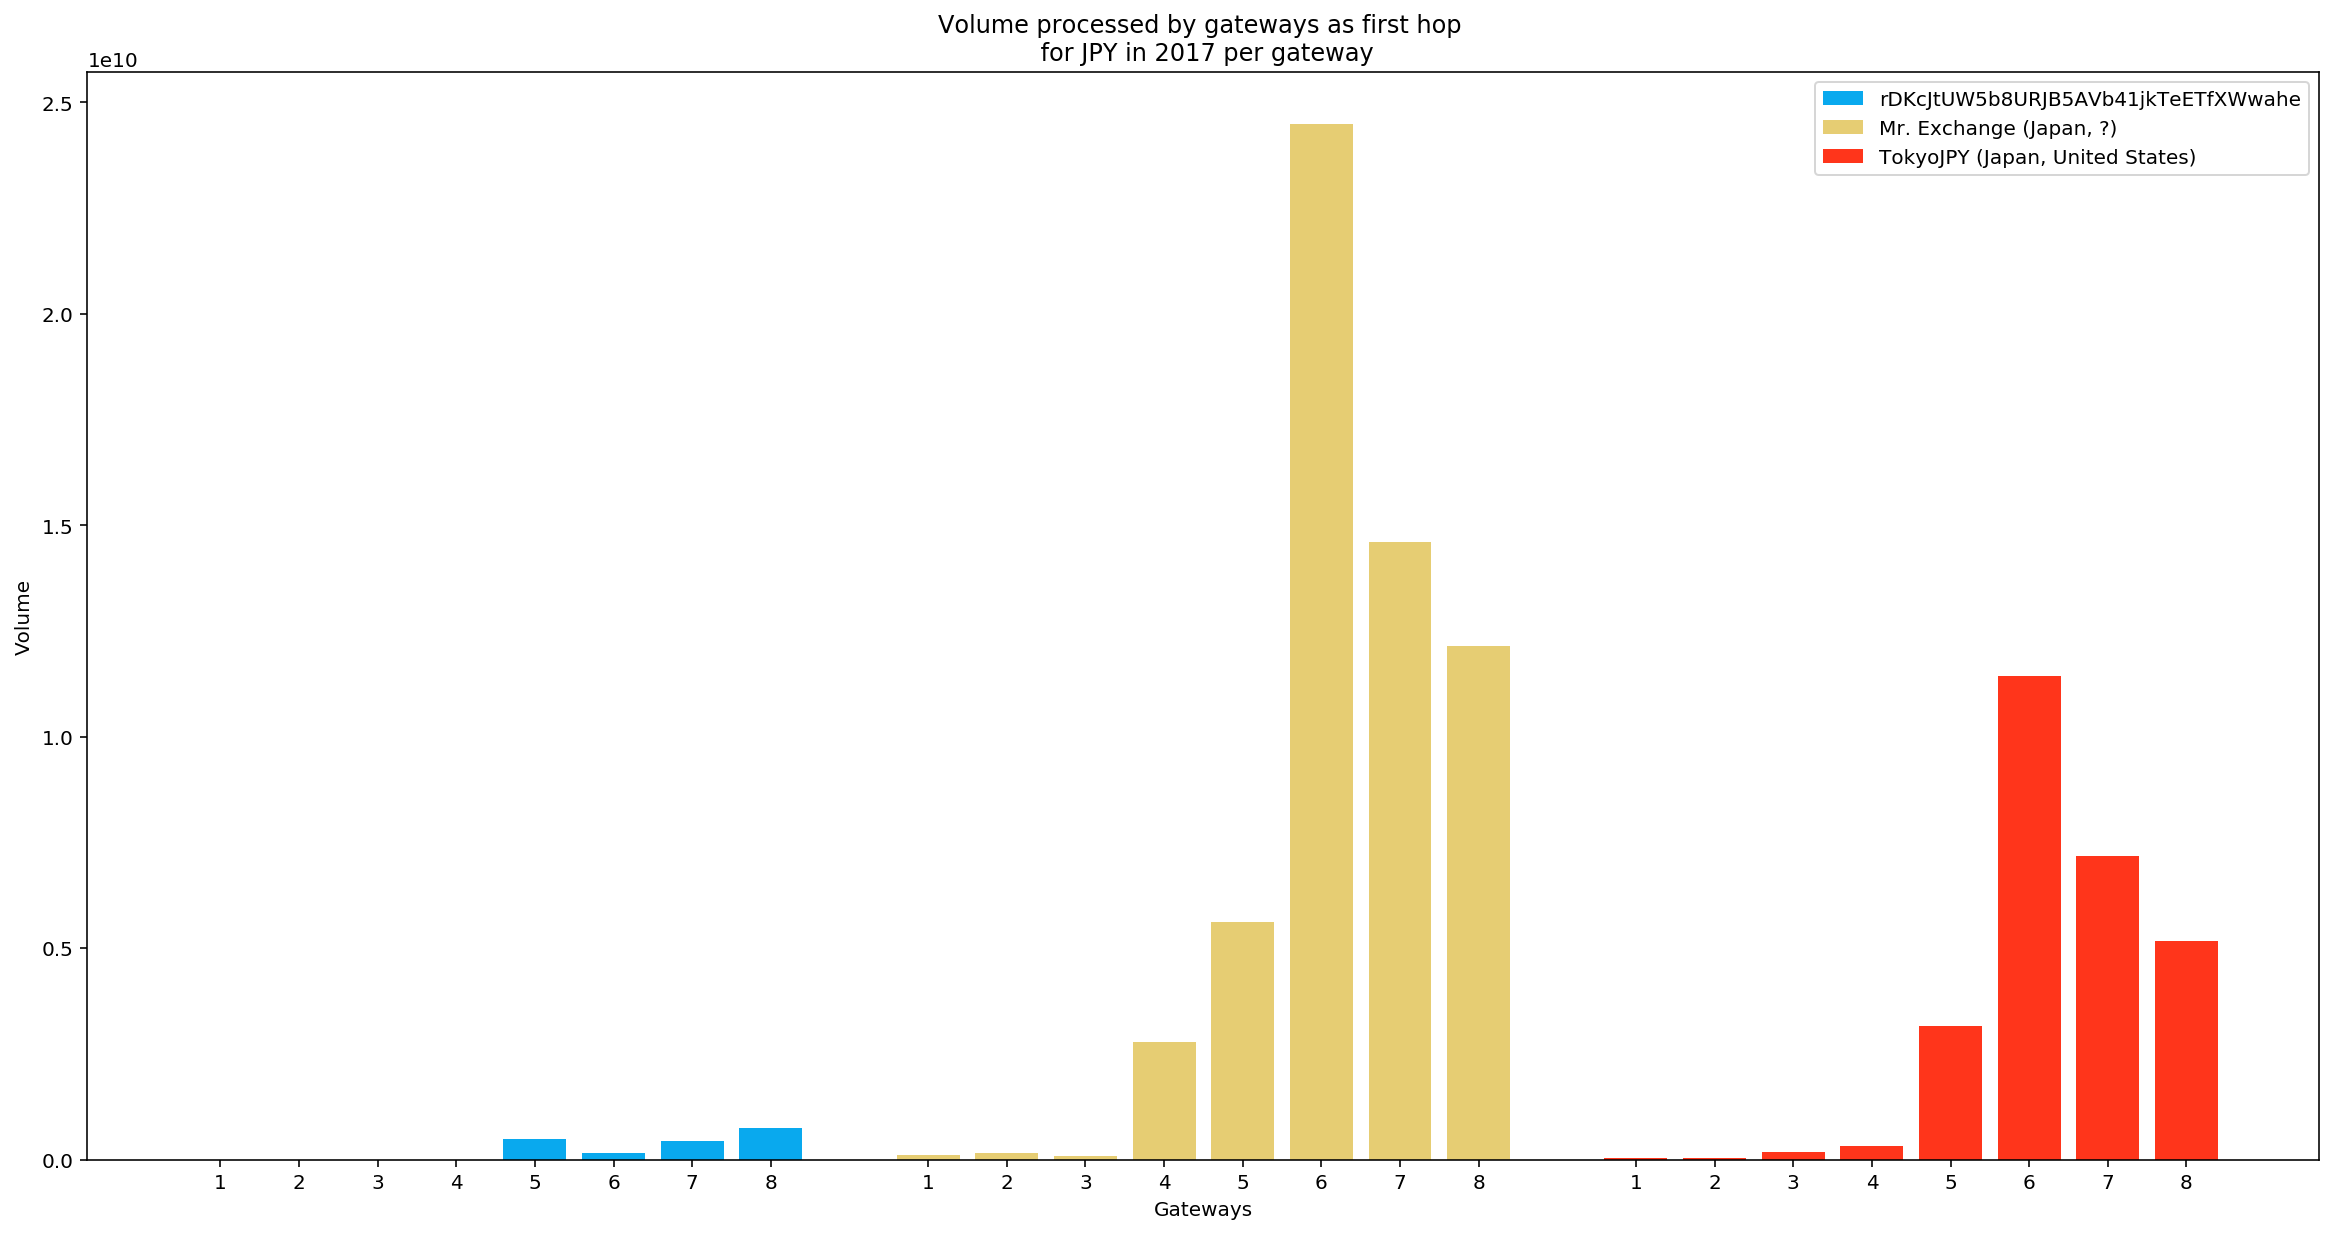

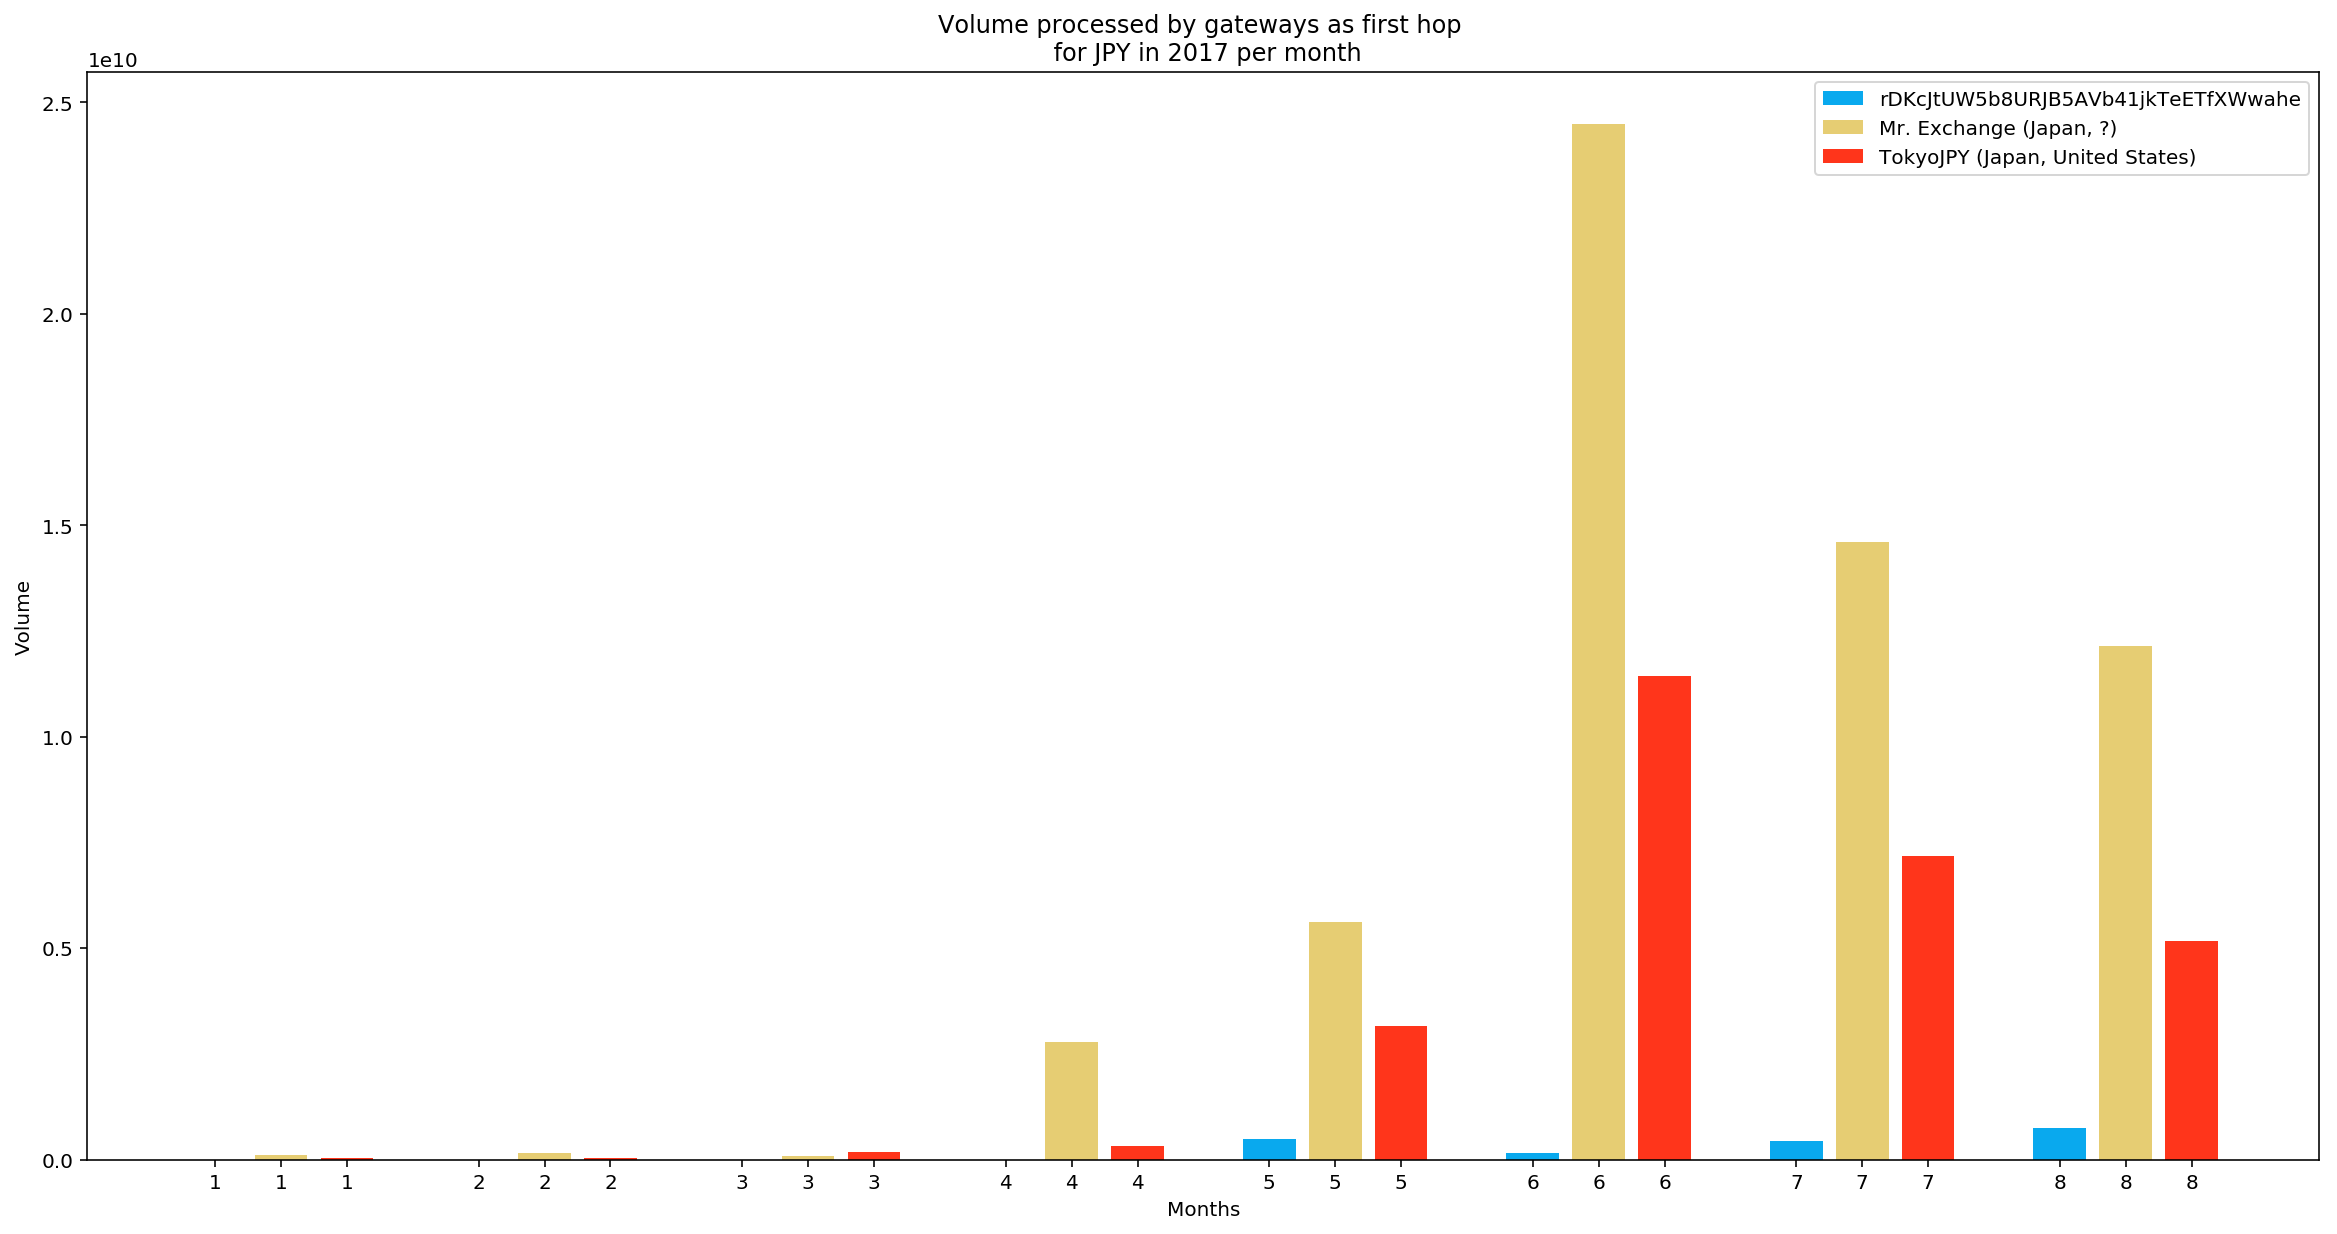

In [52]:
plot_per_gateway(dat_JPY_sender_volume,'2017','JPY','Volume','first_hop',gateways_to_colors)
plot_per_month(dat_JPY_sender_volume,'2017','JPY','Volume','first_hop',gateways_to_colors)

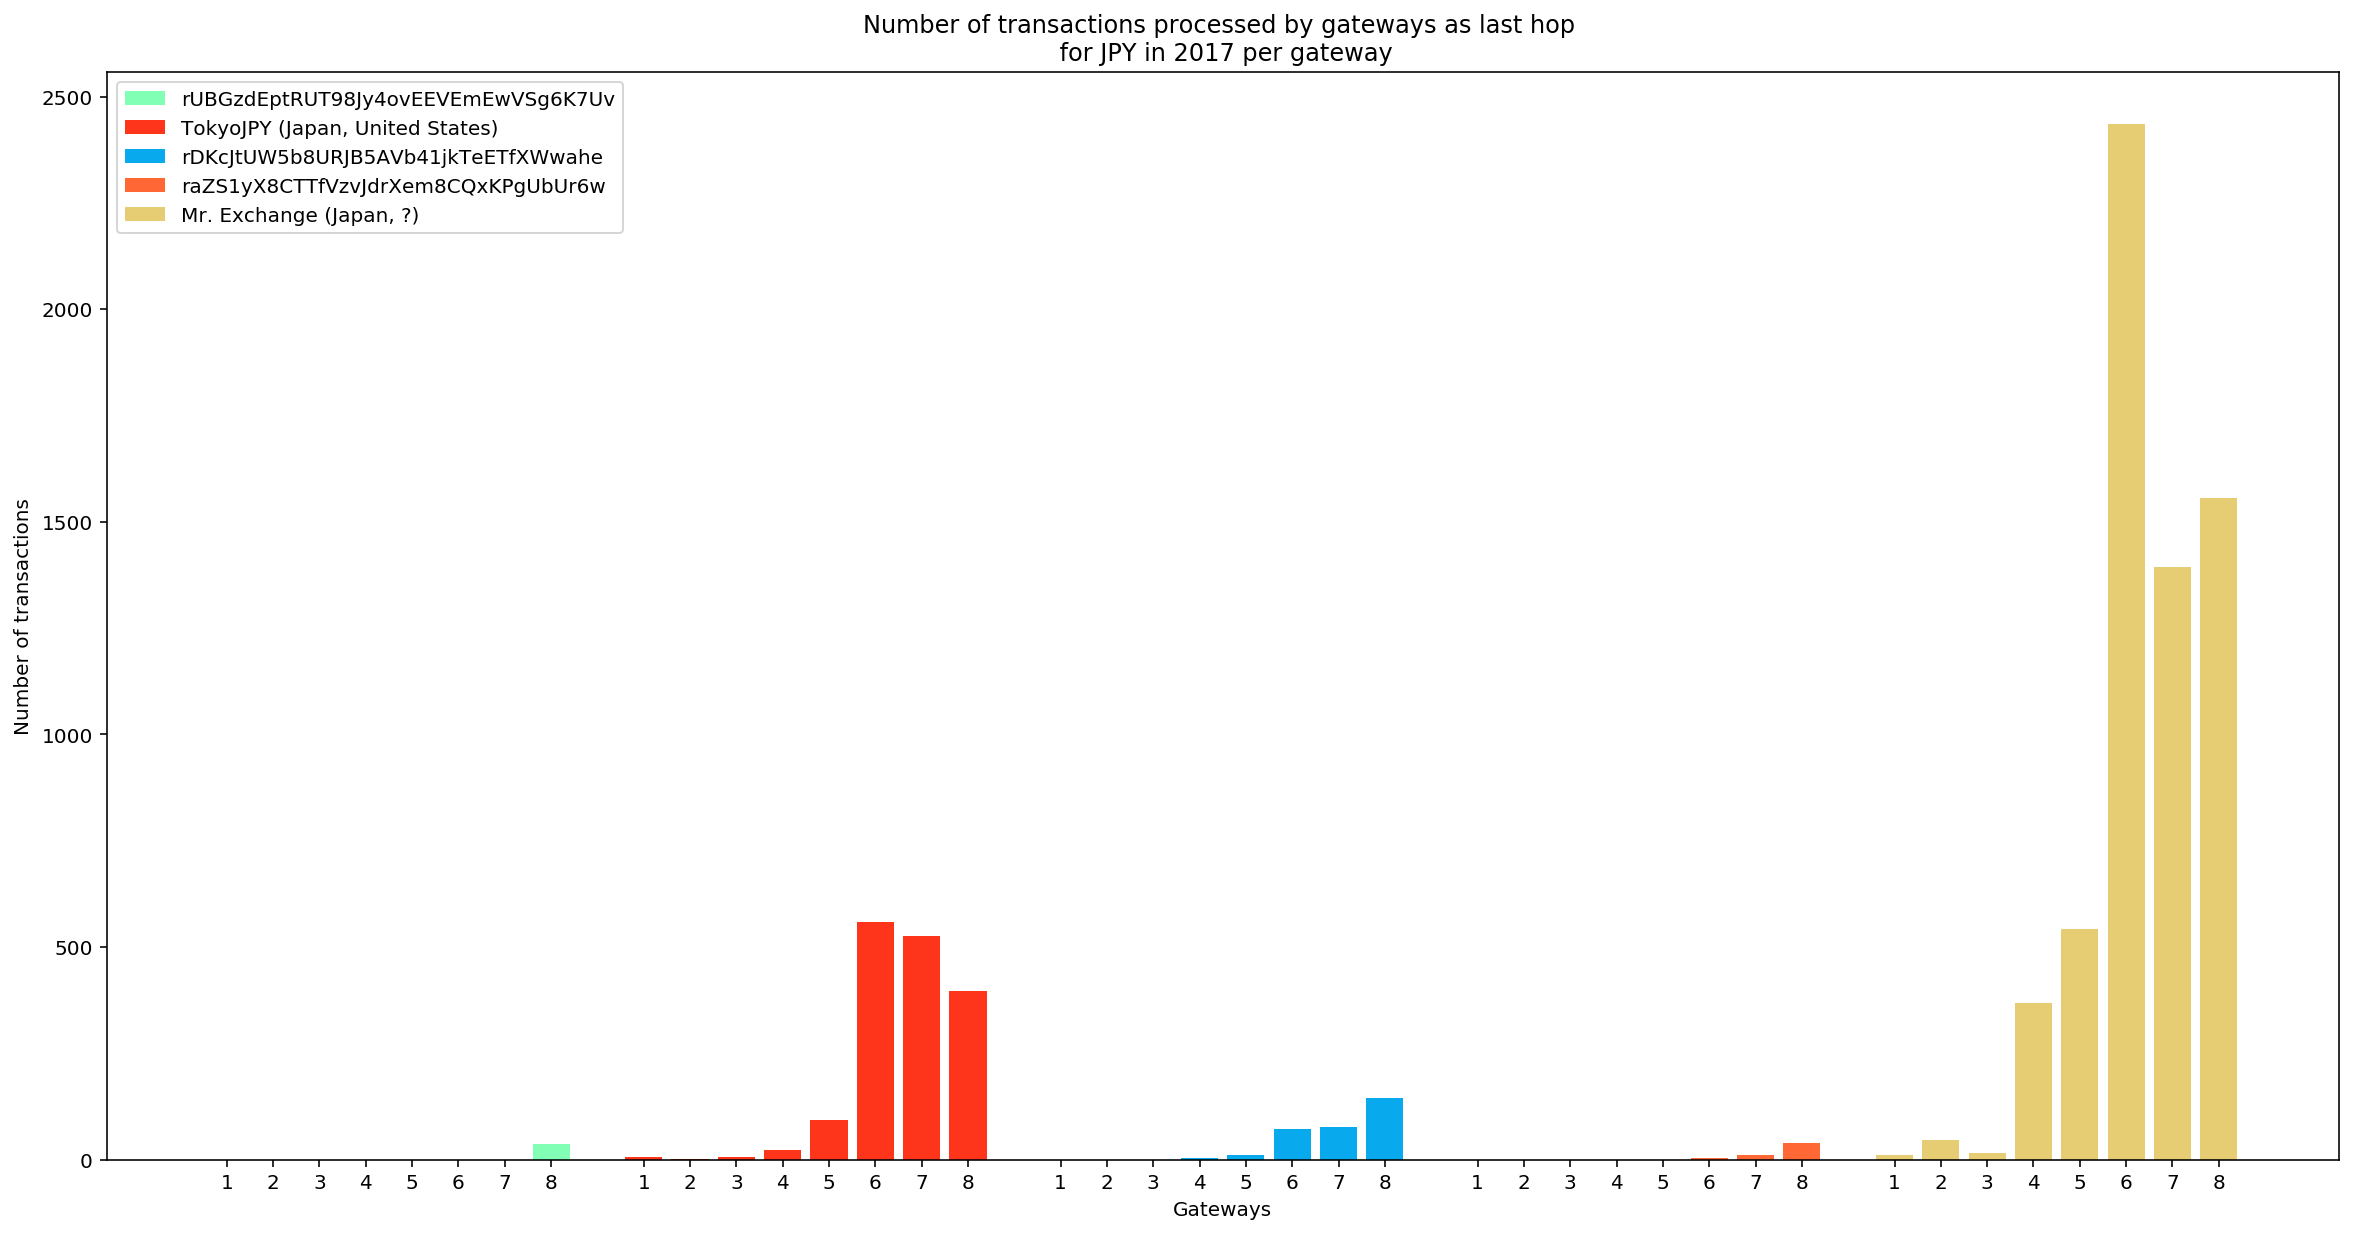

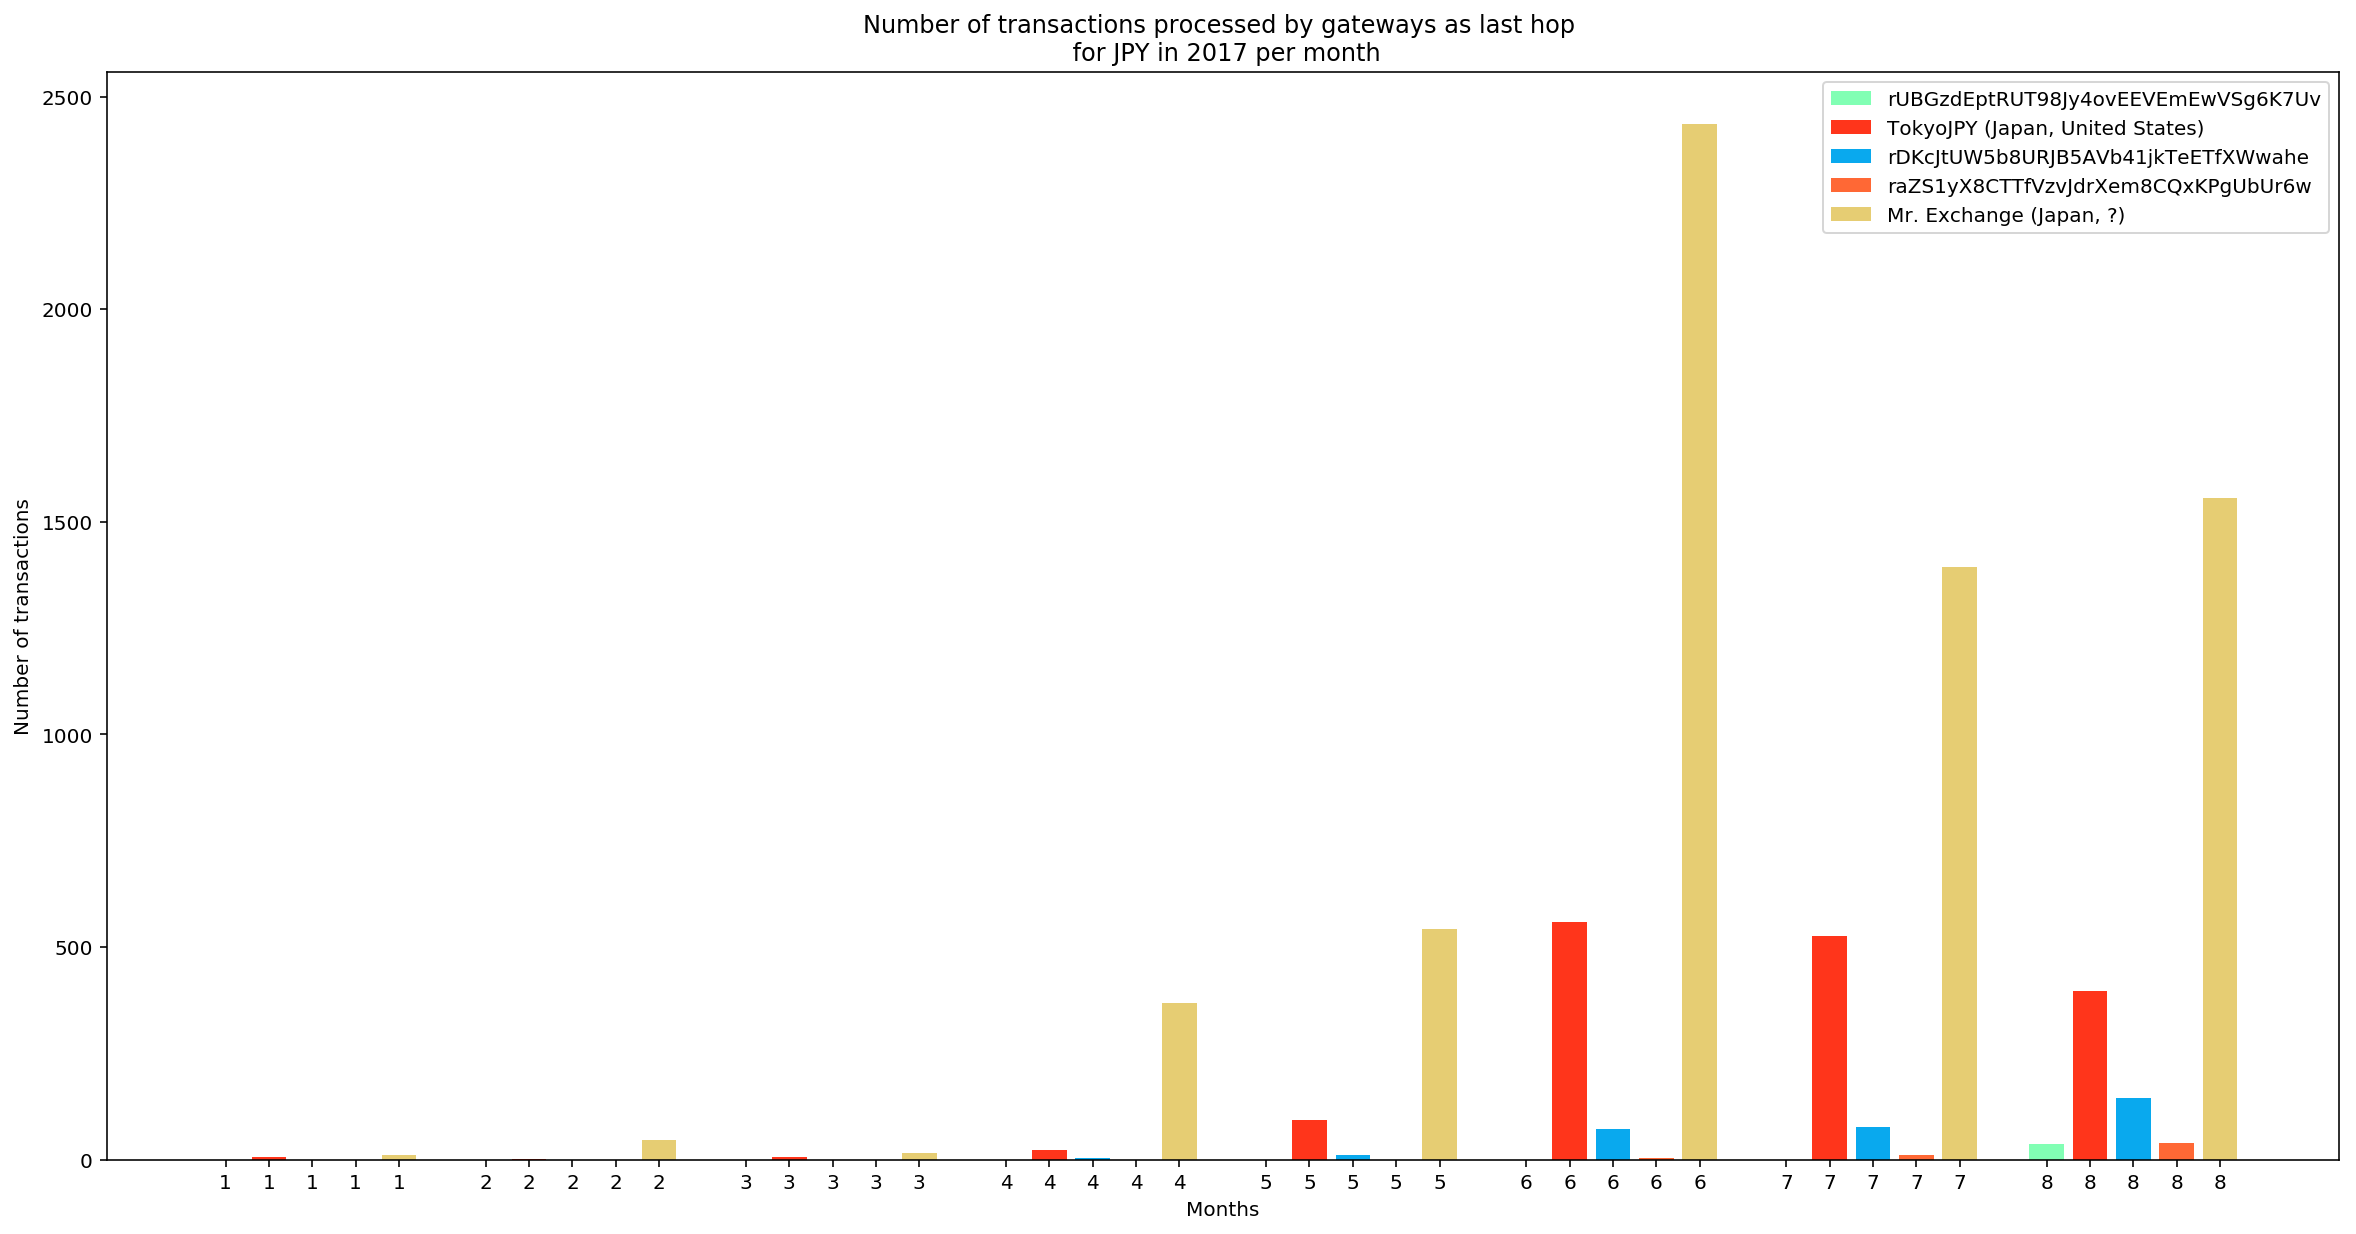

In [53]:
plot_per_gateway(dat_JPY_receiver,'2017','JPY','Number_of_transactions','last_hop',gateways_to_colors)
plot_per_month(dat_JPY_receiver,'2017','JPY','Number_of_transactions','last_hop',gateways_to_colors)

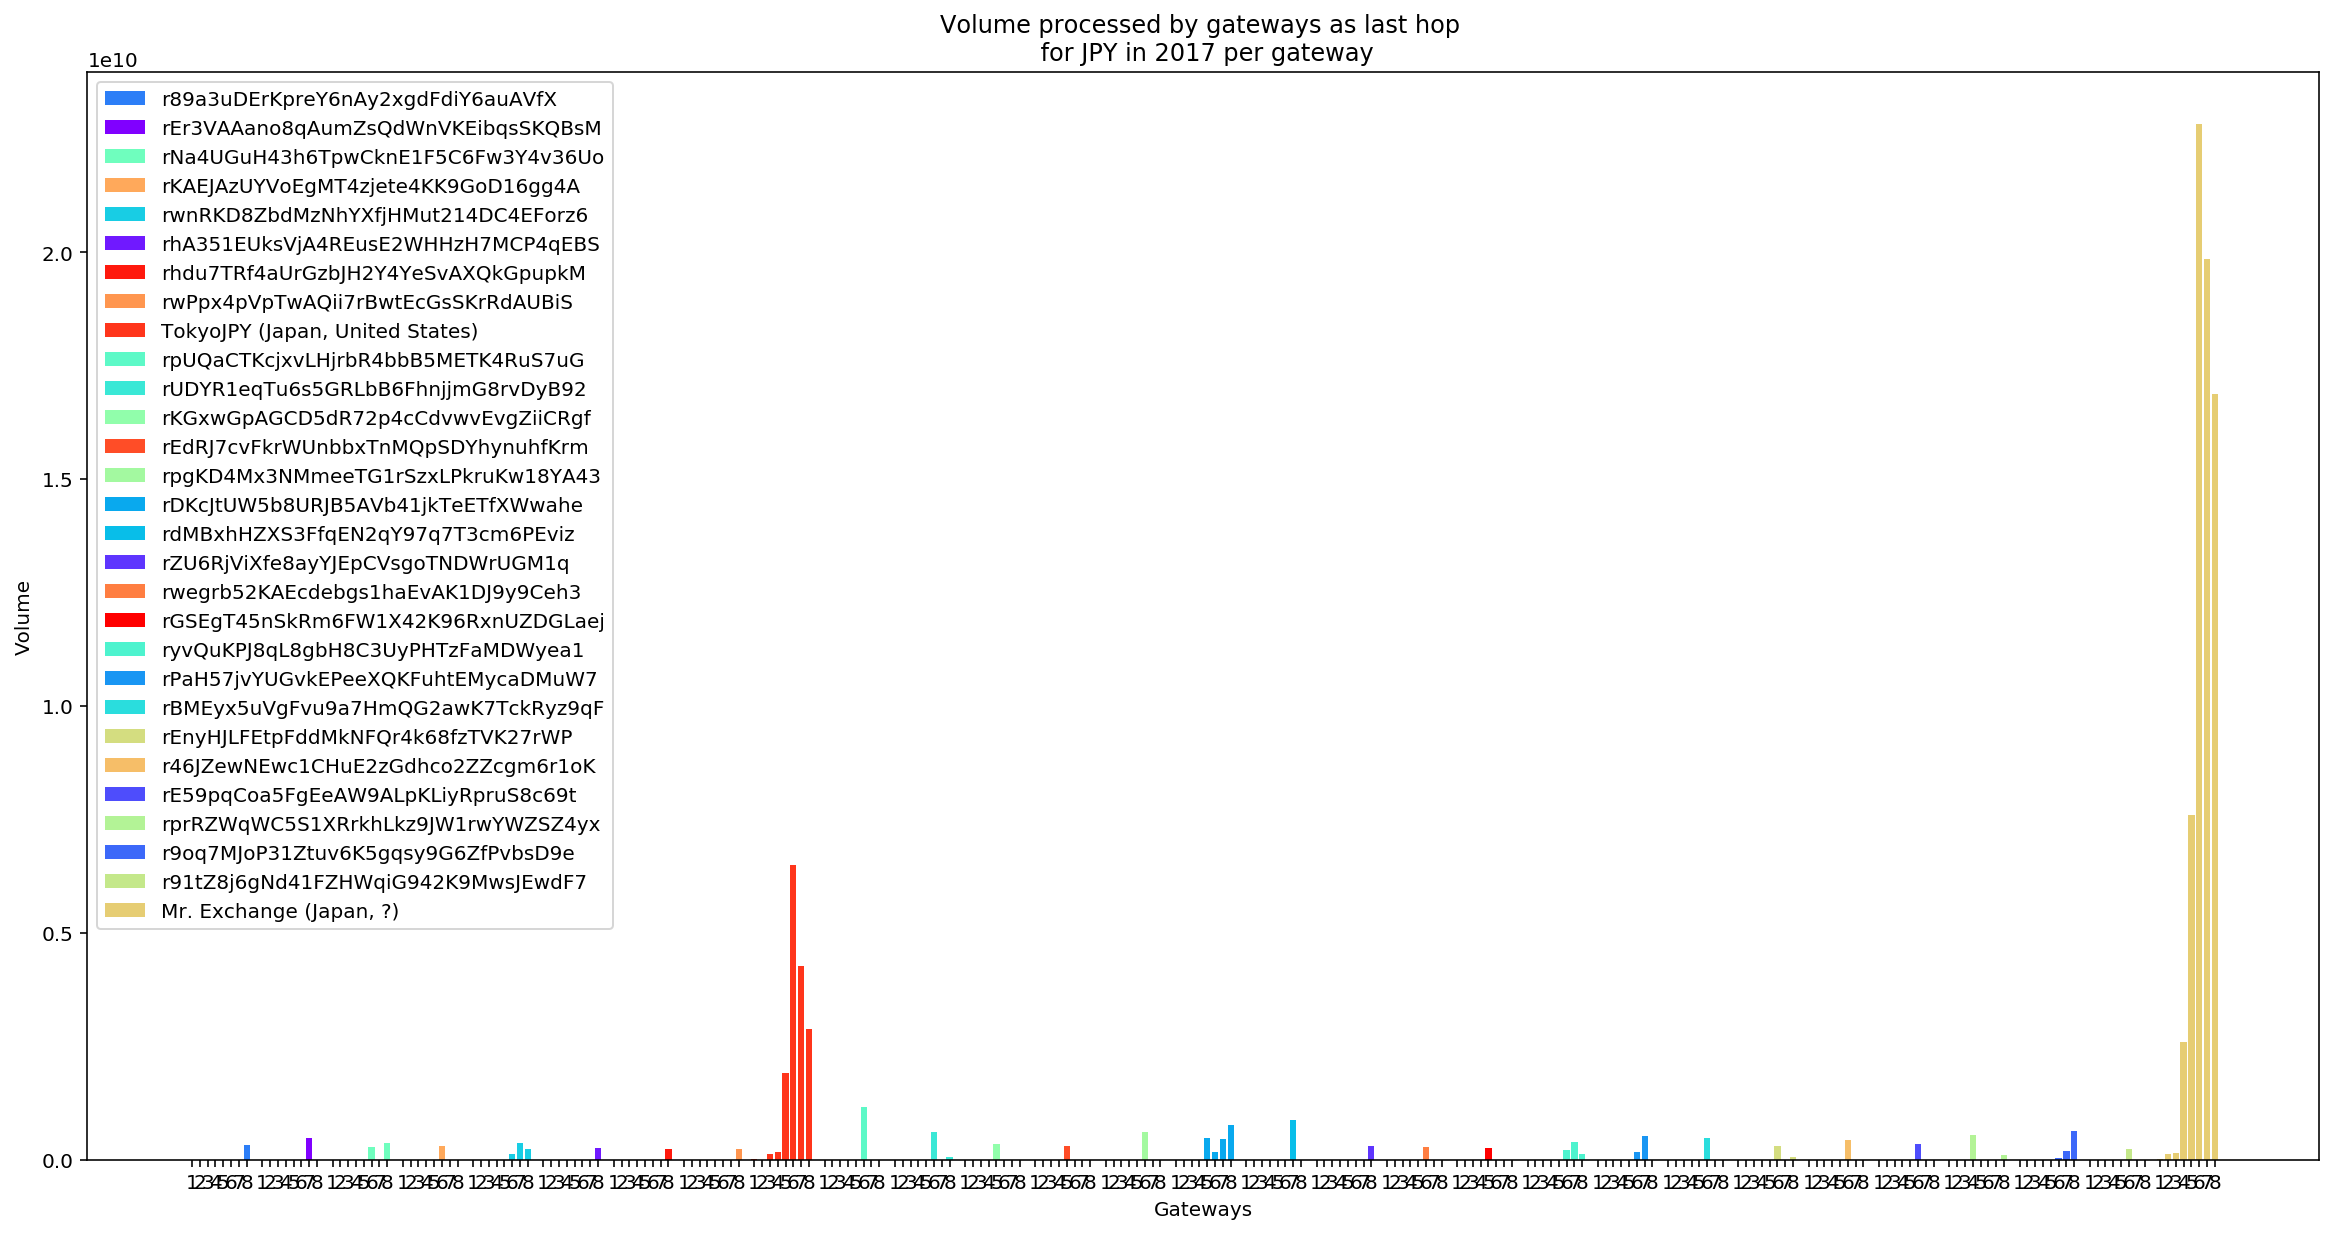

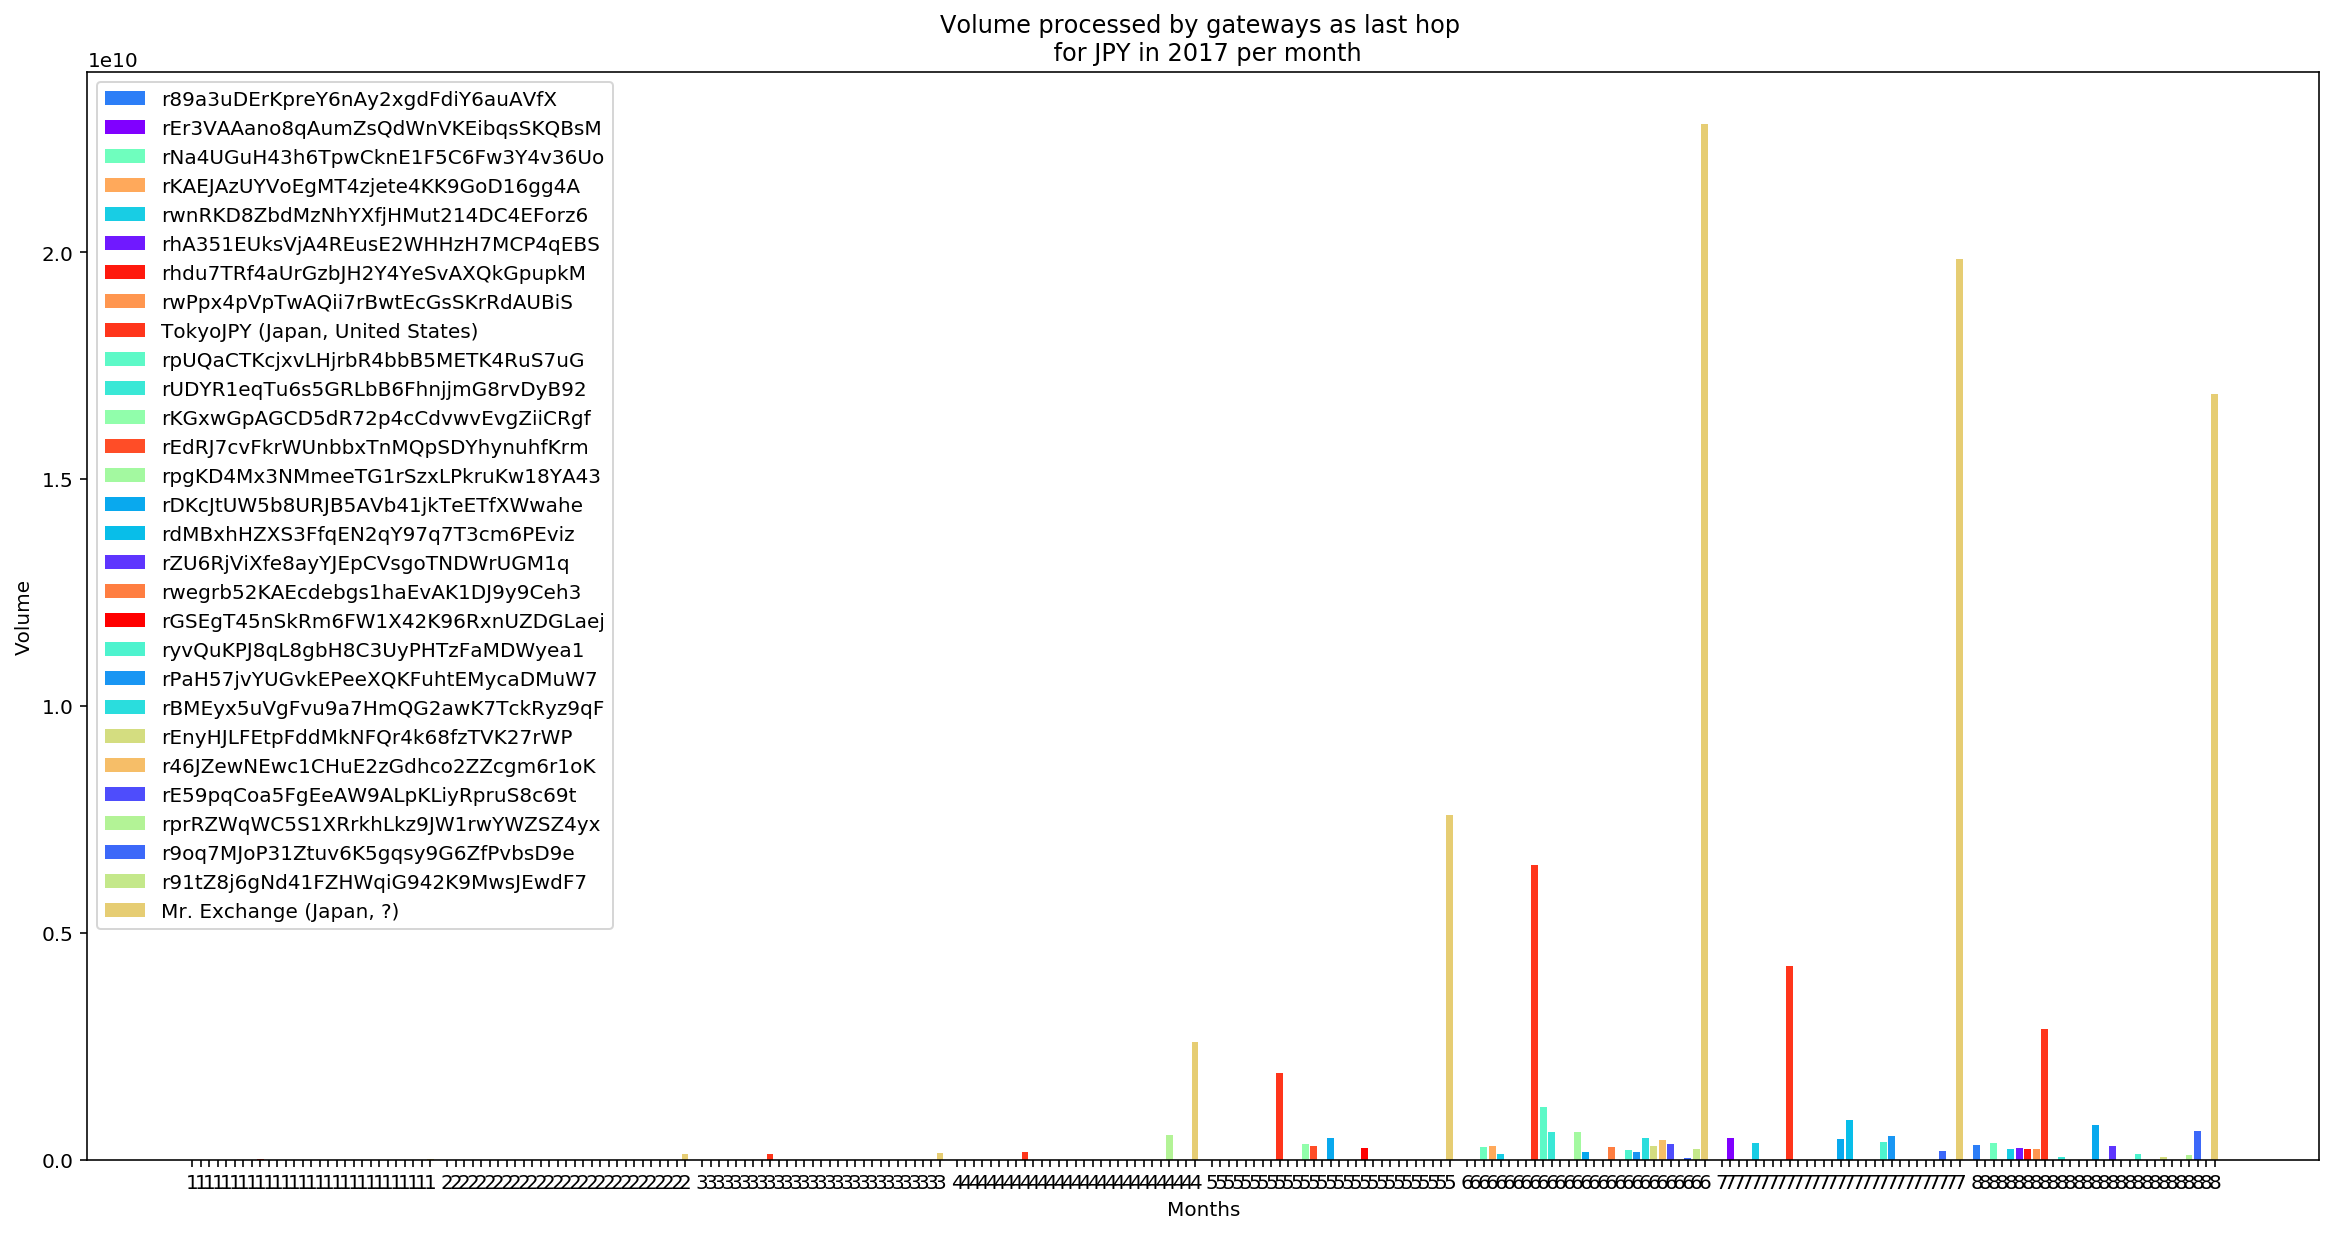

In [54]:
plot_per_gateway(dat_JPY_receiver_volume,'2017','JPY','Volume','last_hop',gateways_to_colors)
plot_per_month(dat_JPY_receiver_volume,'2017','JPY','Volume','last_hop',gateways_to_colors)

##### USD

In [55]:
dat_USD_sender = process('2017','USD',result_sender)
dat_USD_sender_volume = process('2017','USD',result_sender_volume)
dat_USD_receiver = process('2017','USD',result_receiver)
dat_USD_receiver_volume = process('2017','USD',result_receiver_volume)

In [56]:
all_gateways = set(dat_USD_sender.keys()) | set(dat_USD_sender_volume.keys()) | set(dat_USD_receiver.keys()) | set(dat_USD_receiver_volume.keys())
# define the colormap
colormap = plt.cm.rainbow
# extract all colors from the .viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(all_gateways))]

gateways_to_colors = {}
index_color = 0
for gateway in all_gateways:
    gateways_to_colors[gateway] = colors[index_color]
    index_color+=1

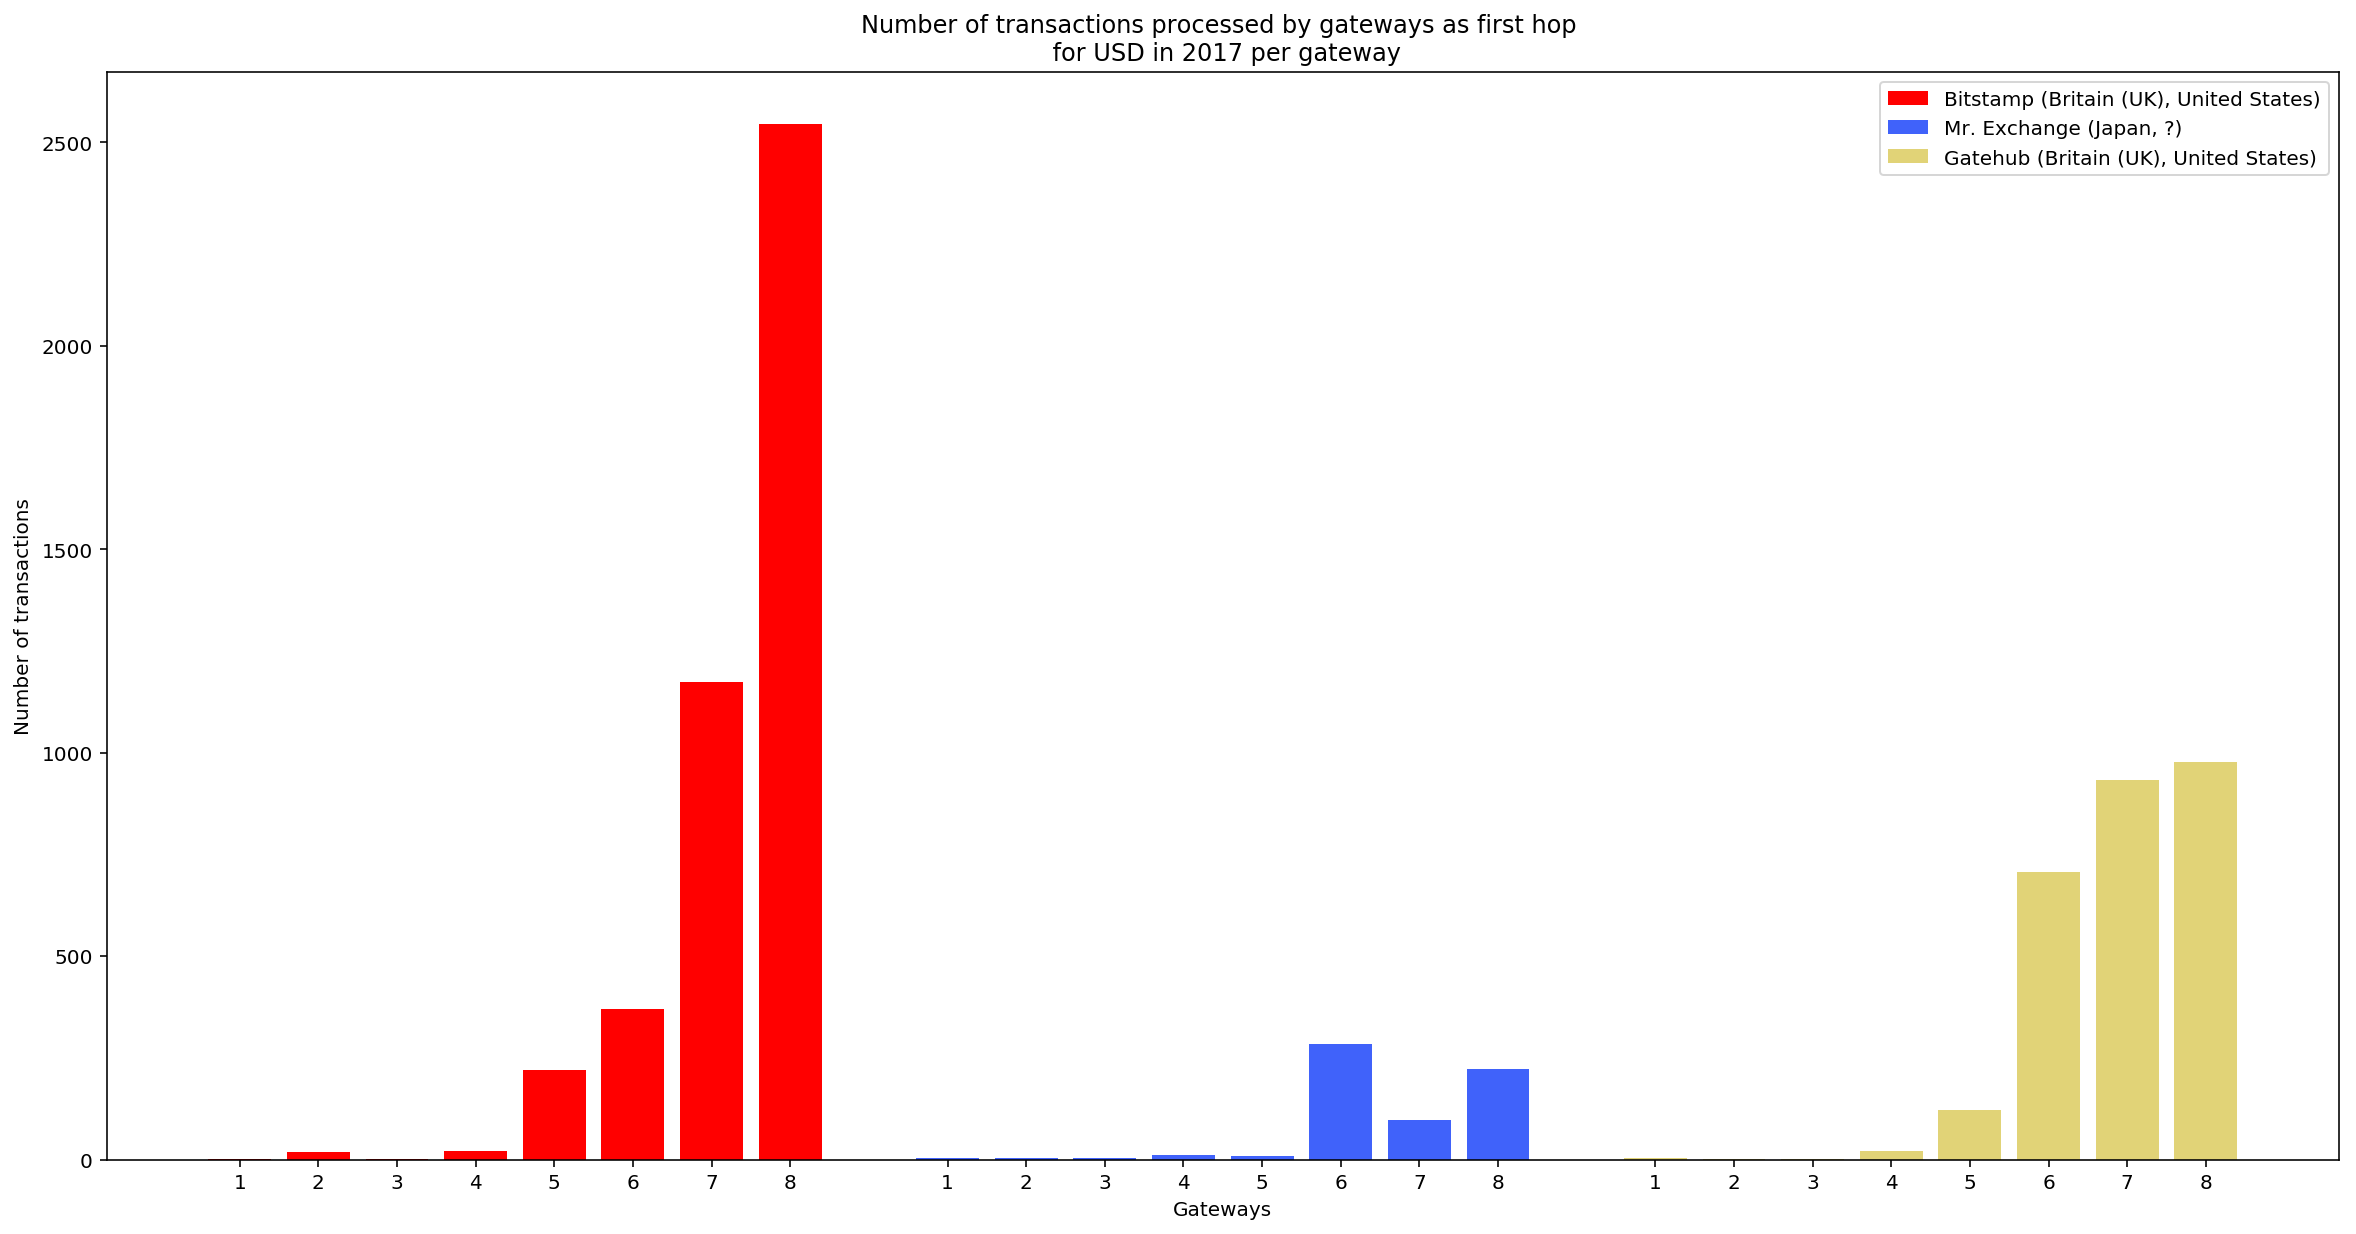

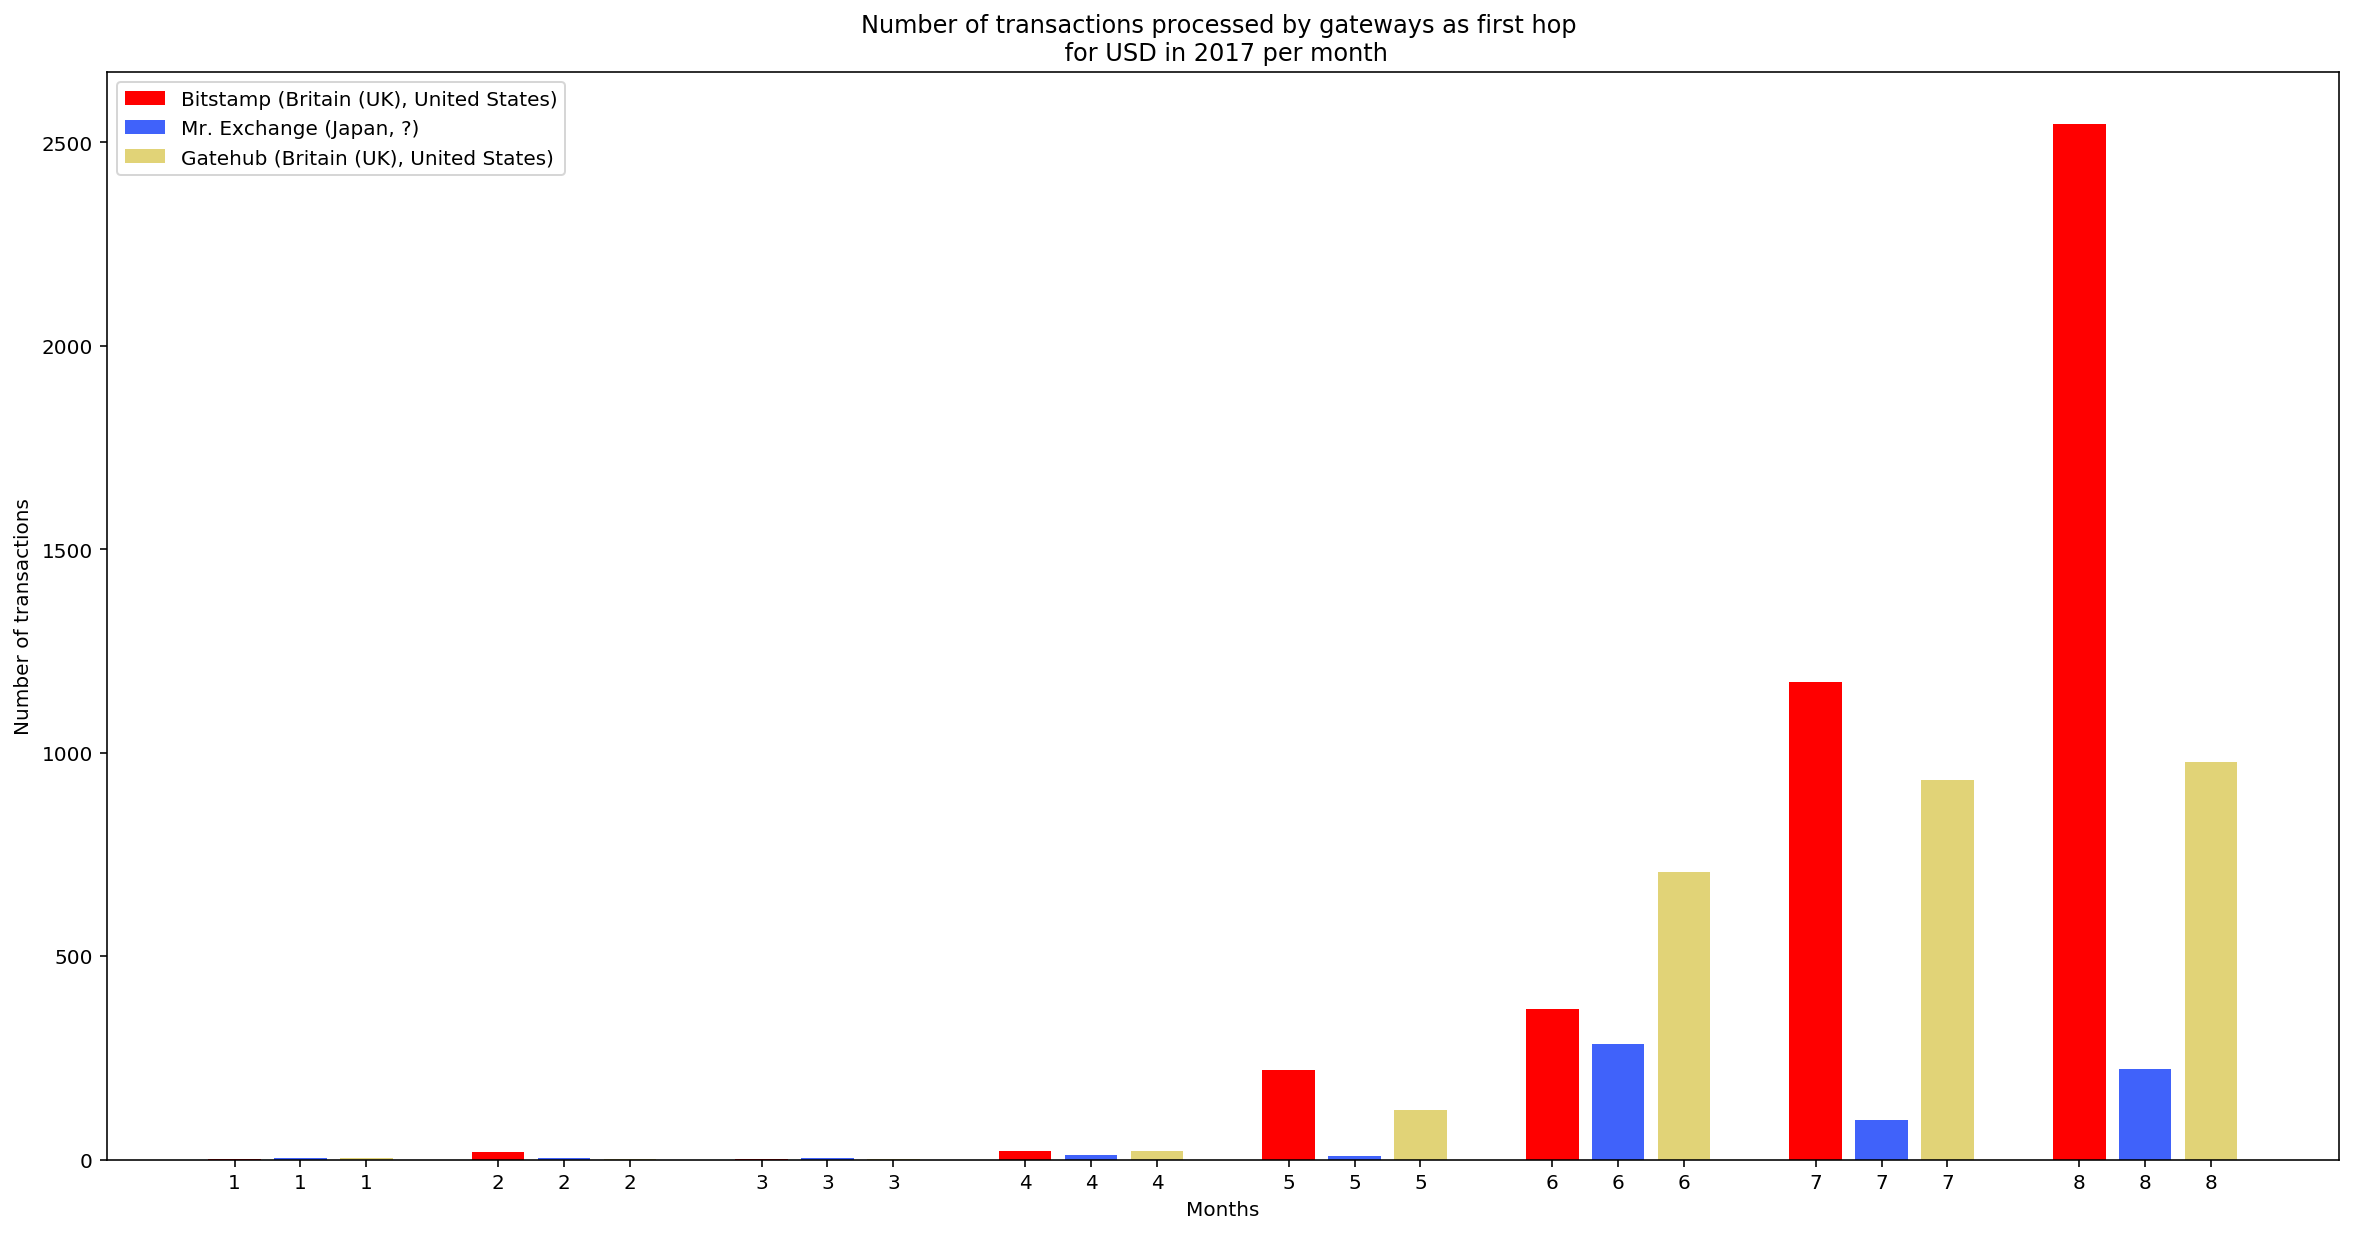

In [57]:
plot_per_gateway(dat_USD_sender,'2017','USD','Number_of_transactions','first_hop',gateways_to_colors)
plot_per_month(dat_USD_sender,'2017','USD','Number_of_transactions','first_hop',gateways_to_colors)

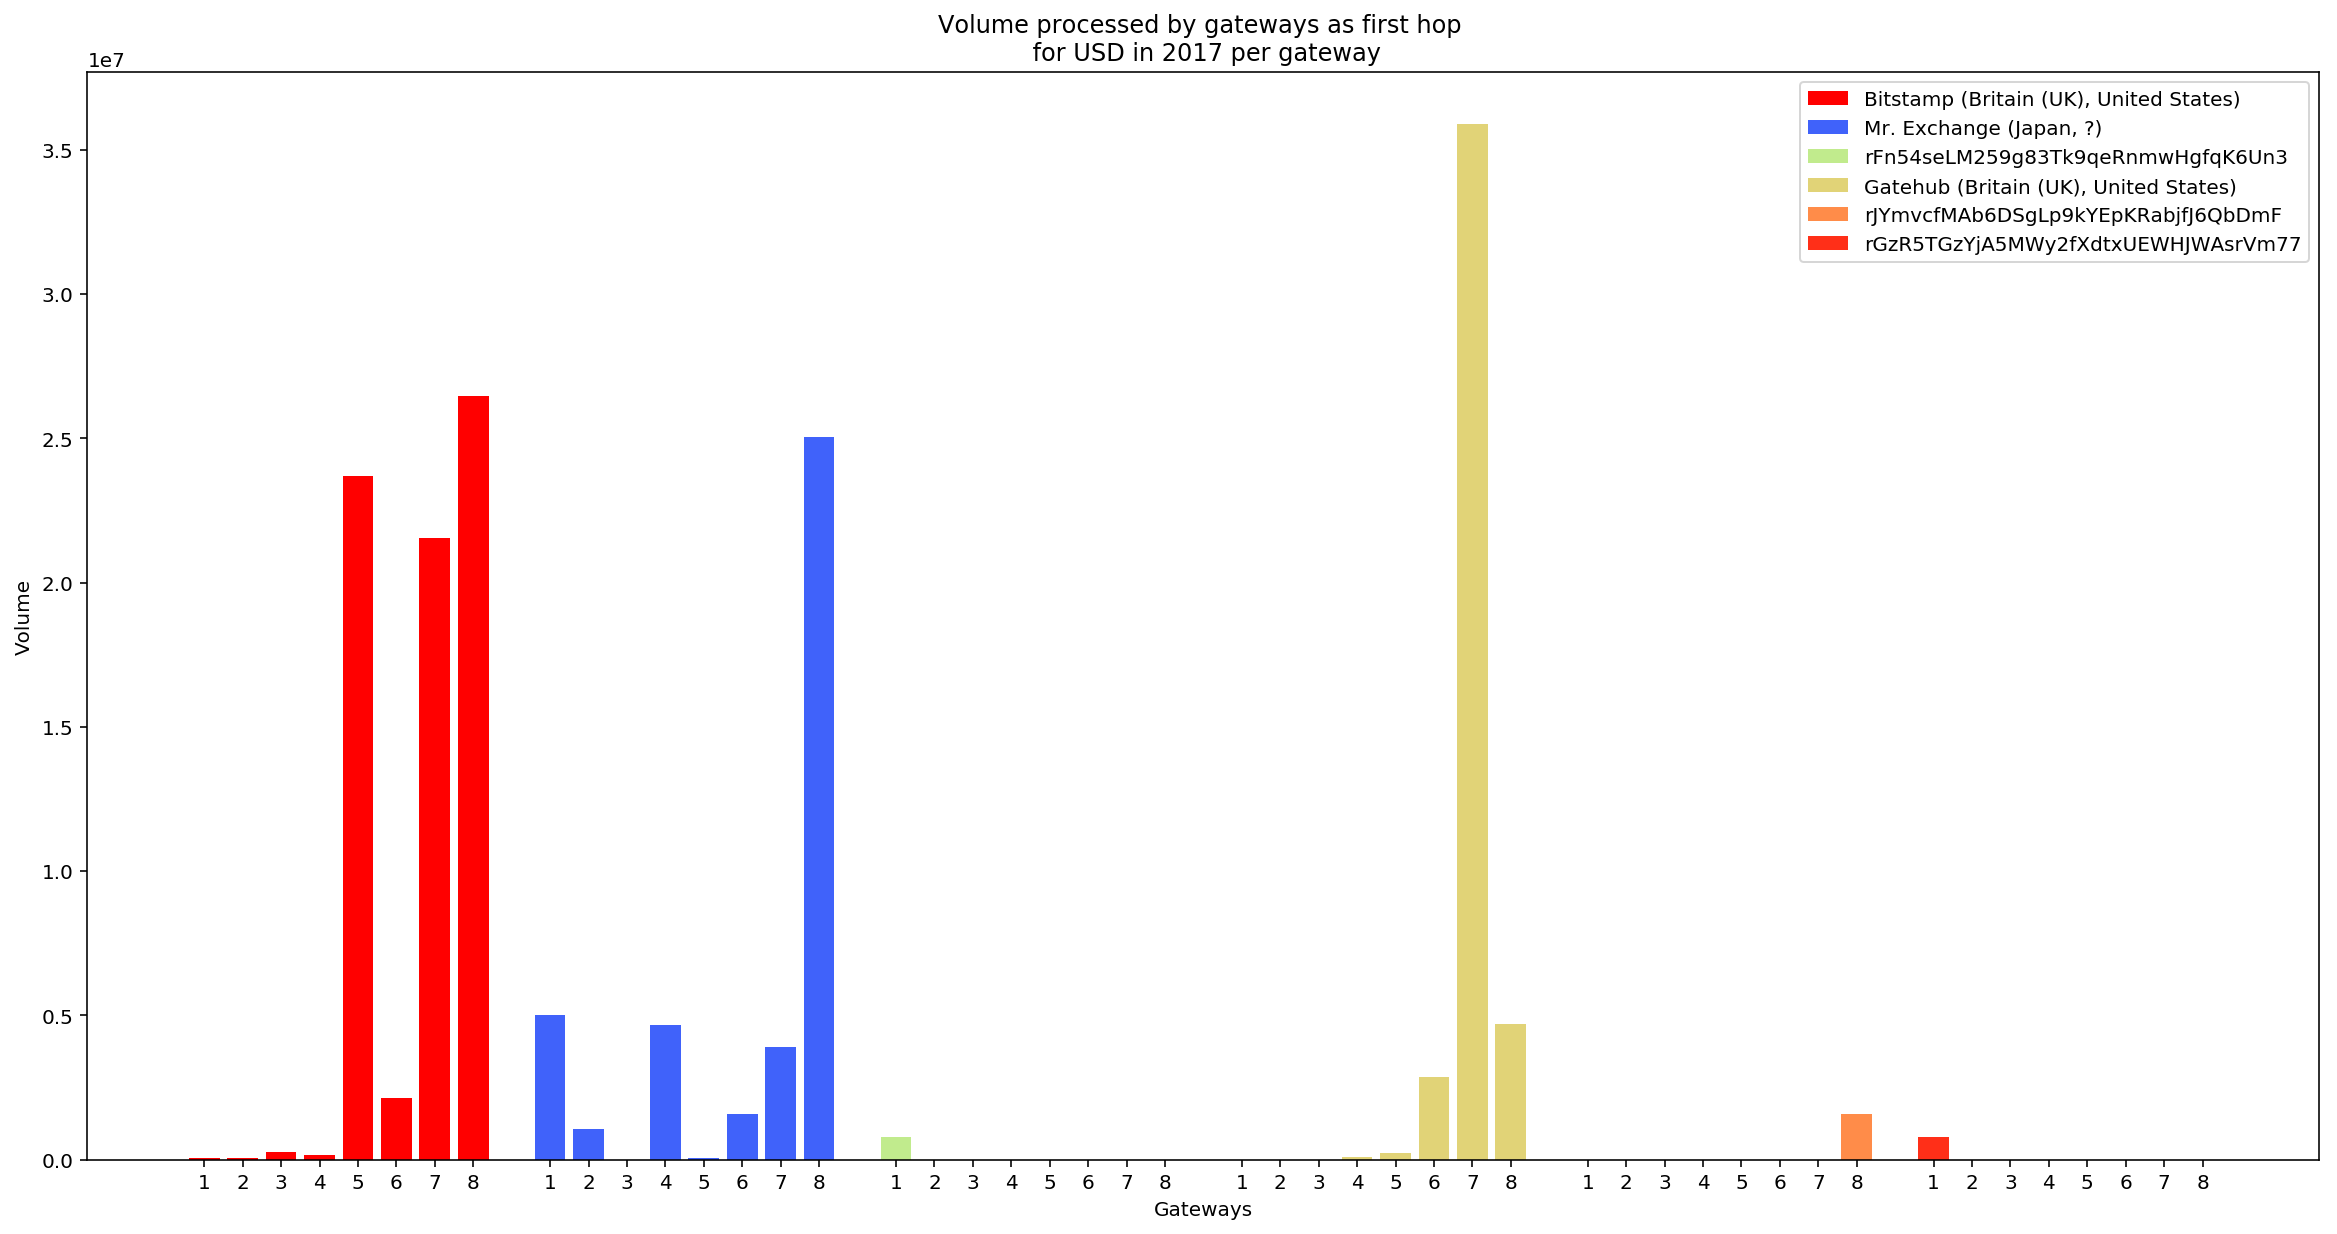

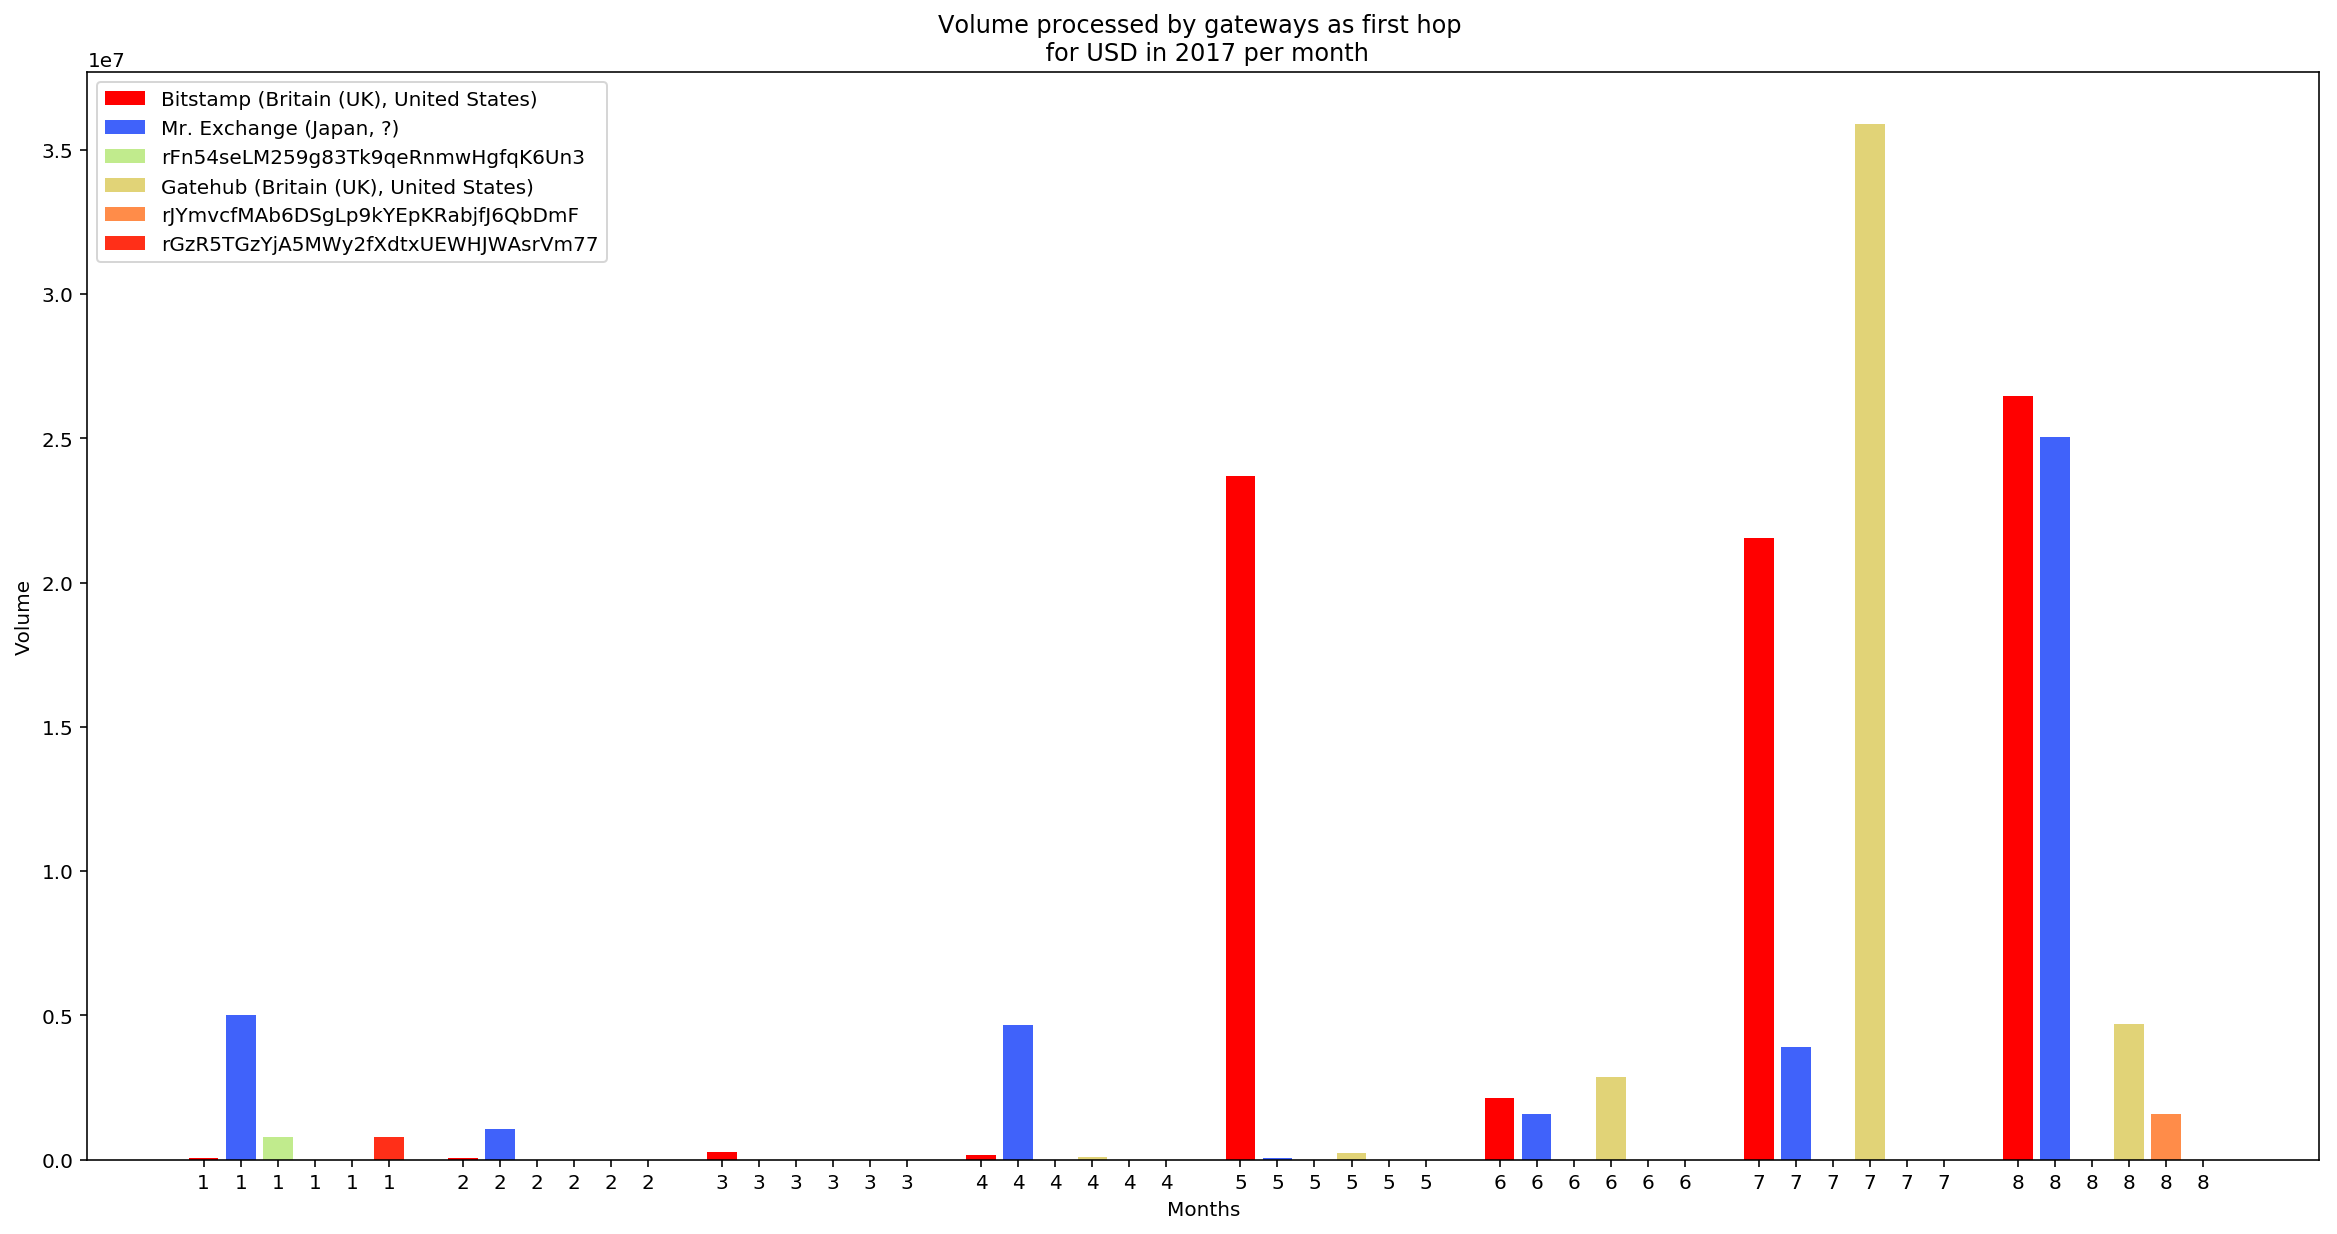

In [58]:
plot_per_gateway(dat_USD_sender_volume,'2017','USD','Volume','first_hop',gateways_to_colors)
plot_per_month(dat_USD_sender_volume,'2017','USD','Volume','first_hop',gateways_to_colors)

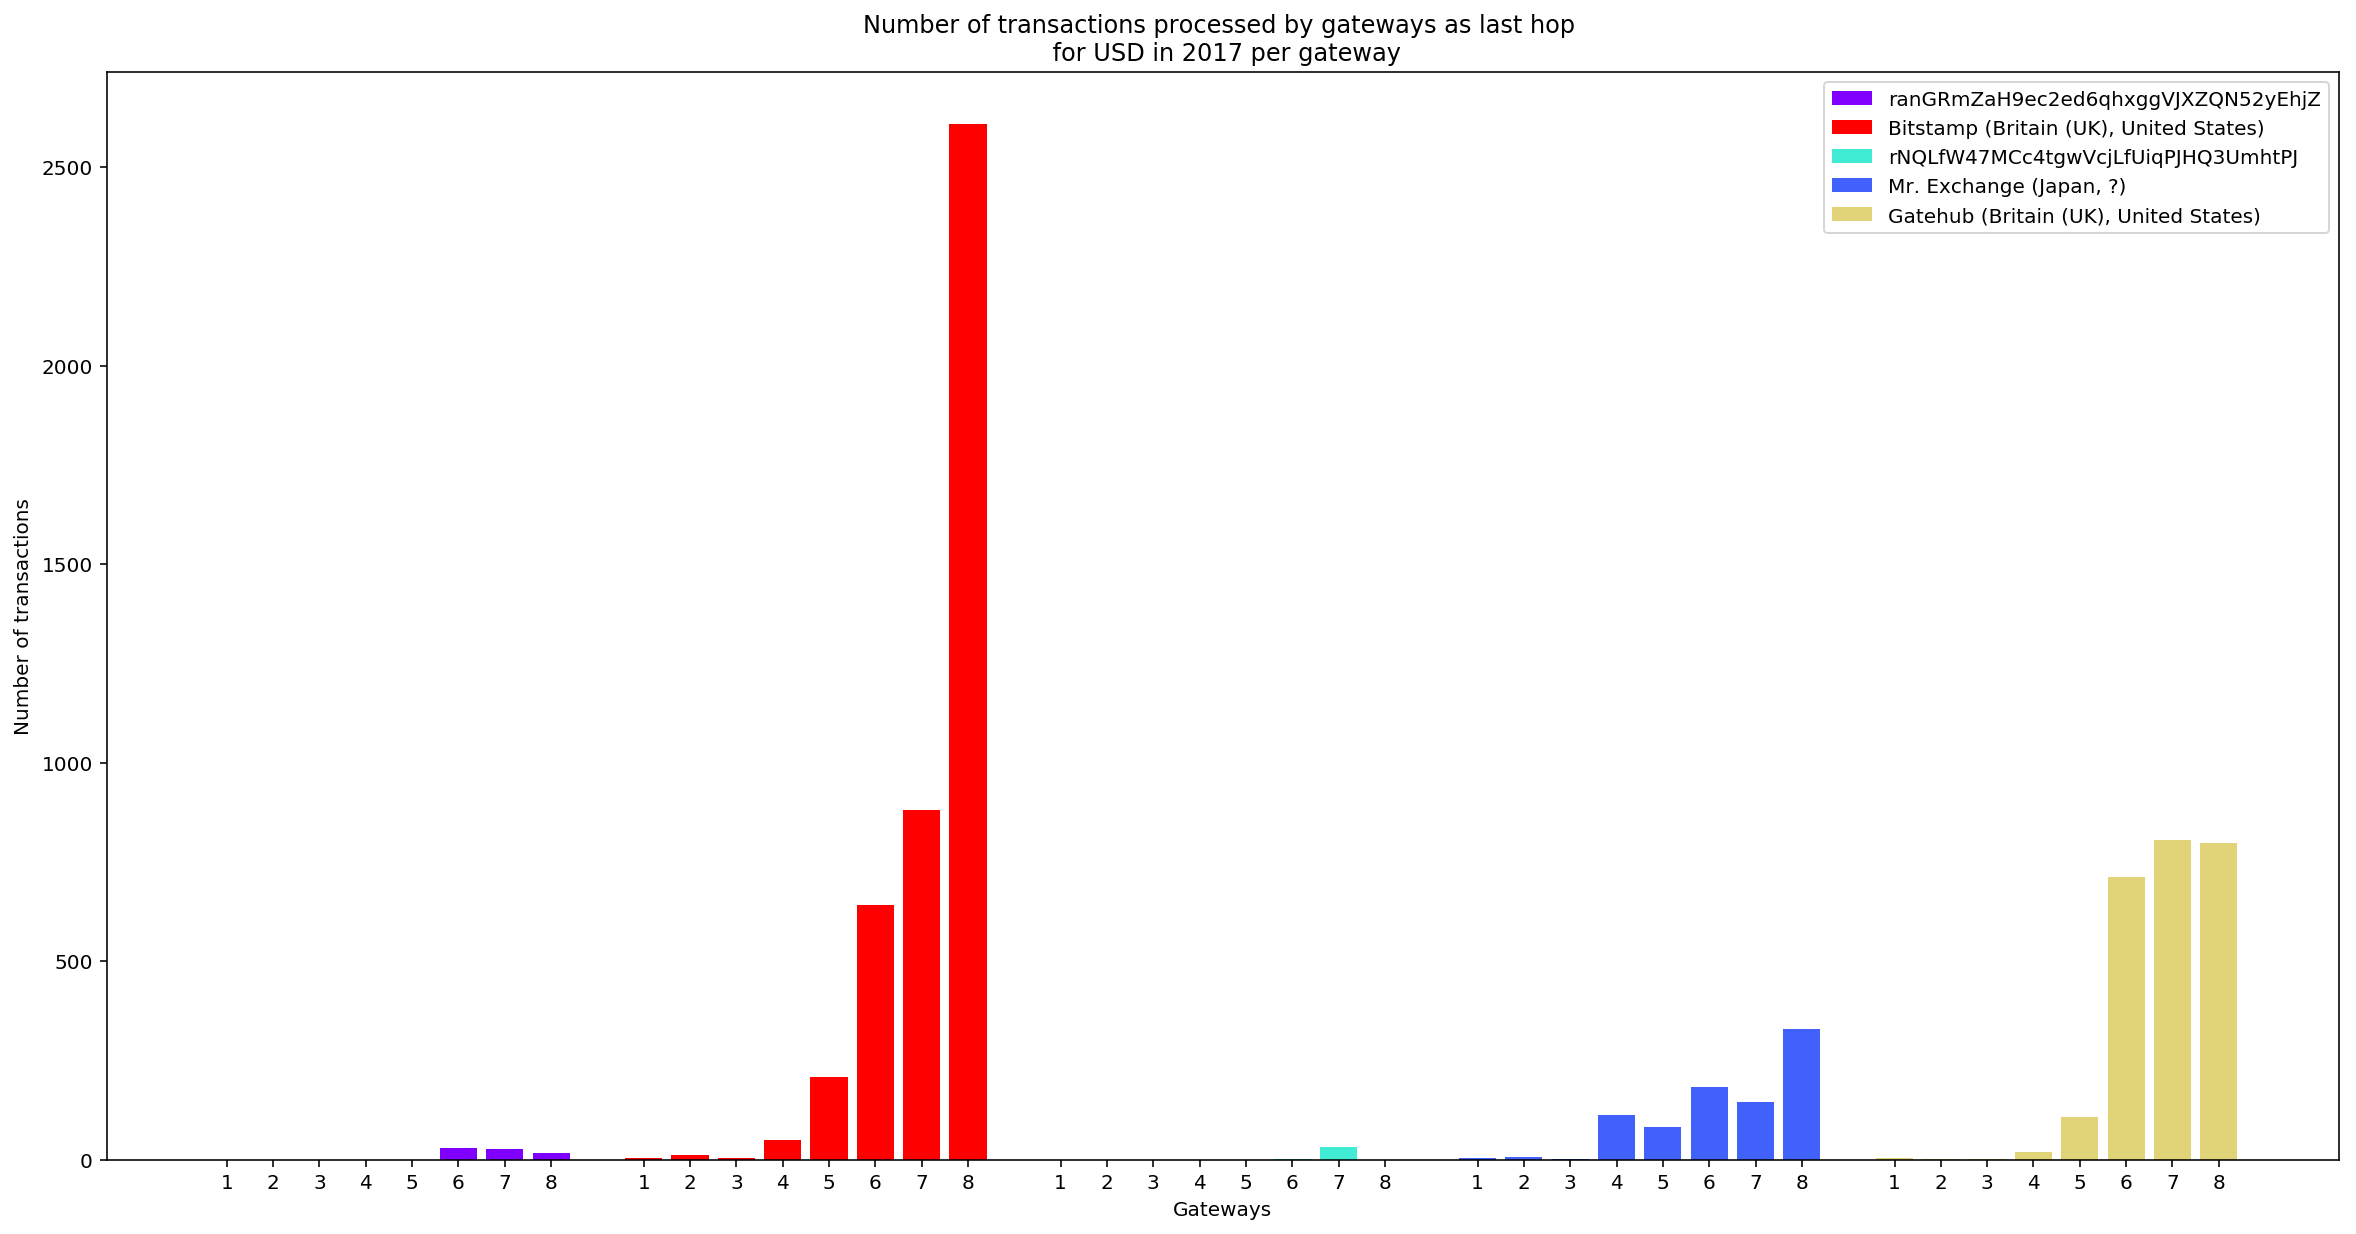

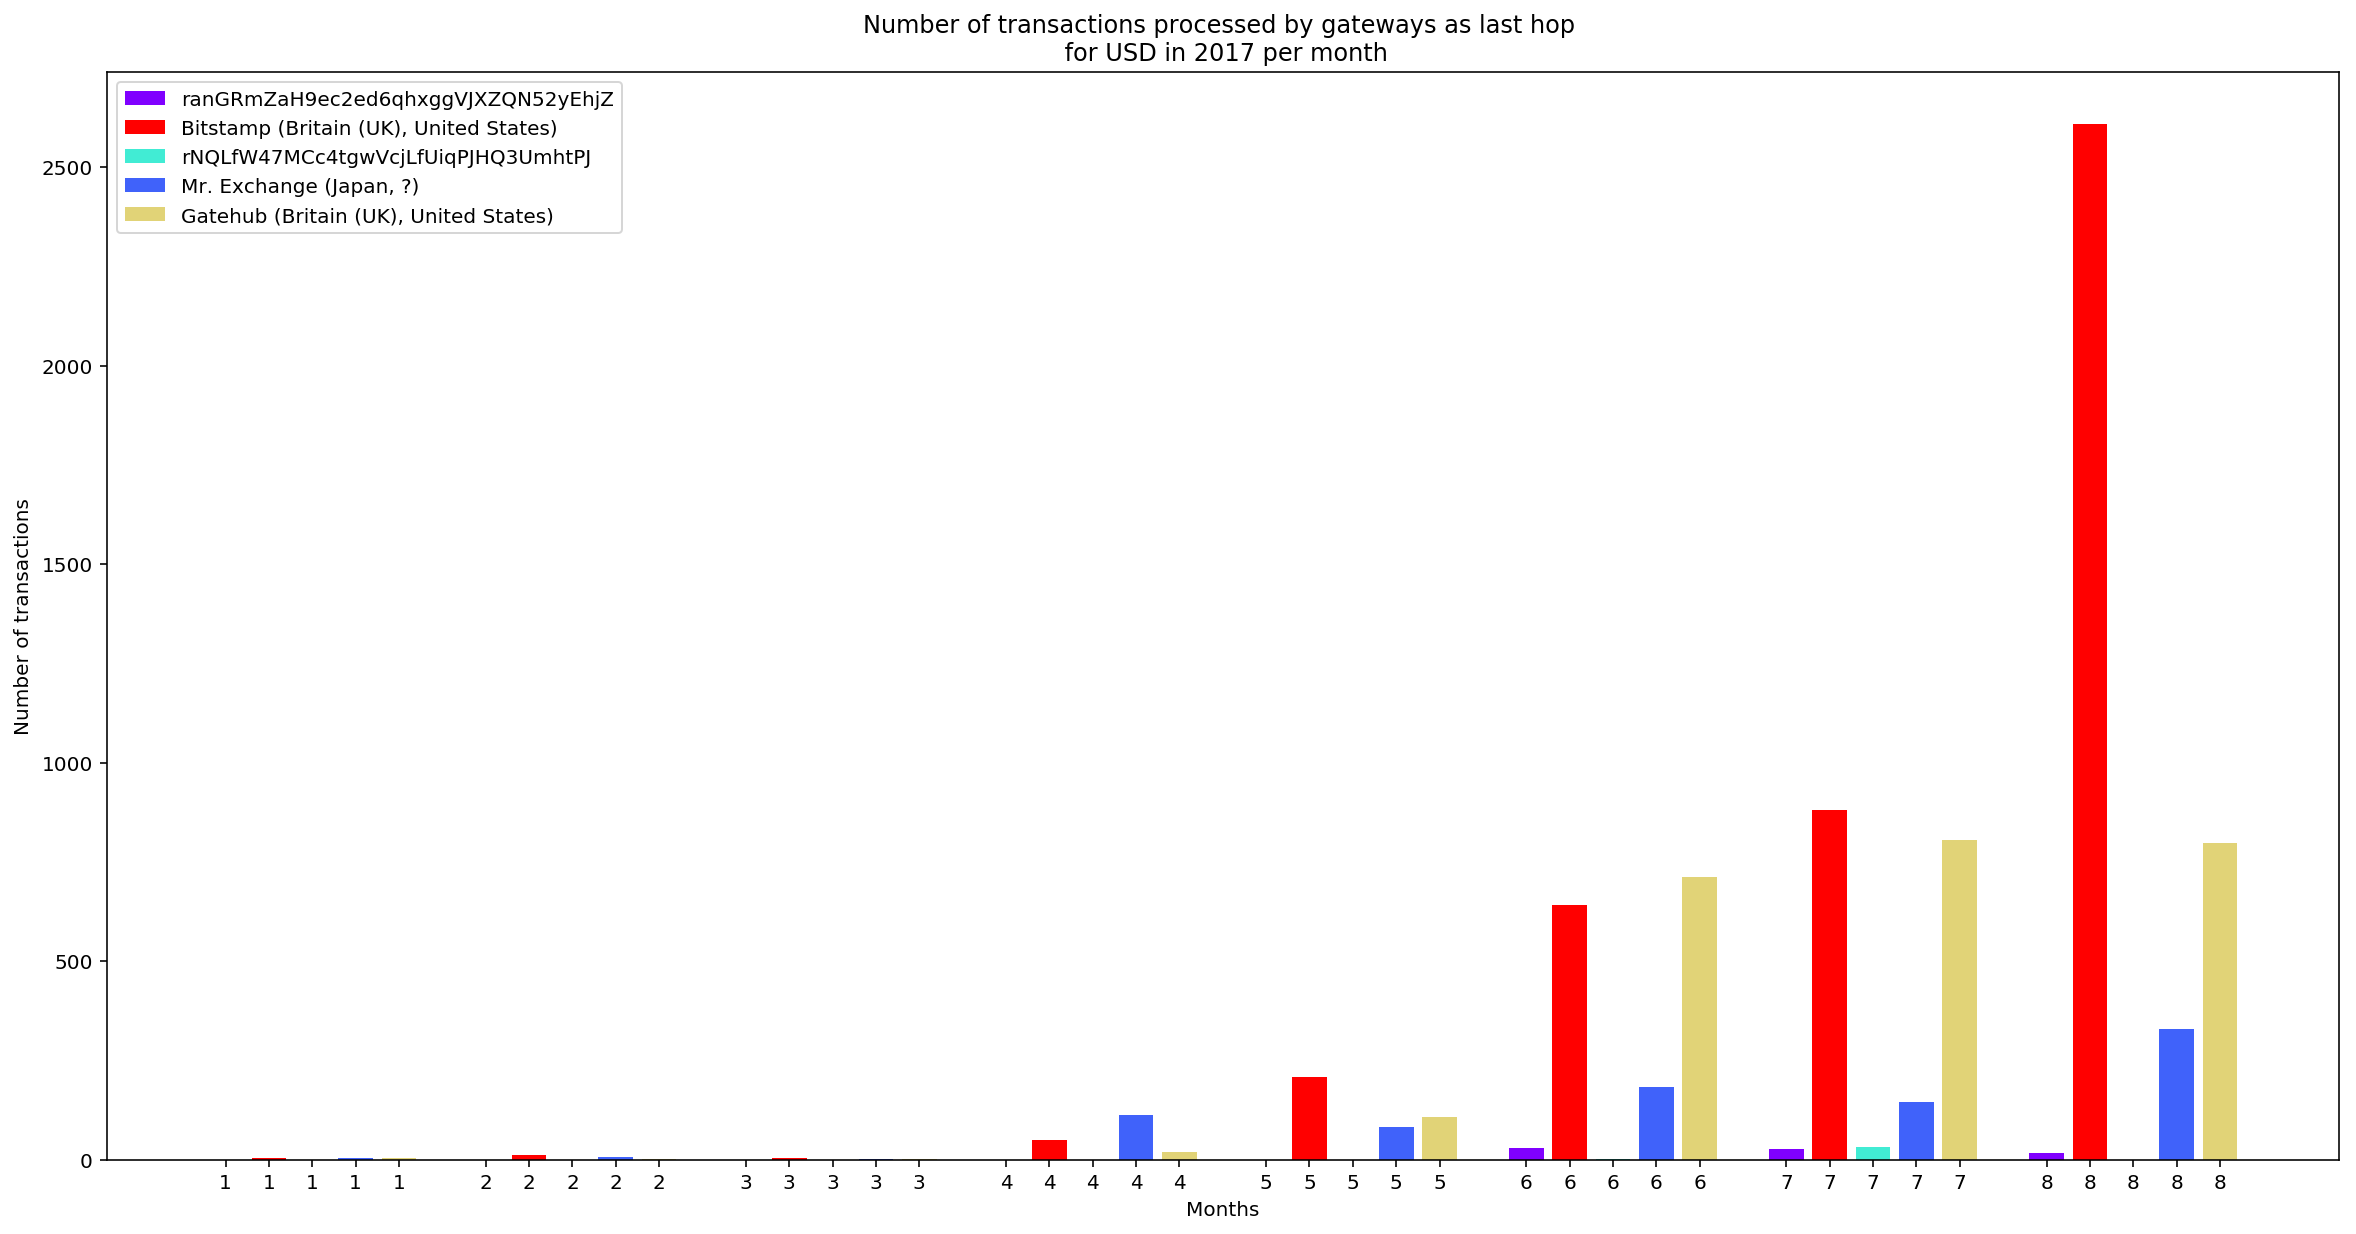

In [59]:
plot_per_gateway(dat_USD_receiver,'2017','USD','Number_of_transactions','last_hop',gateways_to_colors)
plot_per_month(dat_USD_receiver,'2017','USD','Number_of_transactions','last_hop',gateways_to_colors)

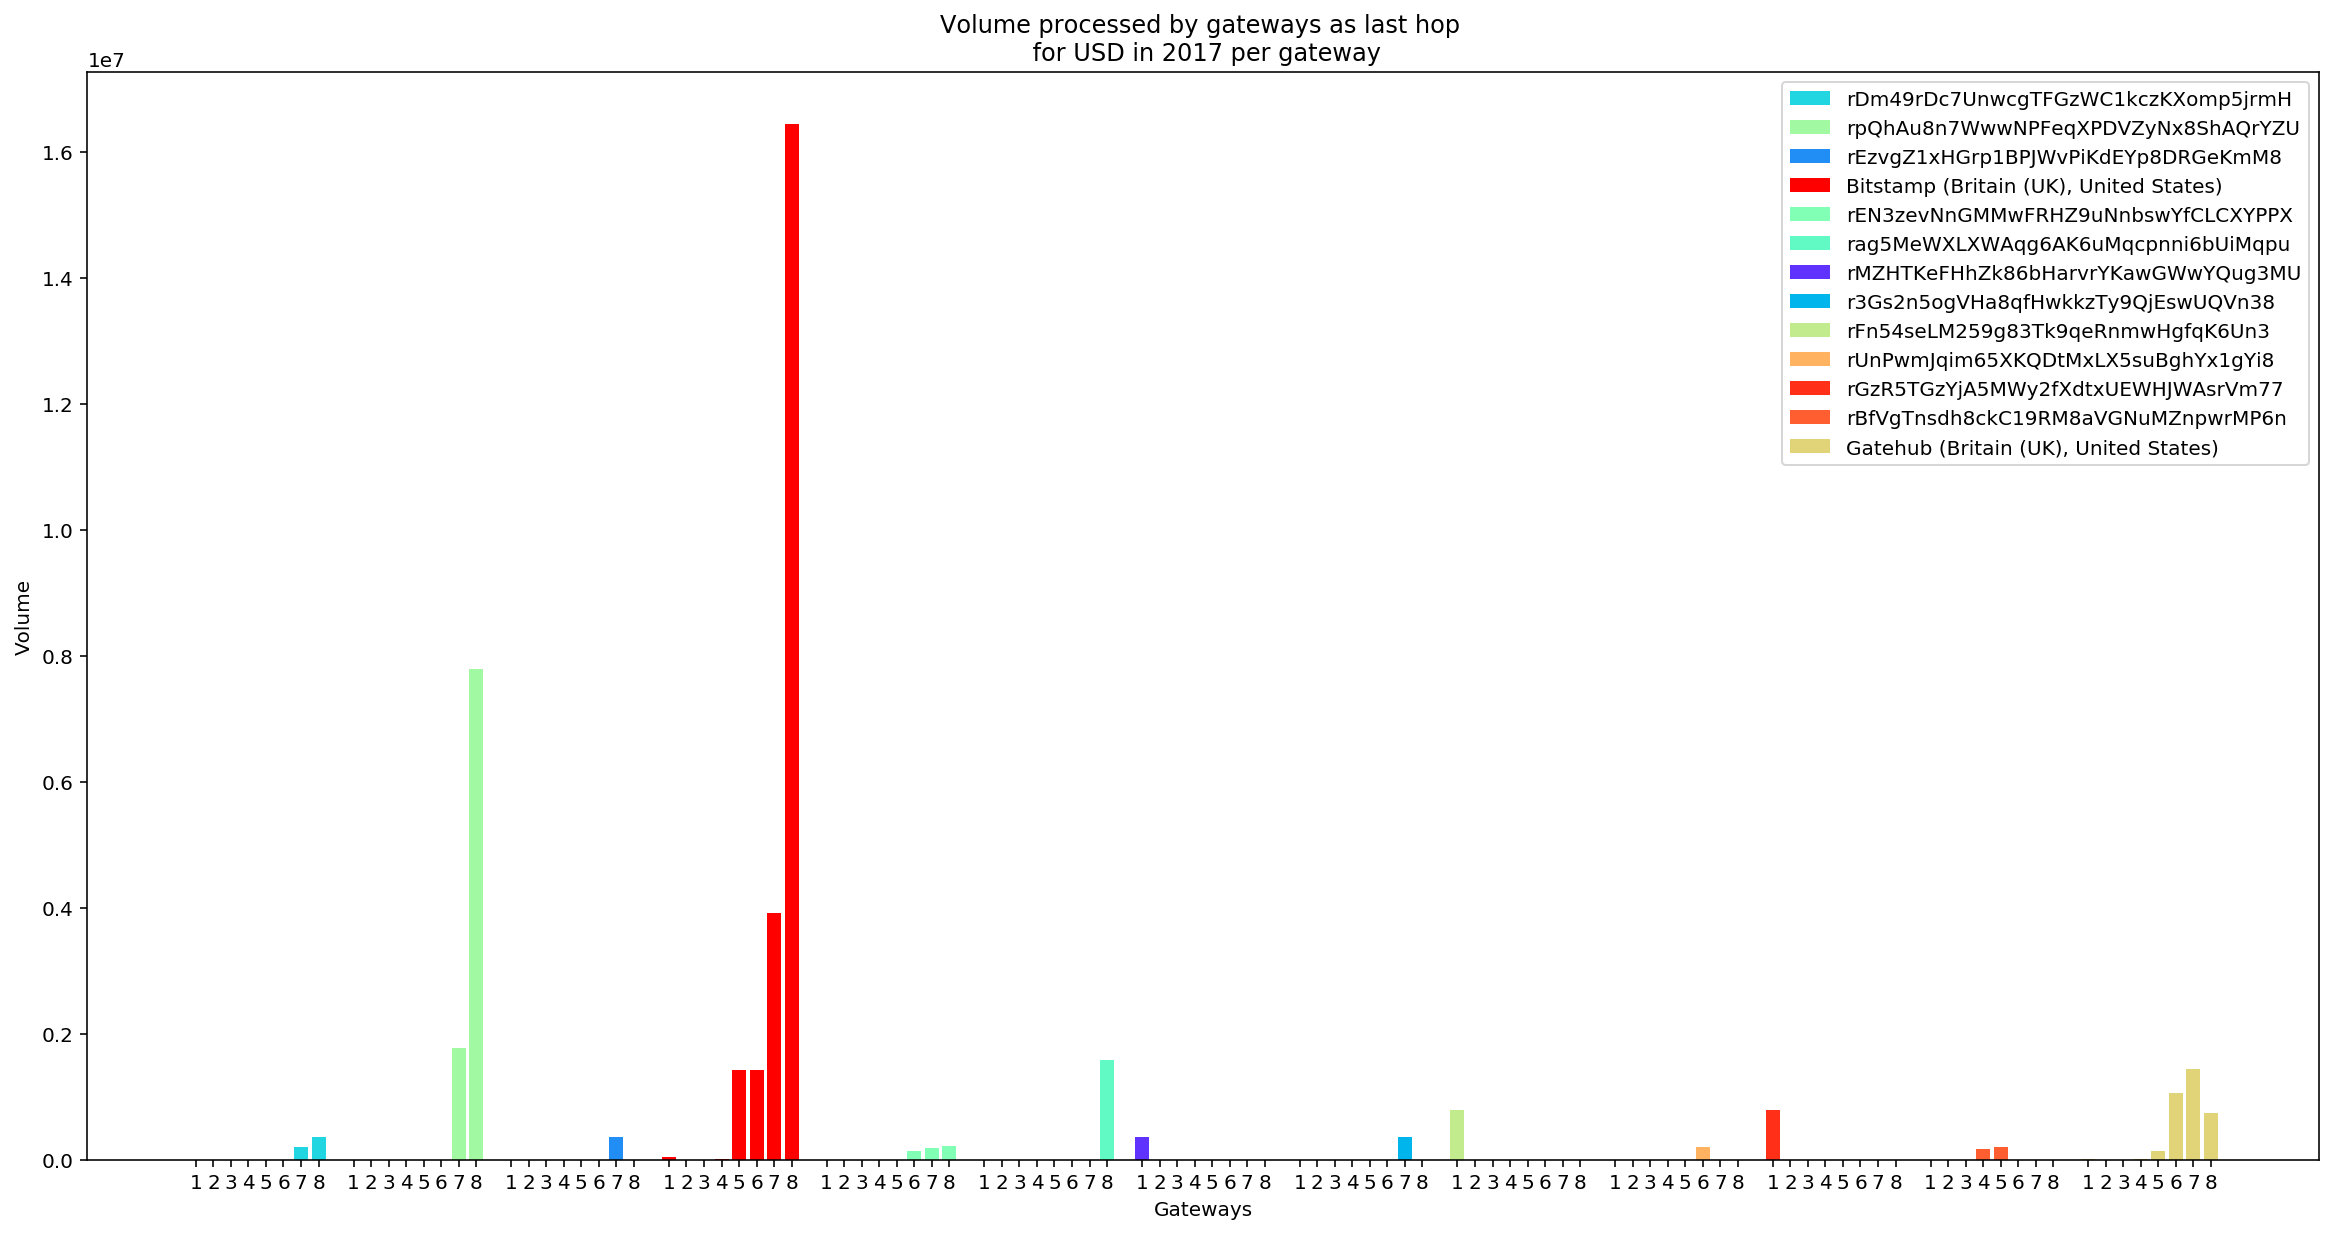

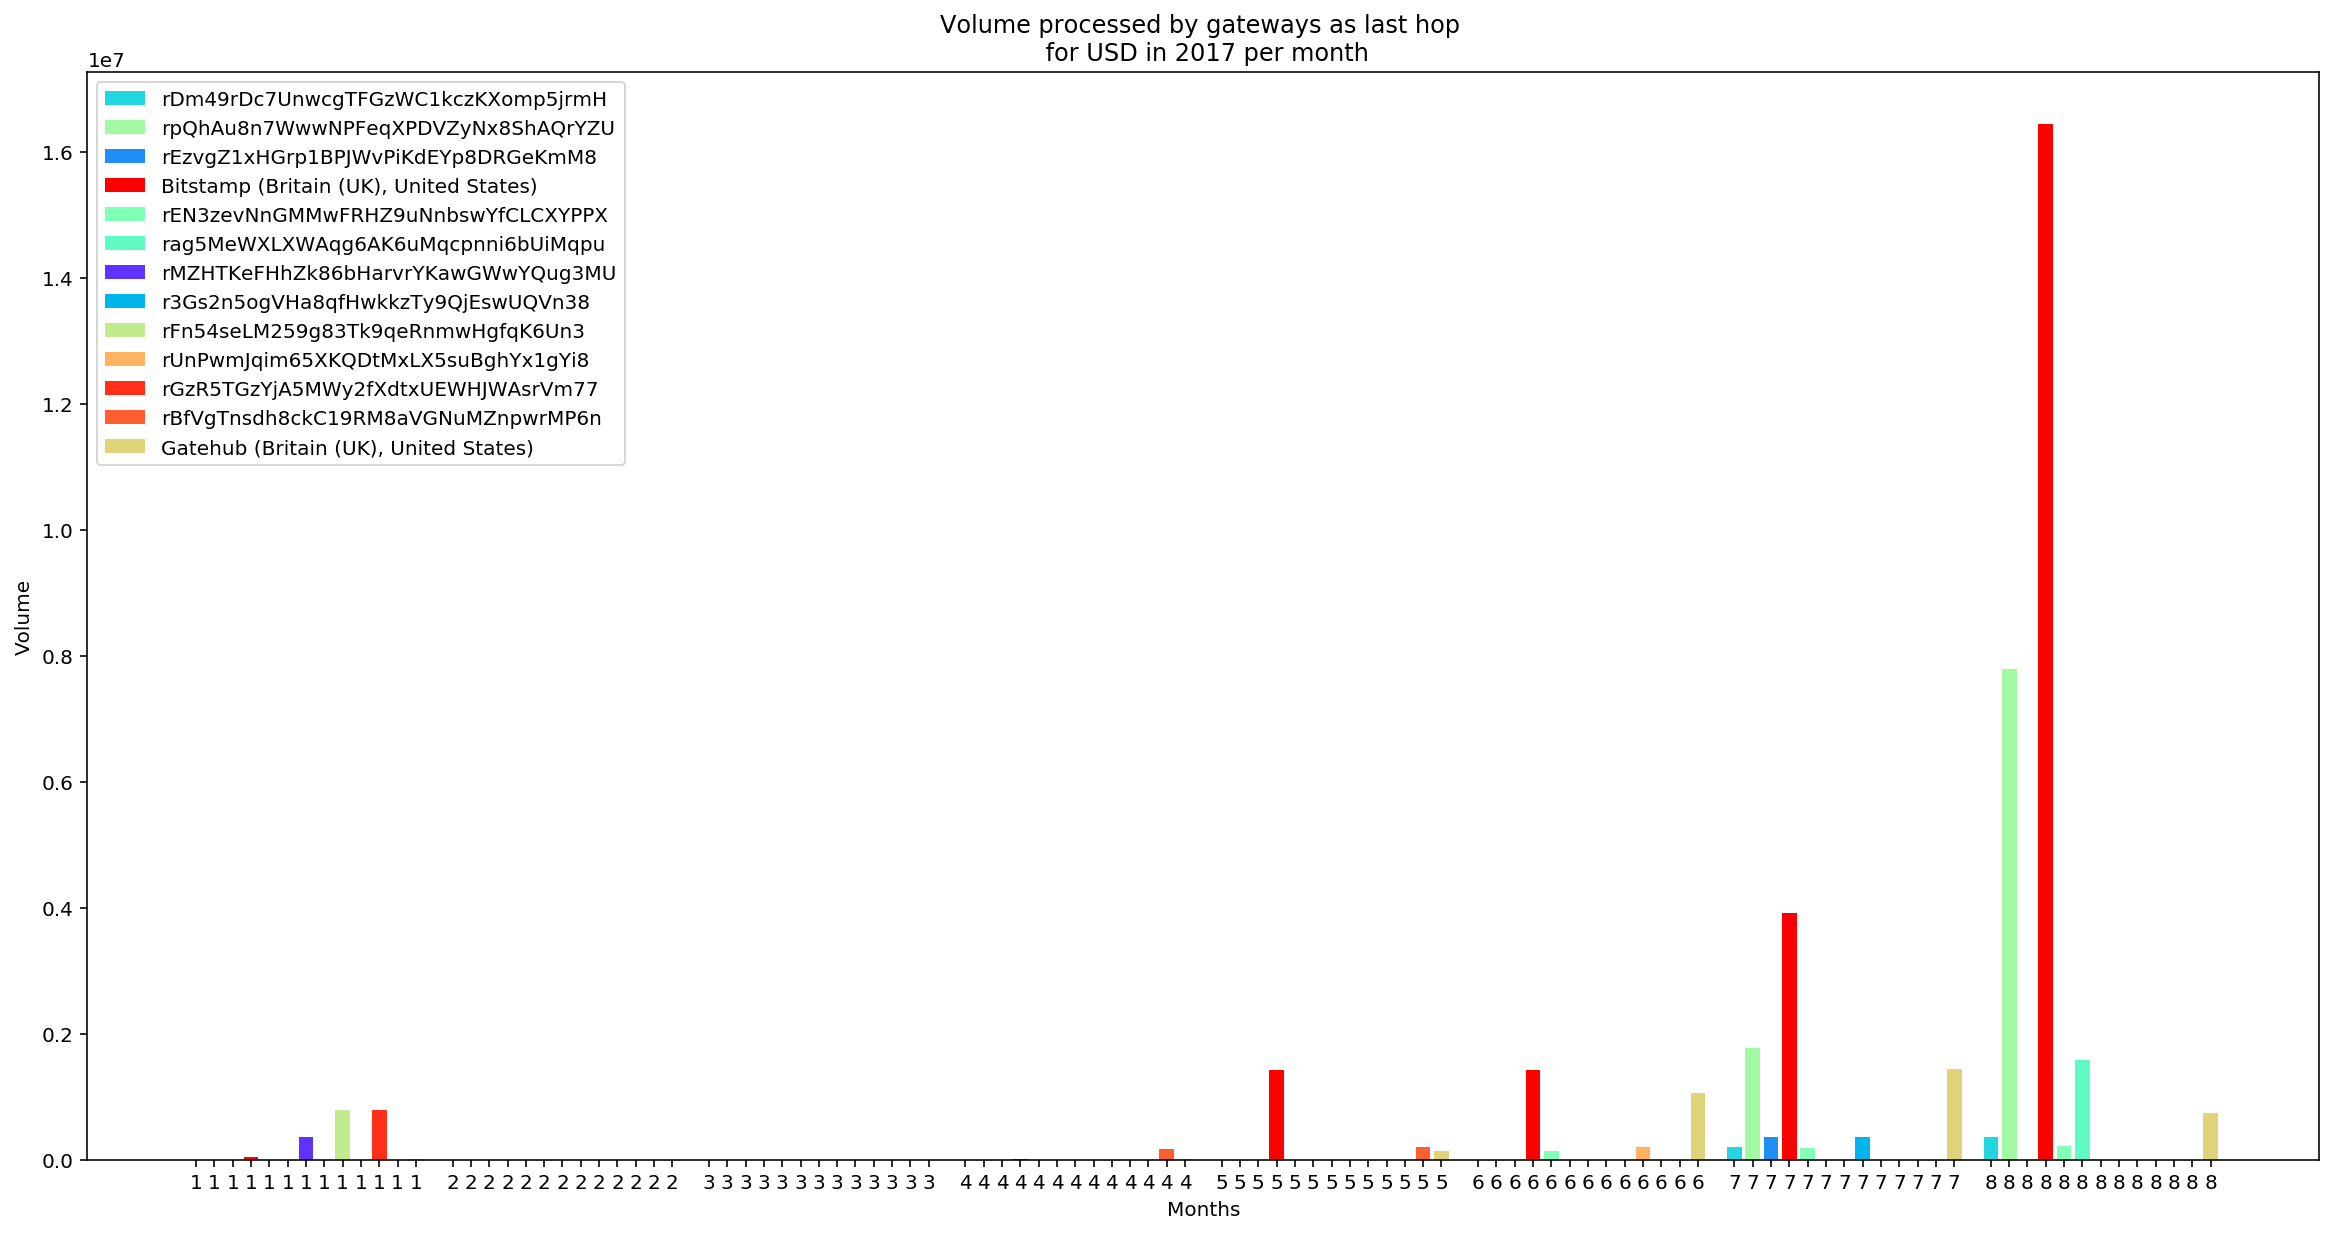

In [60]:
plot_per_gateway(dat_USD_receiver_volume,'2017','USD','Volume','last_hop',gateways_to_colors)
plot_per_month(dat_USD_receiver_volume,'2017','USD','Volume','last_hop',gateways_to_colors)

##### EUR

In [61]:
dat_EUR_sender = process('2017','EUR',result_sender)
dat_EUR_sender_volume = process('2017','EUR',result_sender_volume)
dat_EUR_receiver = process('2017','EUR',result_receiver)
dat_EUR_receiver_volume = process('2017','EUR',result_receiver_volume)

In [62]:
all_gateways = set(dat_EUR_sender.keys()) | set(dat_EUR_sender_volume.keys()) | set(dat_EUR_receiver.keys()) | set(dat_EUR_receiver_volume.keys())
# define the colormap
colormap = plt.cm.rainbow
# extract all colors from the .viridis
colors = [colormap(i) for i in np.linspace(0, 1,len(all_gateways))]

gateways_to_colors = {}
index_color = 0
for gateway in all_gateways:
    gateways_to_colors[gateway] = colors[index_color]
    index_color+=1

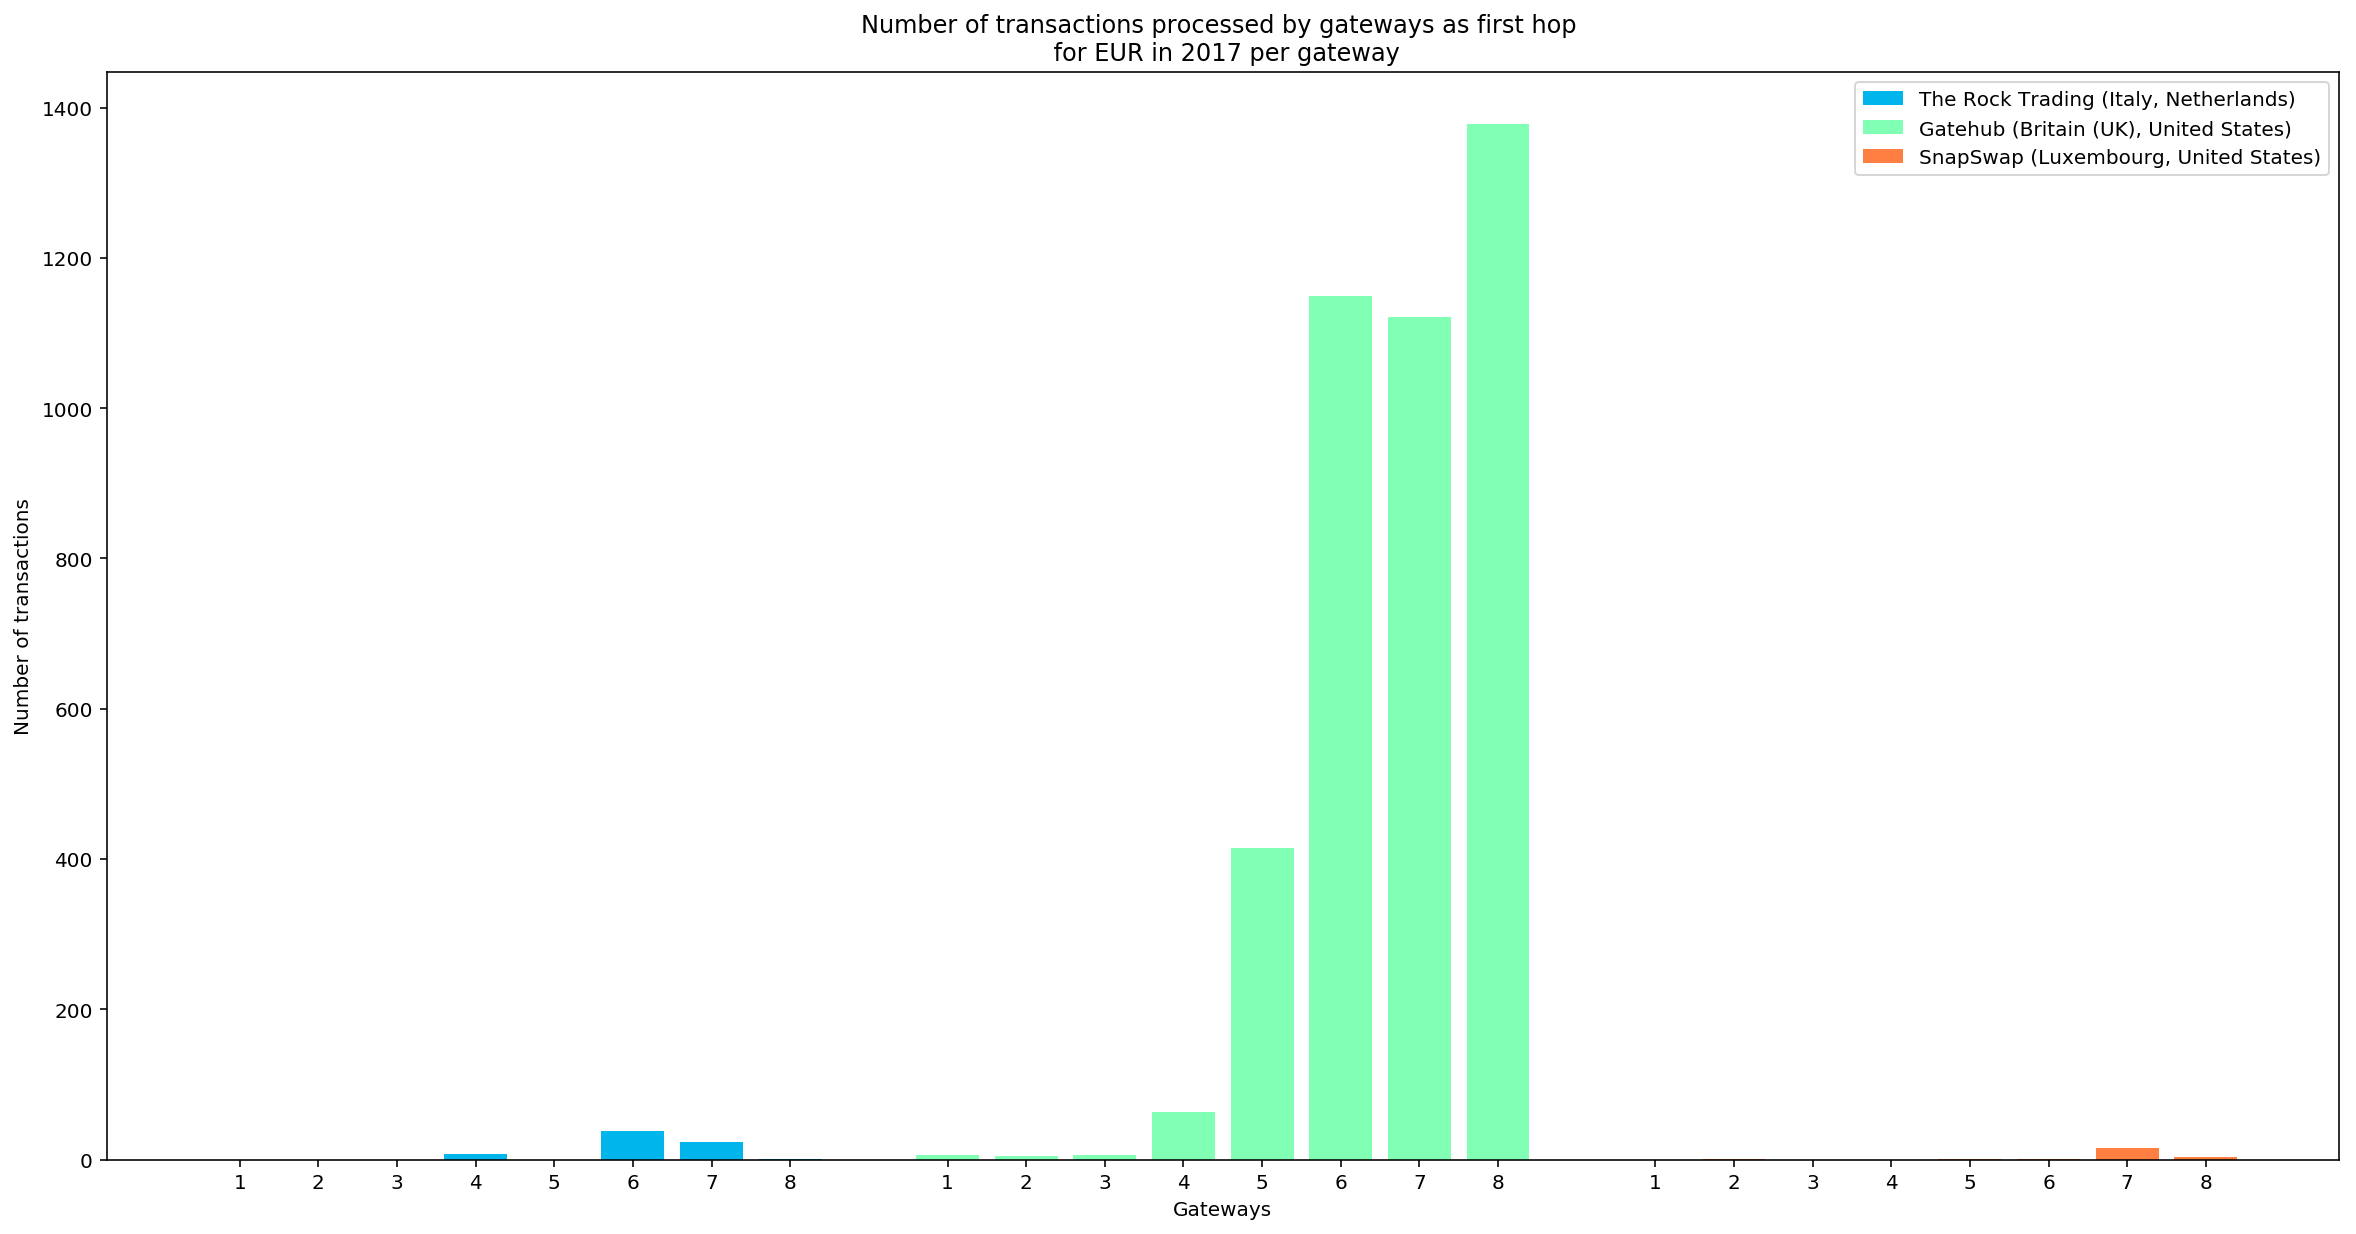

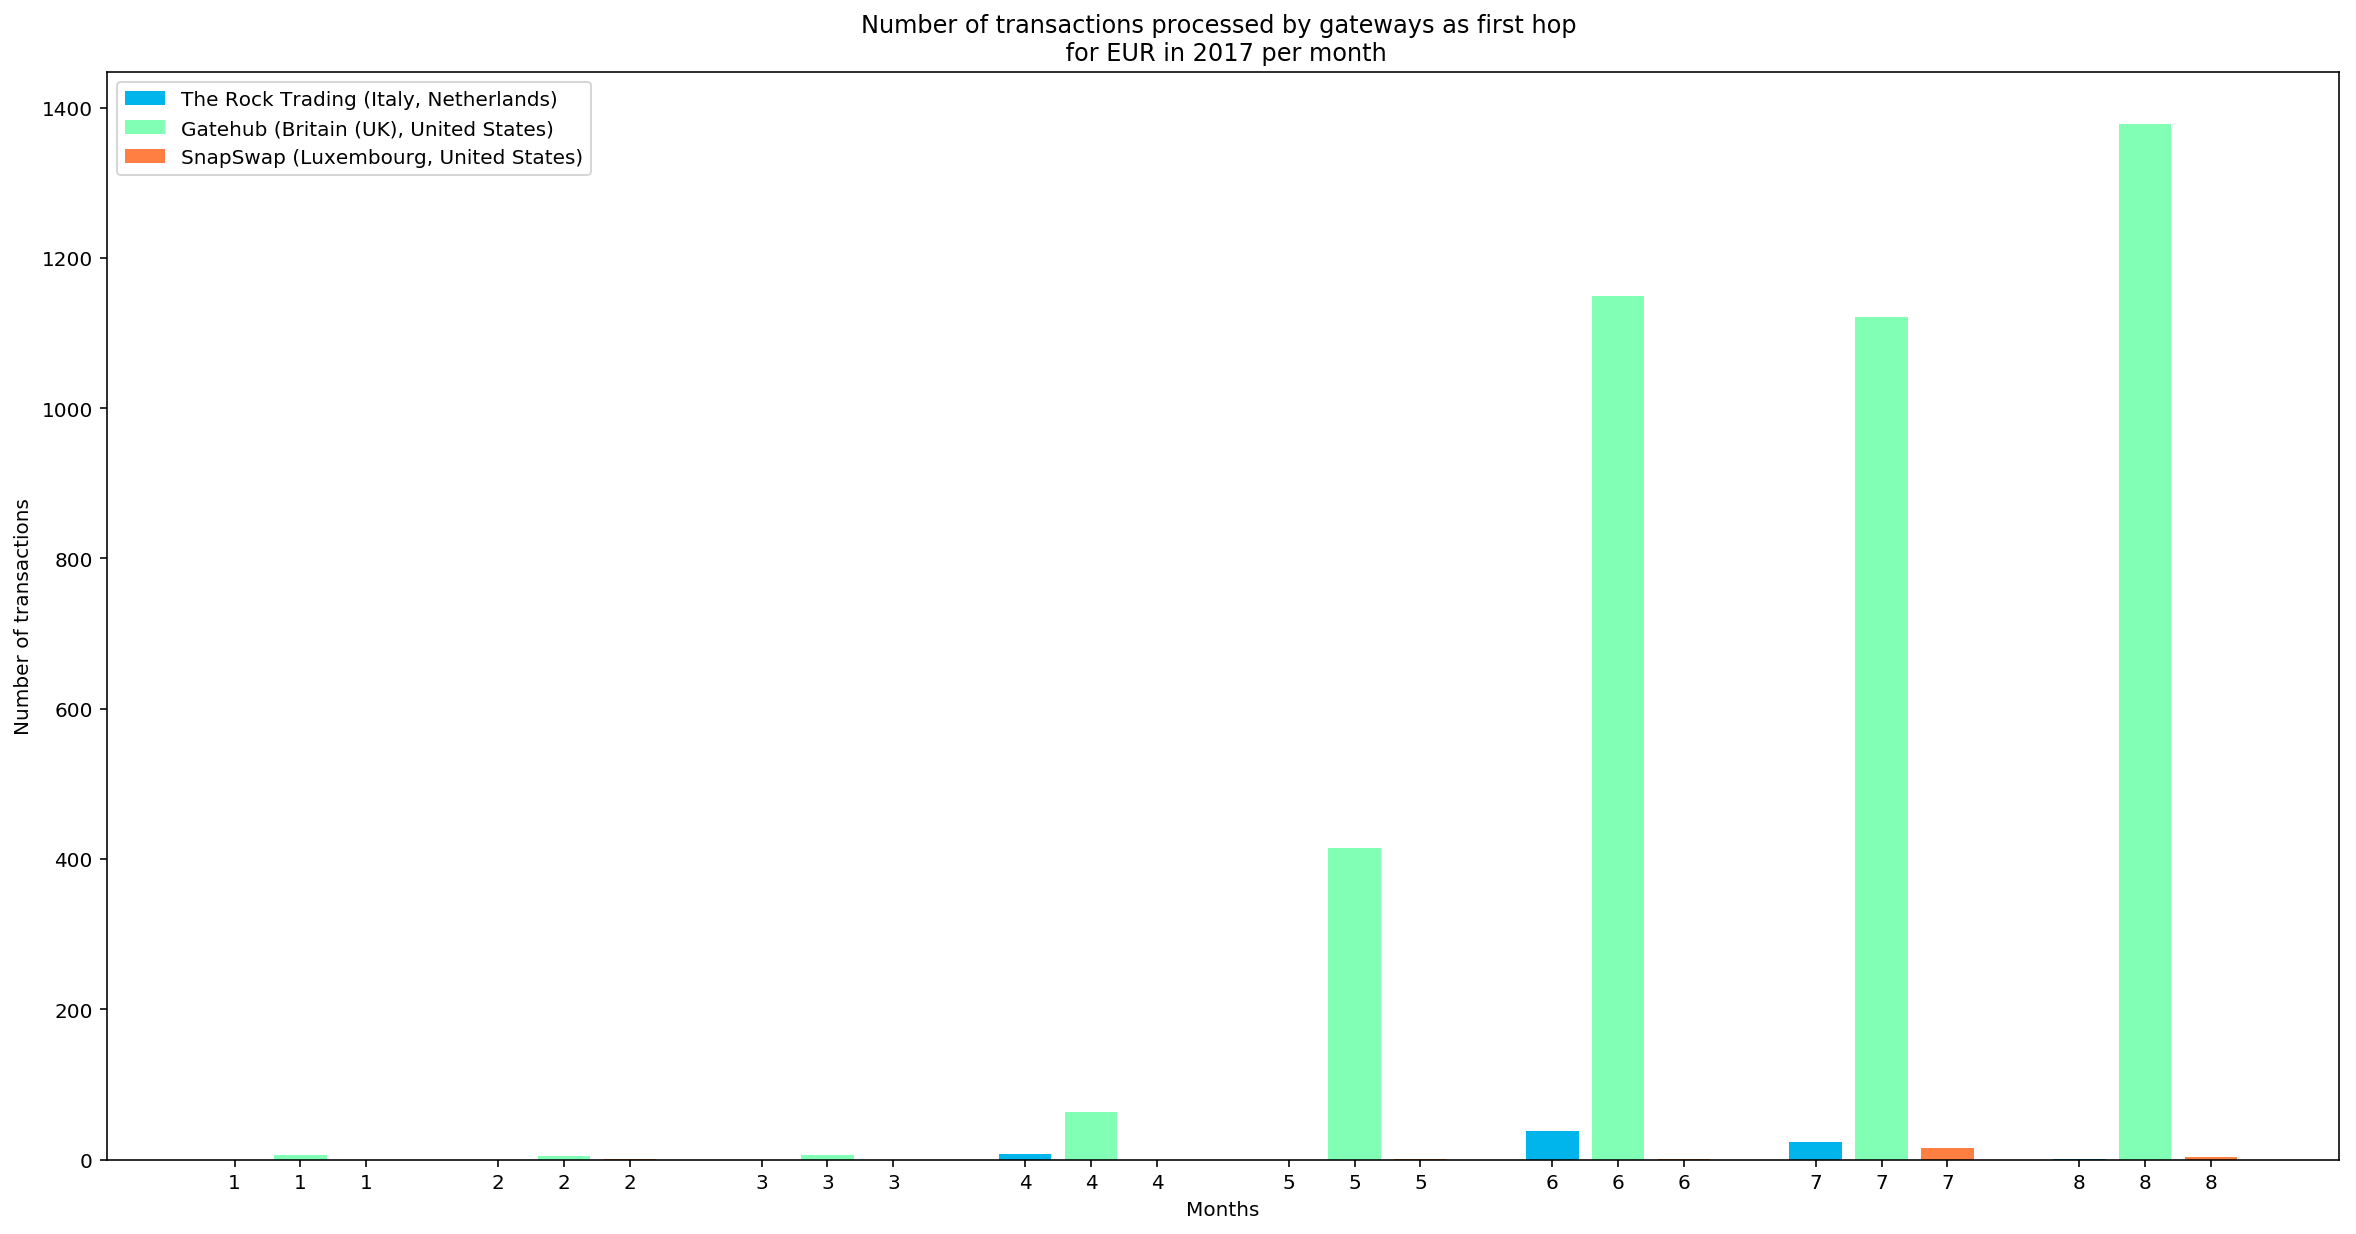

In [63]:
plot_per_gateway(dat_EUR_sender,'2017','EUR','Number_of_transactions','first_hop',gateways_to_colors)
plot_per_month(dat_EUR_sender,'2017','EUR','Number_of_transactions','first_hop',gateways_to_colors)

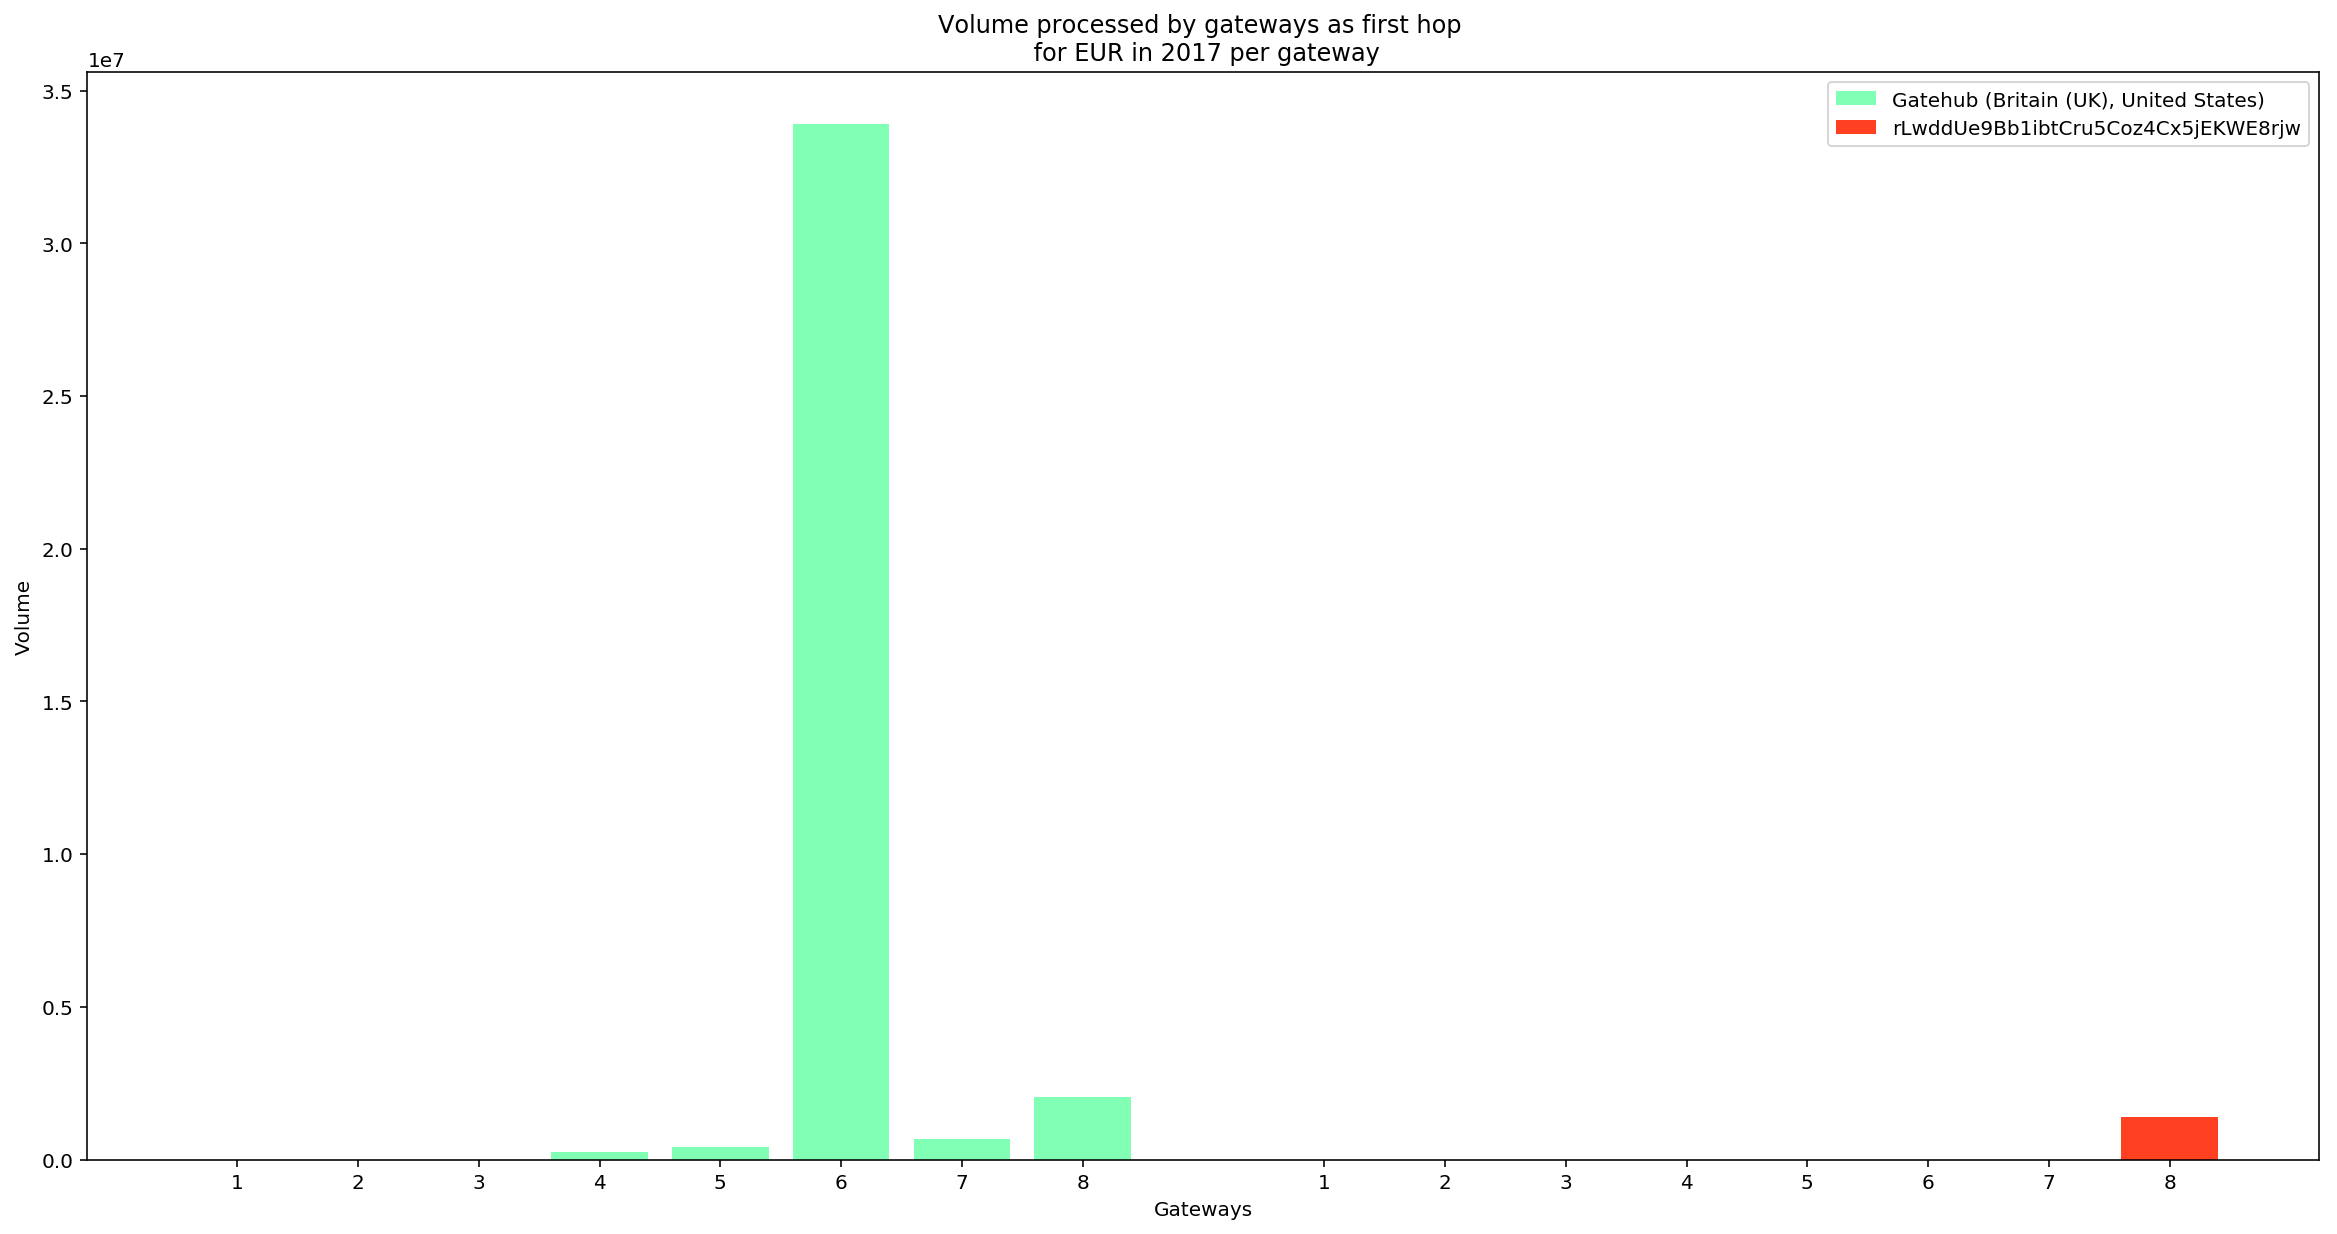

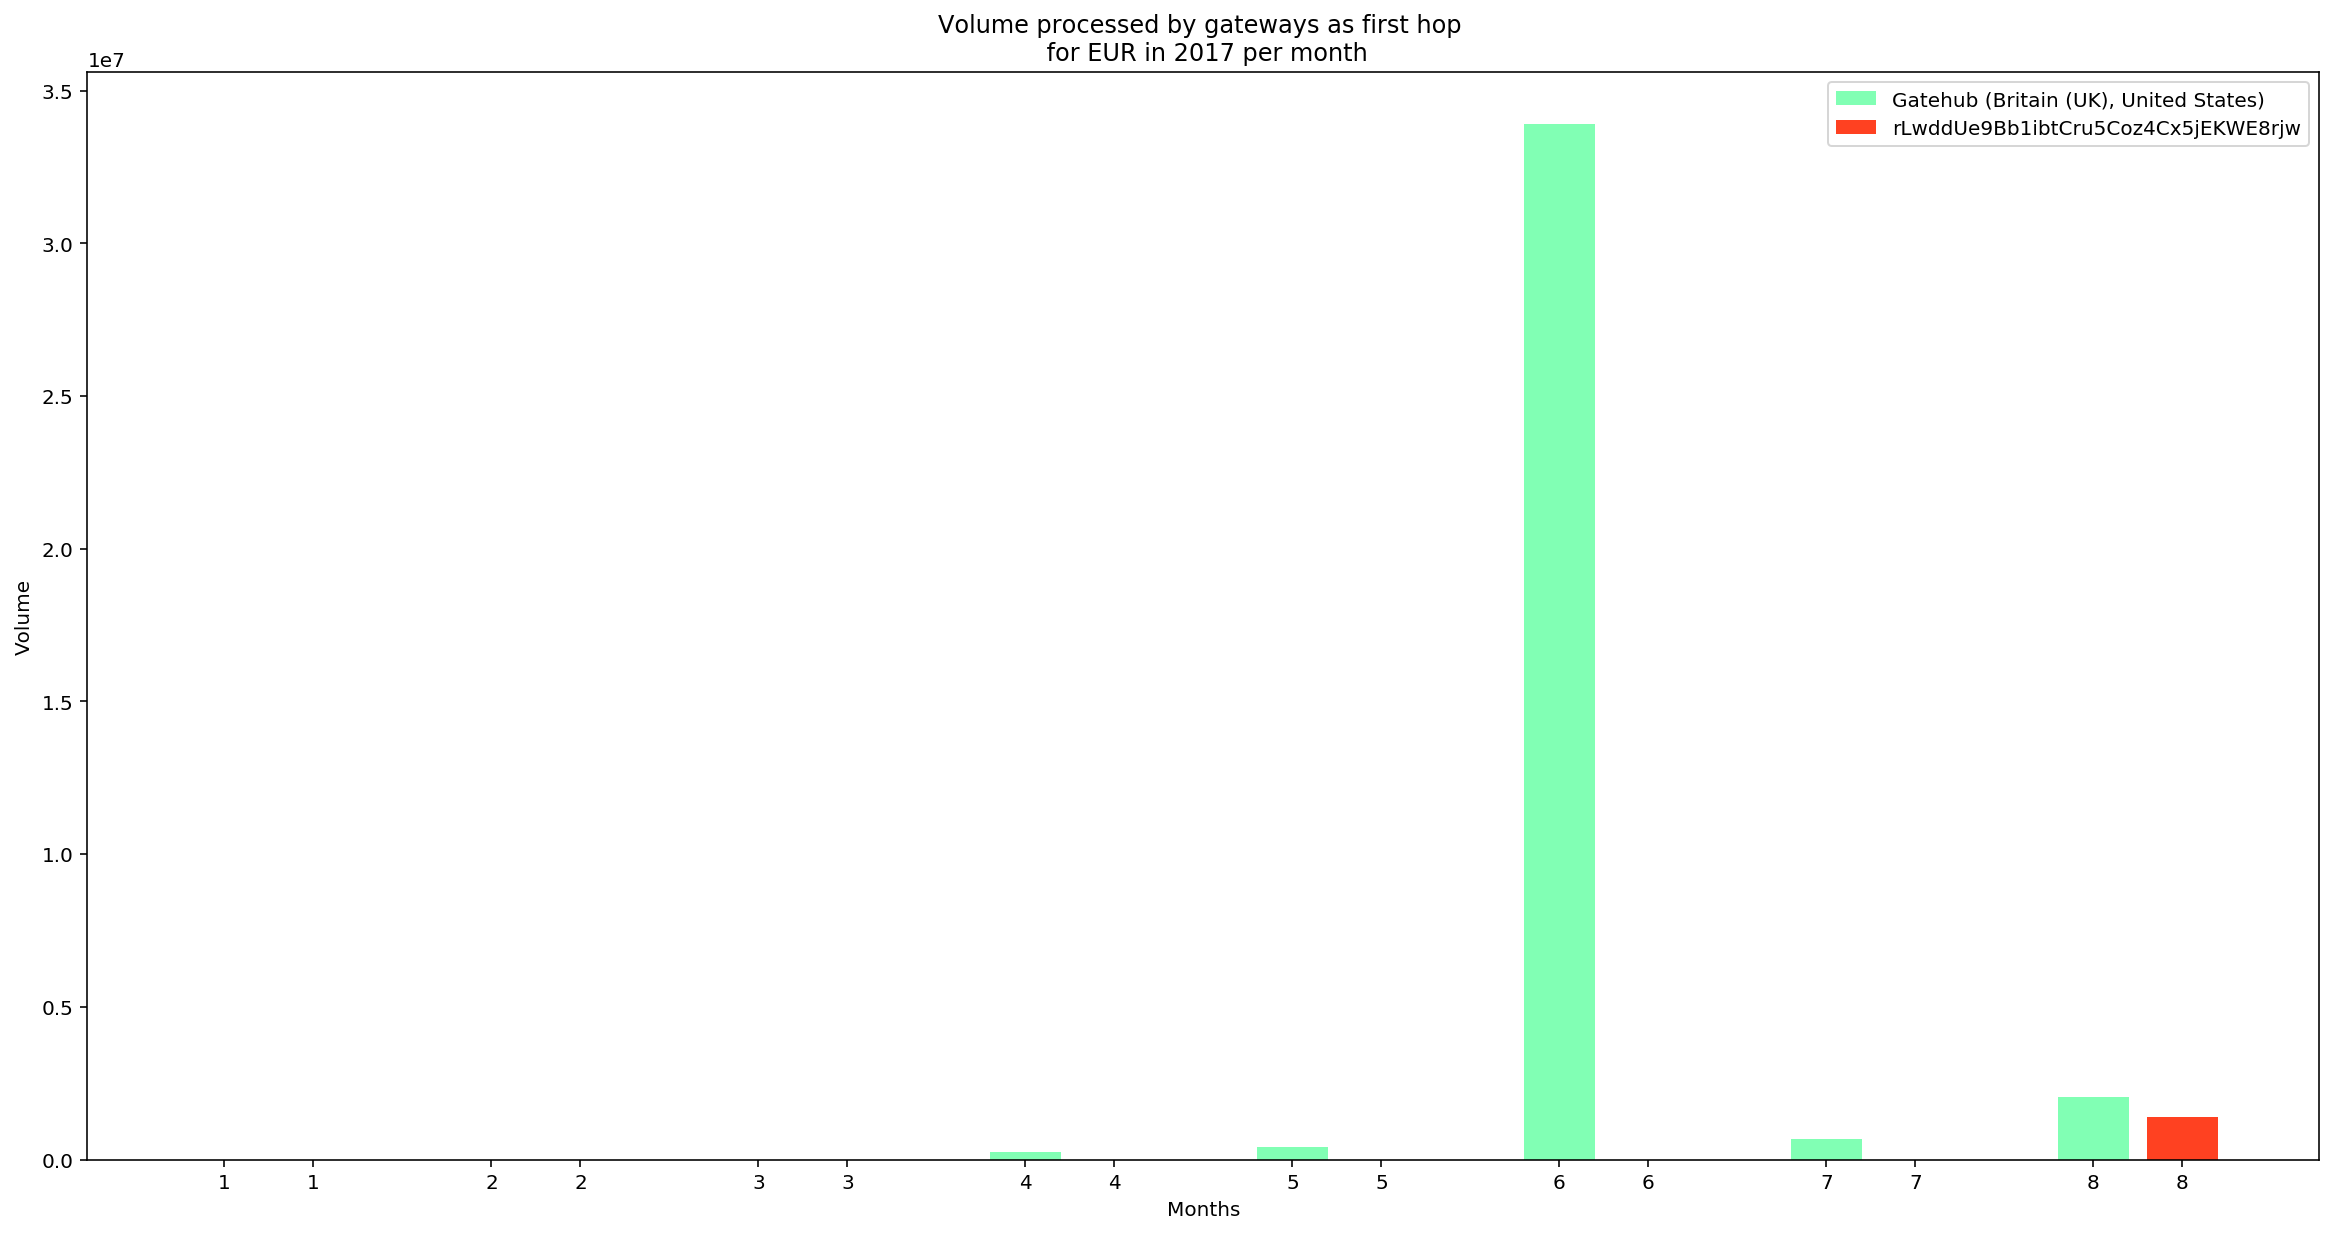

In [64]:
plot_per_gateway(dat_EUR_sender_volume,'2017','EUR','Volume','first_hop',gateways_to_colors)
plot_per_month(dat_EUR_sender_volume,'2017','EUR','Volume','first_hop',gateways_to_colors)

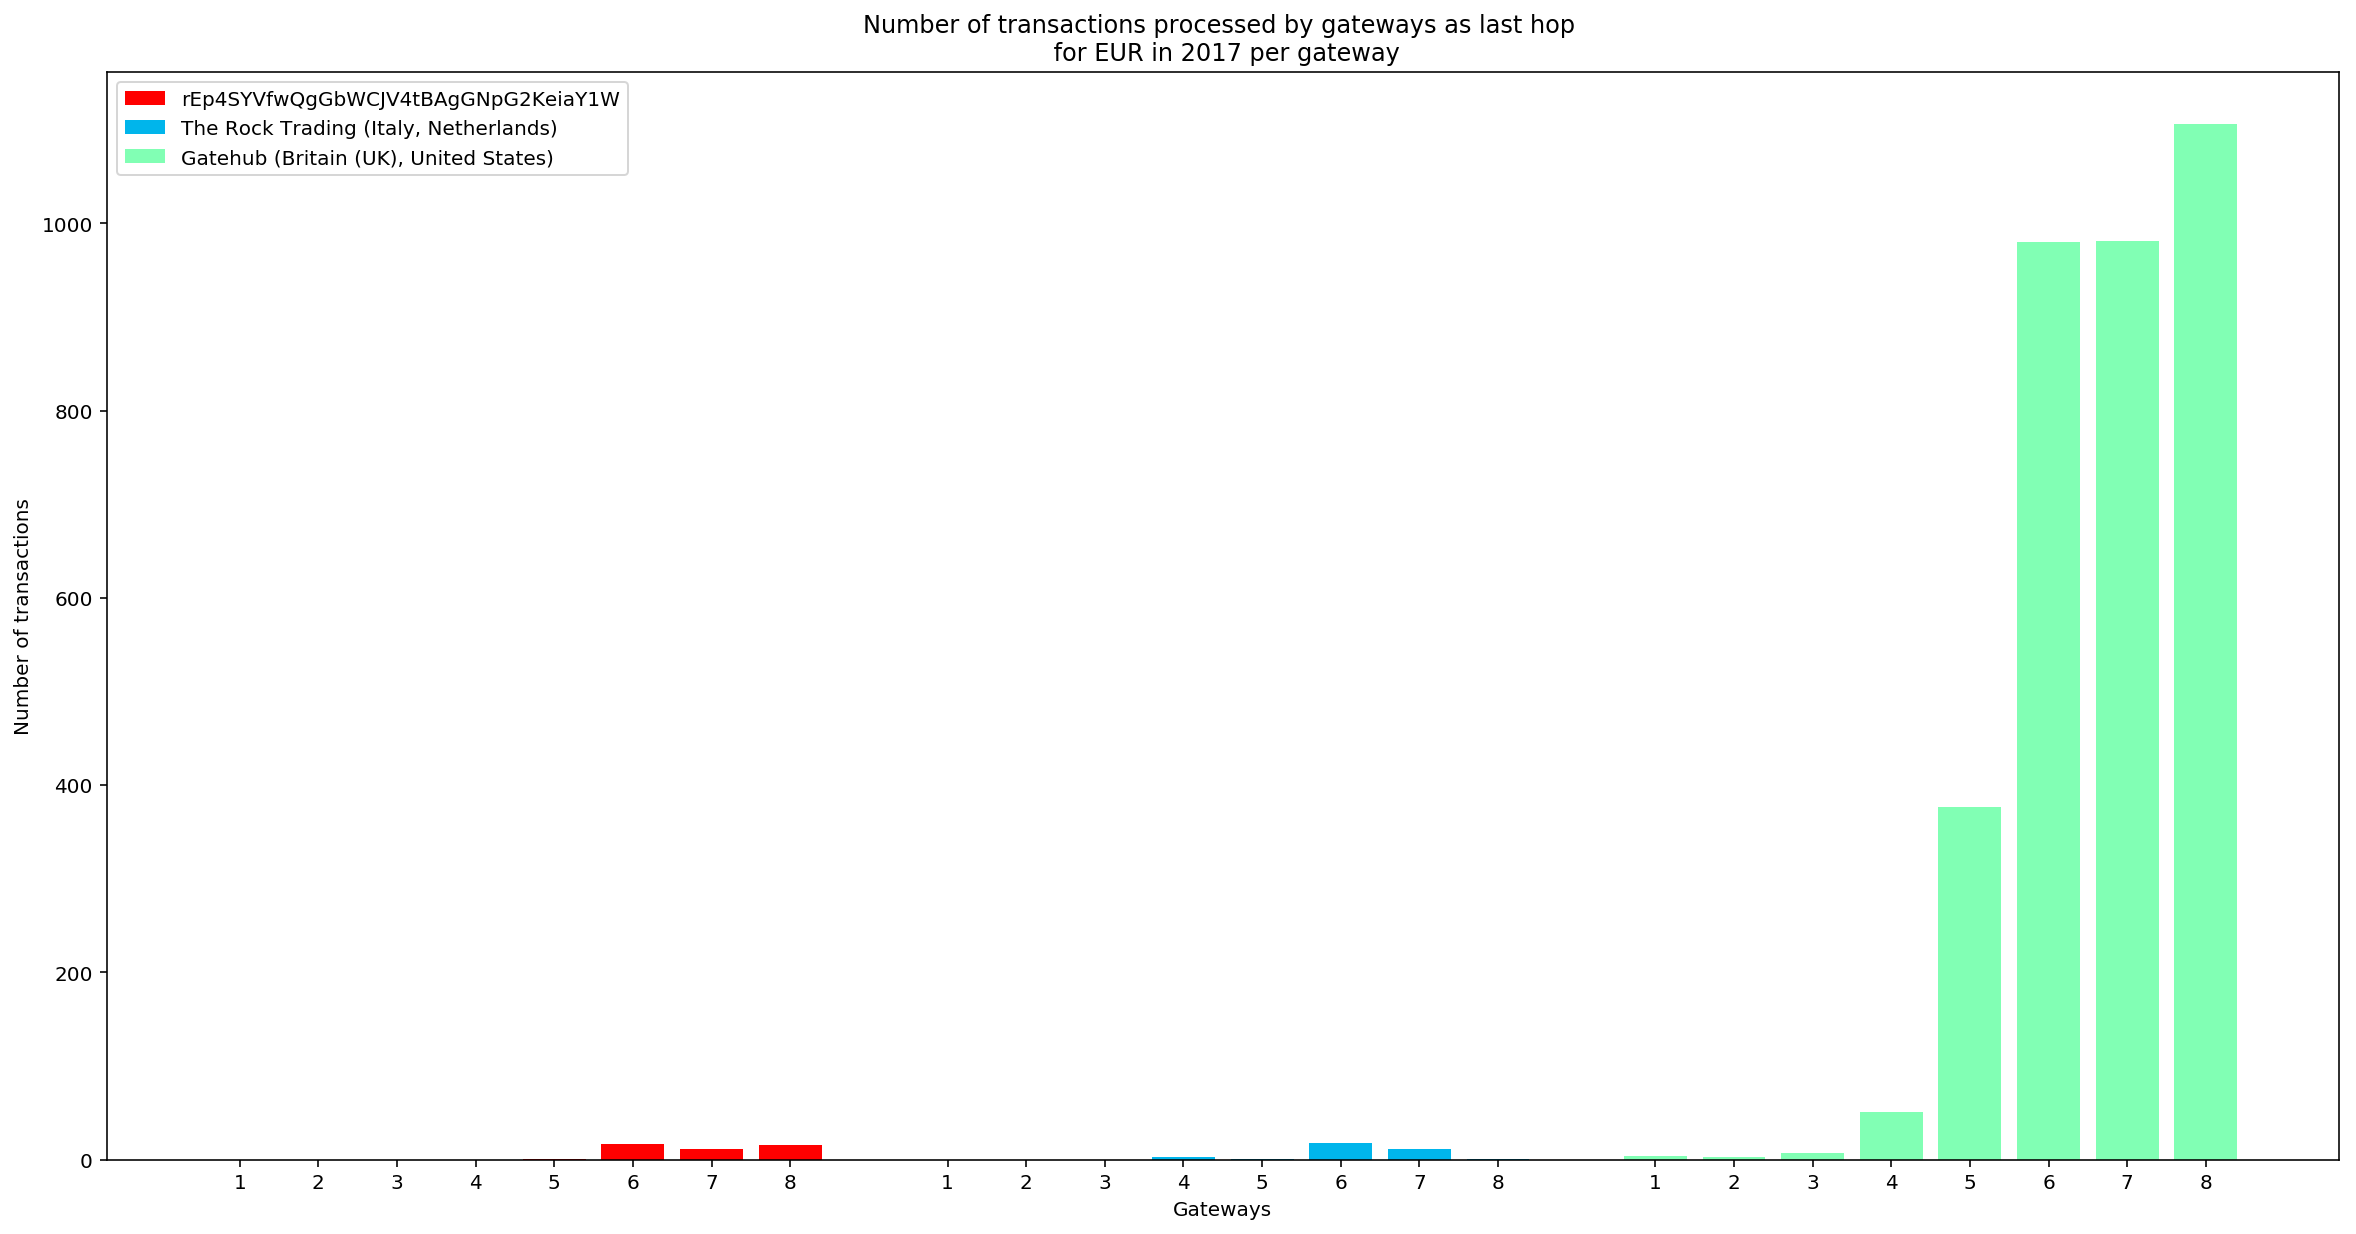

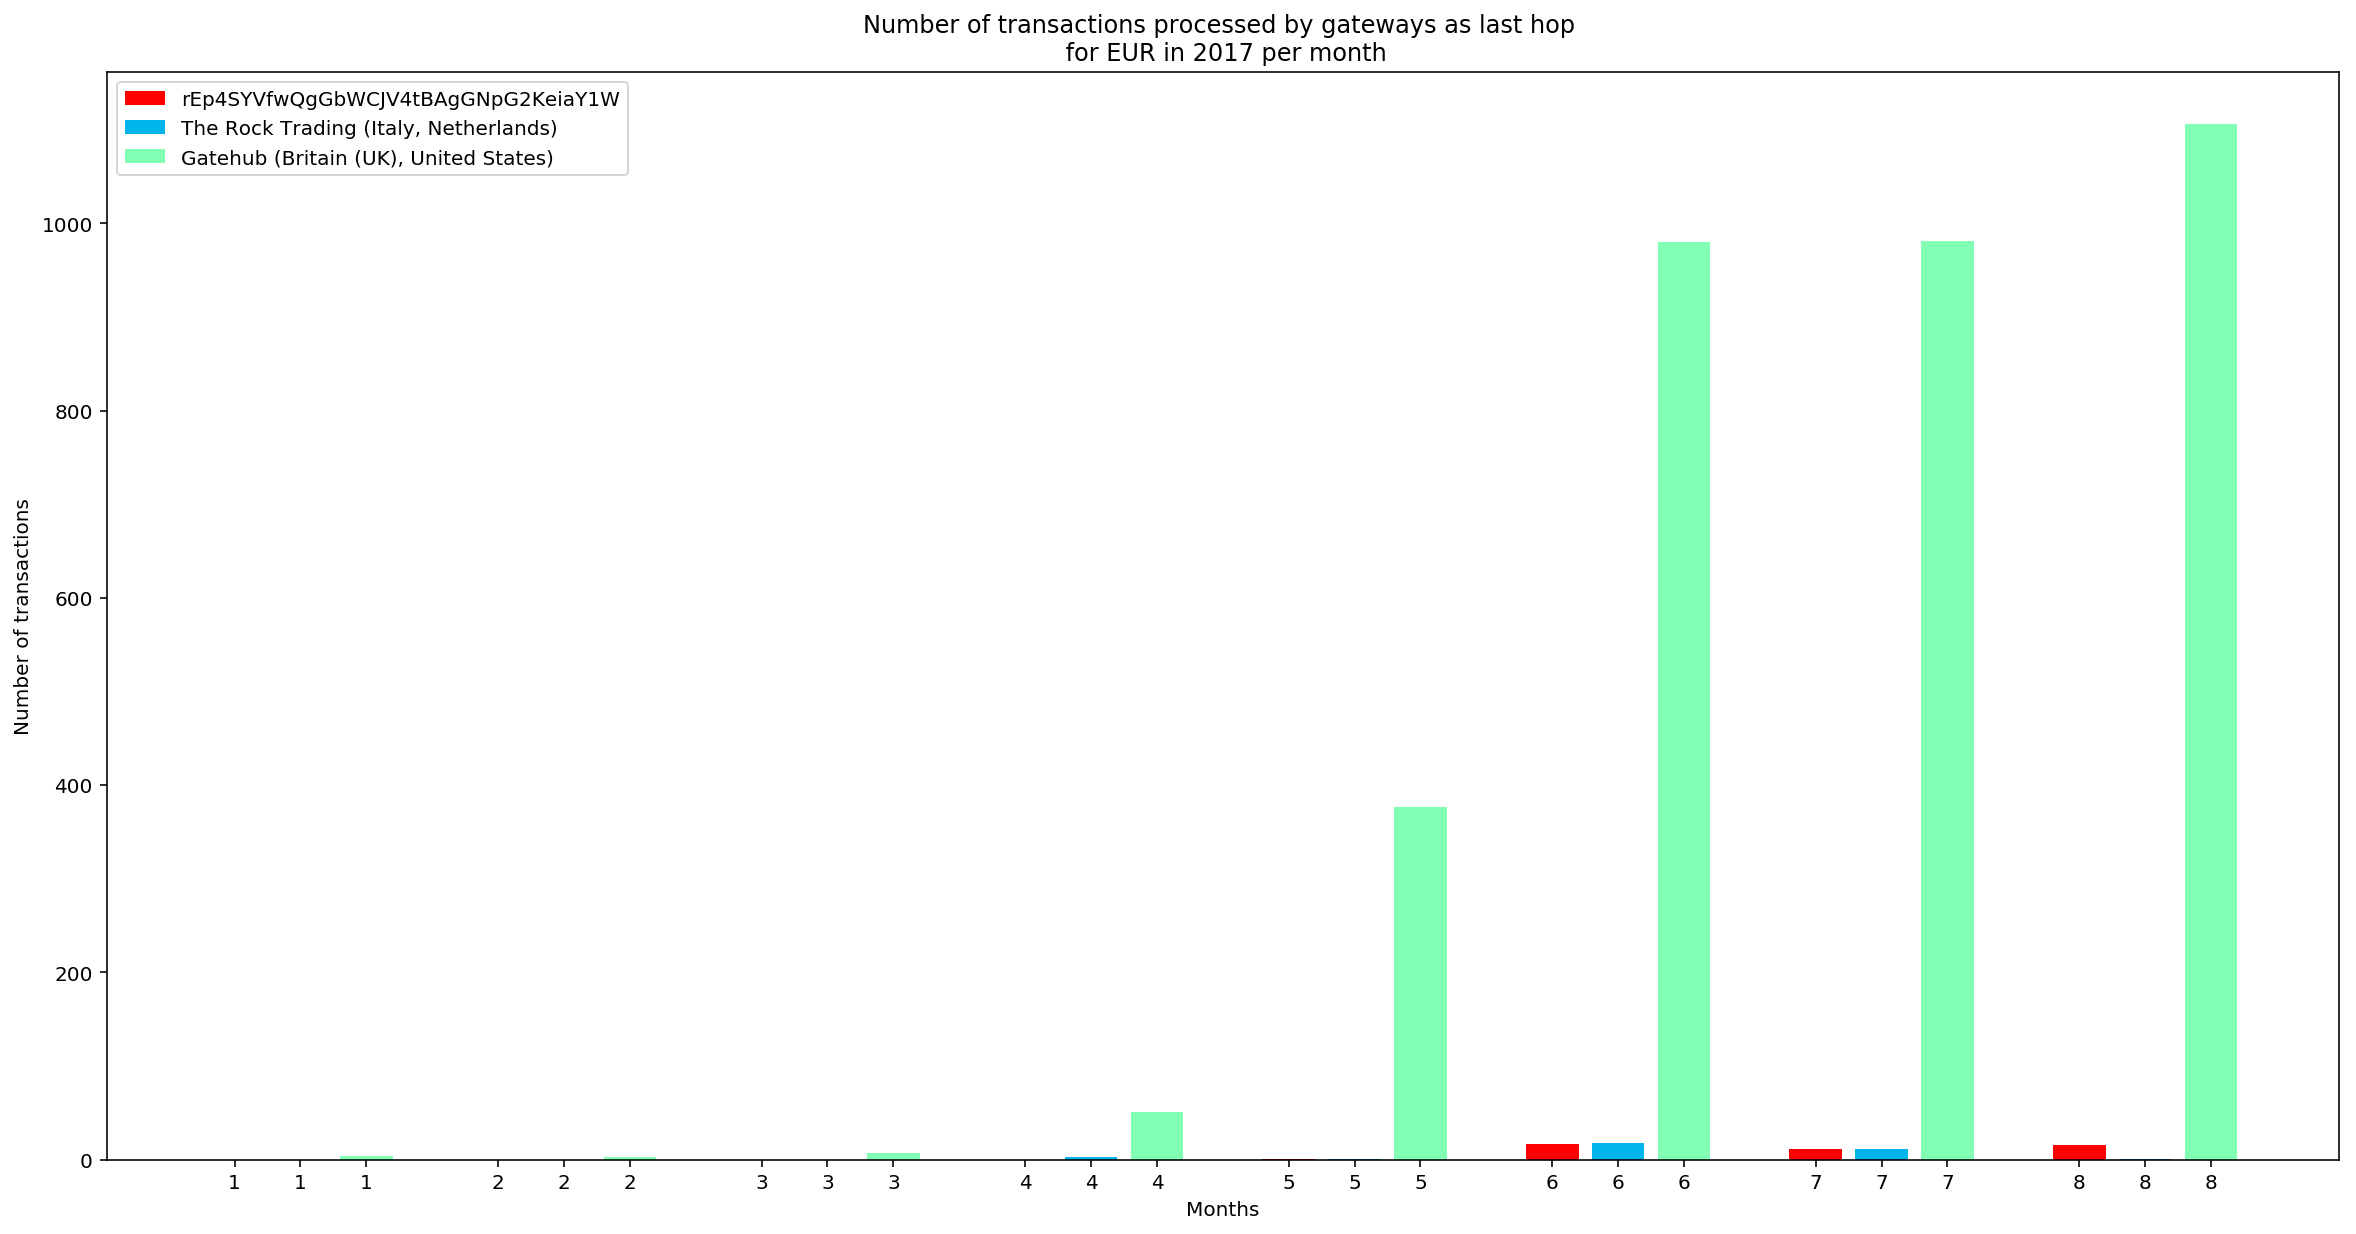

In [65]:
plot_per_gateway(dat_EUR_receiver,'2017','EUR','Number_of_transactions','last_hop',gateways_to_colors)
plot_per_month(dat_EUR_receiver,'2017','EUR','Number_of_transactions','last_hop',gateways_to_colors)

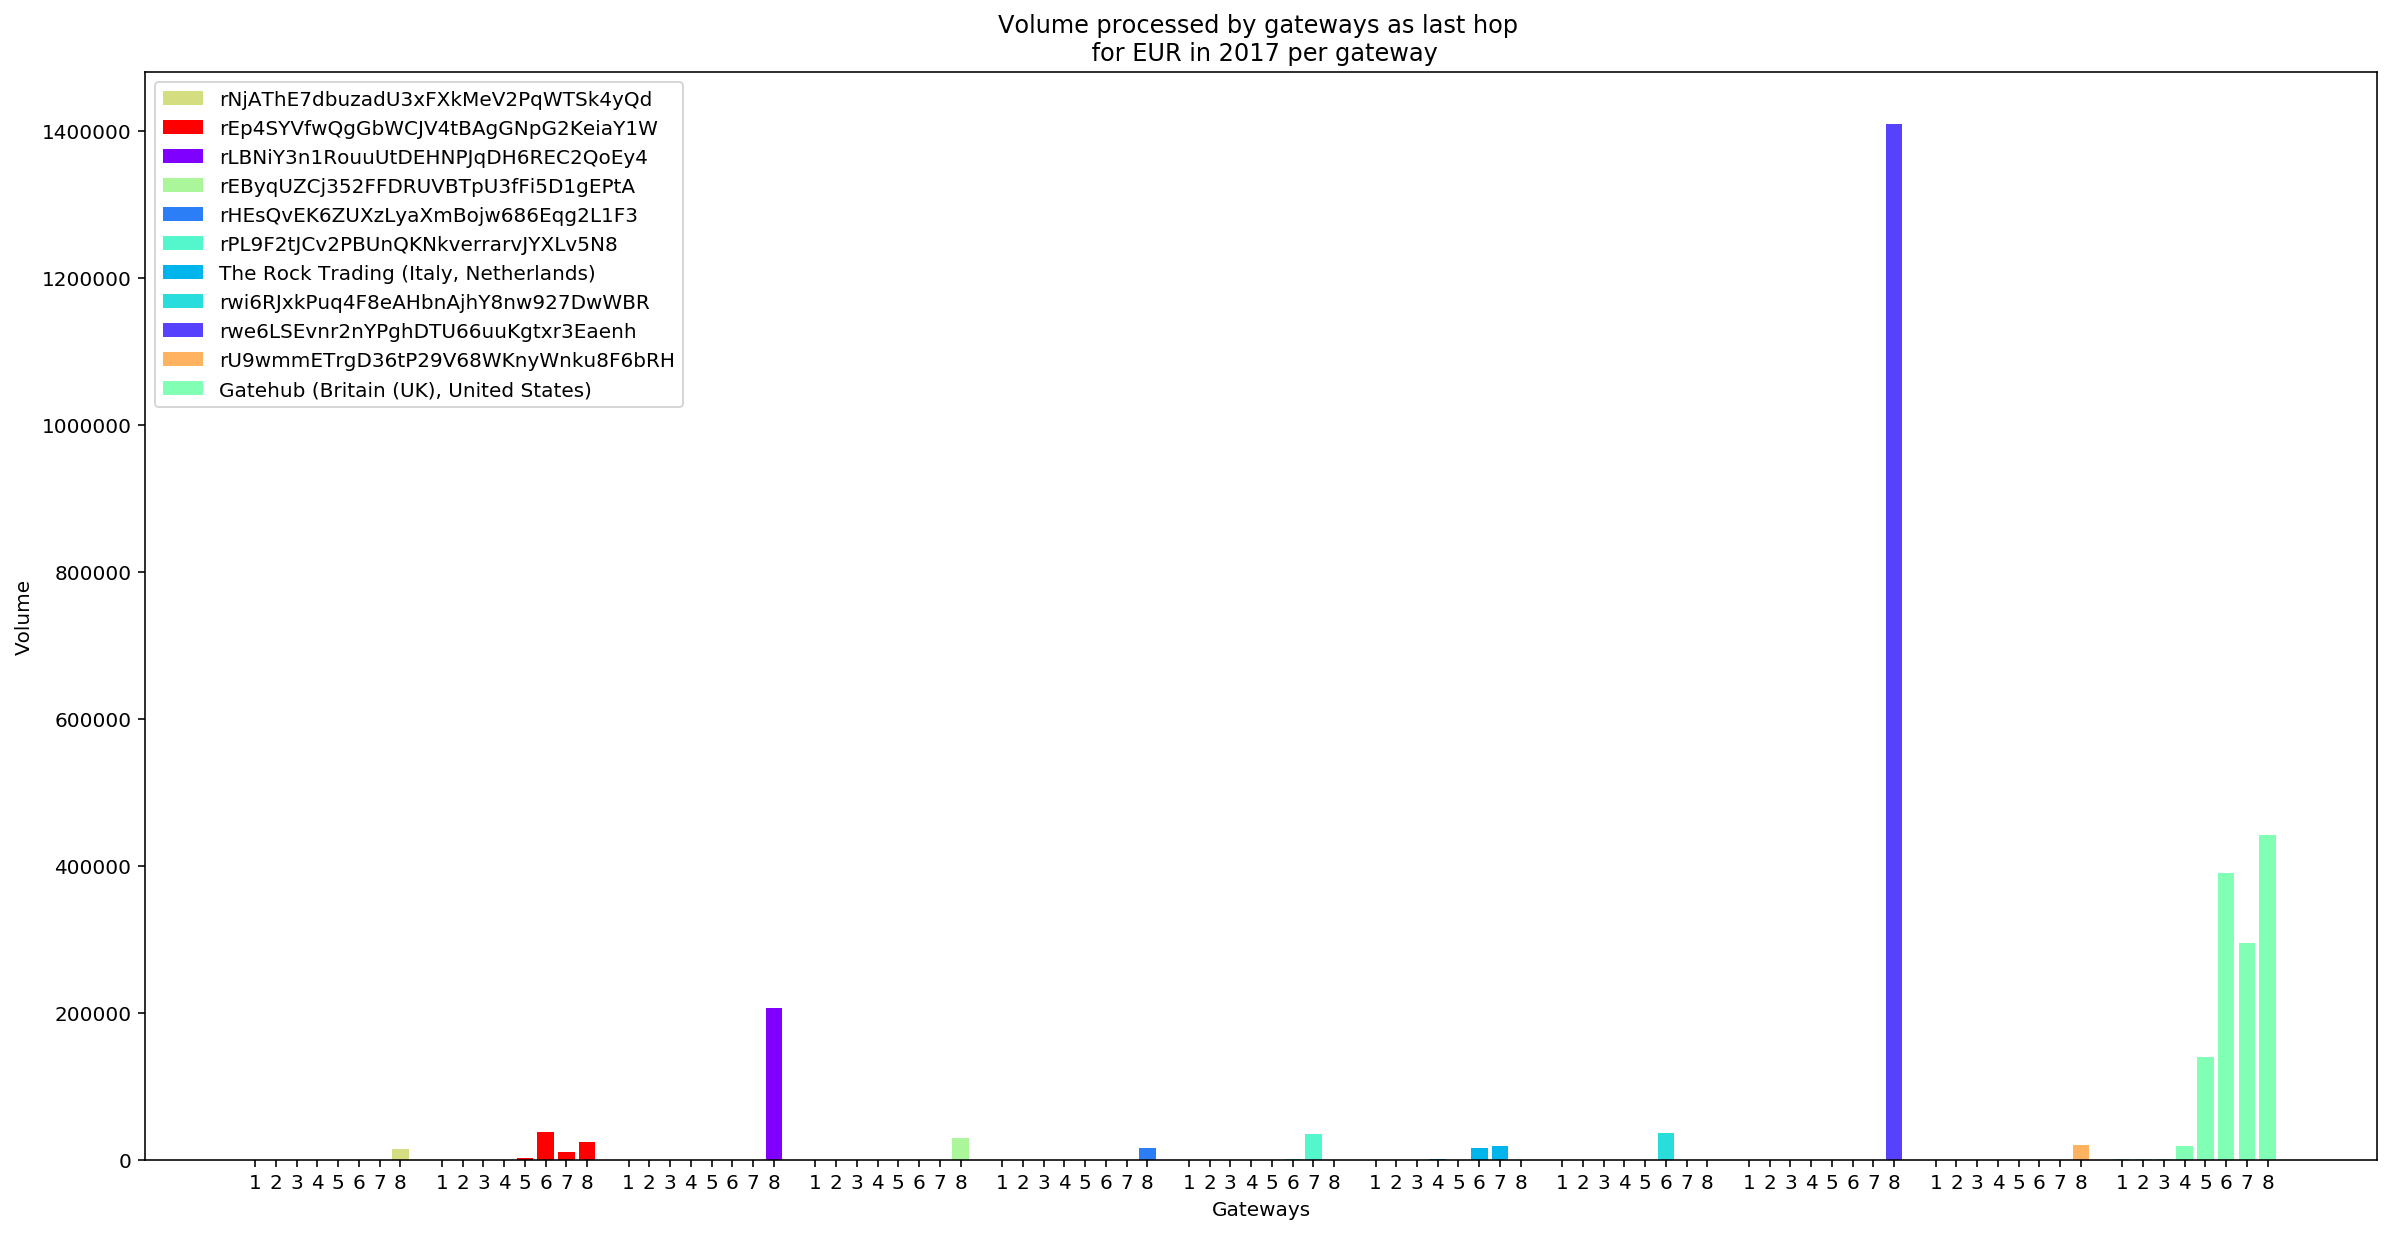

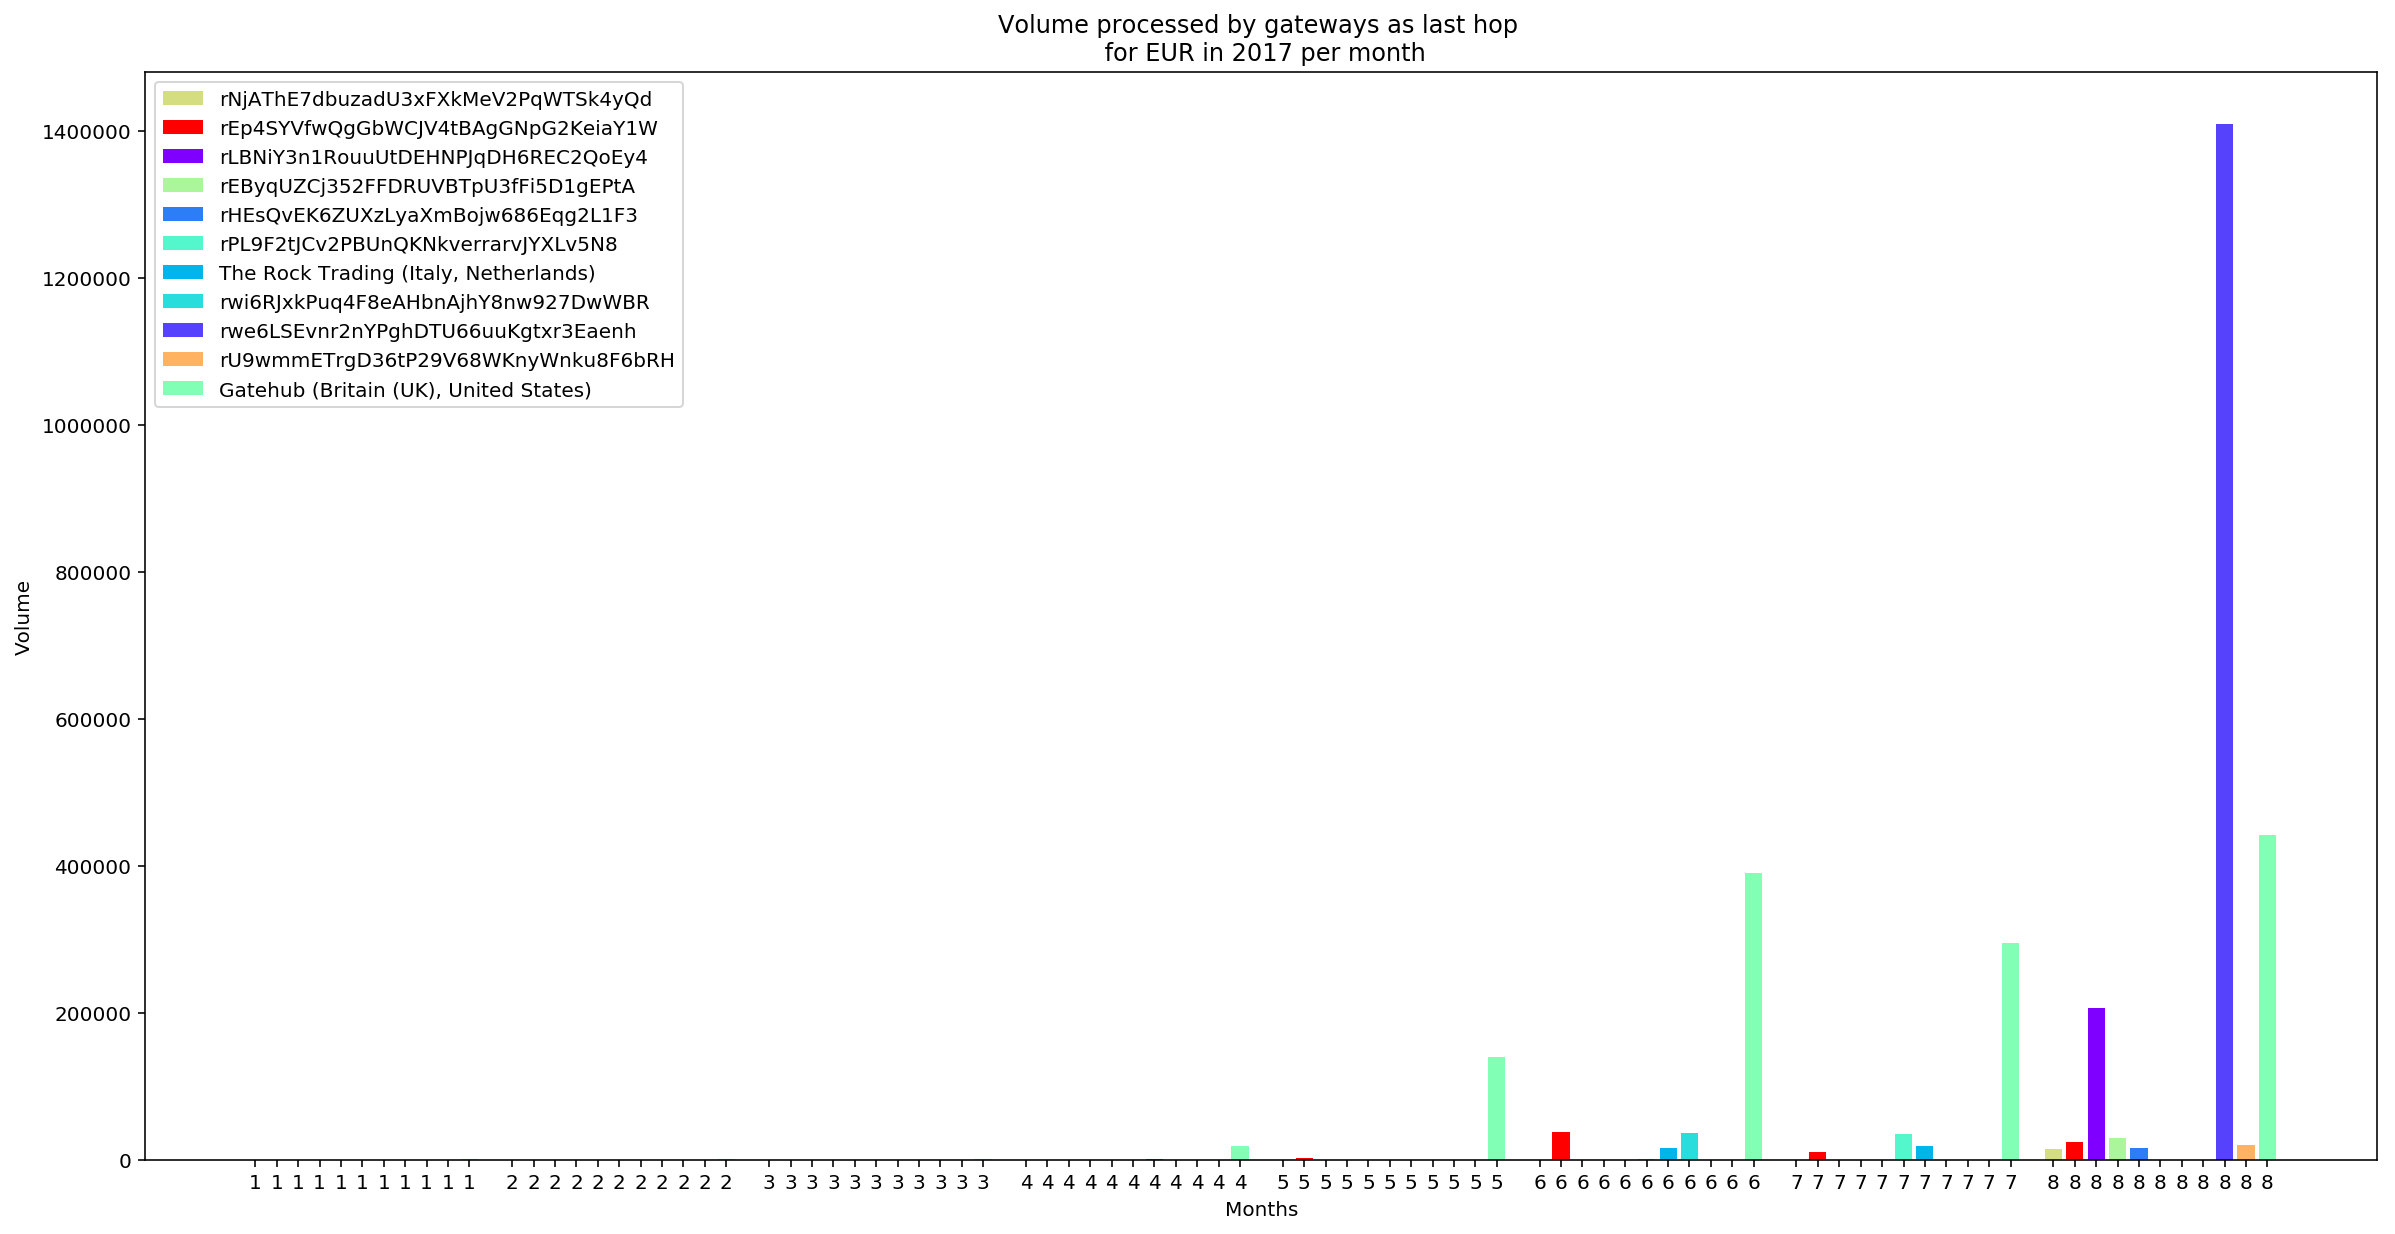

In [66]:
plot_per_gateway(dat_EUR_receiver_volume,'2017','EUR','Volume','last_hop',gateways_to_colors)
plot_per_month(dat_EUR_receiver_volume,'2017','EUR','Volume','last_hop',gateways_to_colors)